In [1]:
import numpy as np
import numpy as np
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle
import pickle
from tools.constants import NUCLEI_CHARGE, ANALYSIS_RANGE_EKIN, ISOTOPES_MASS, ISOTOPES_COLOR, ISO_LABELS
from tools.constants import DETECTOR_COLOR, ISOTOPES
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines 
import matplotlib
from tools.MassFunction import expo_func
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.binnings_collection import fbinning_energy, get_bin_center, fbinning_energy_Li, kinetic_energy_neculeon_binning
from tools.calculator import calc_rig_from_ekin, calc_ratio_and_err, calc_rig_iso, calc_beta, calc_ekin_from_rigidity_iso
from tools.constants import ISOTOPES_MASS, ISOTOPES_CHARGE, ANALYSIS_RANGE_EKIN, DETECTOR_LABEL
from tools.plottools import xaxistitle, xaxis_binning
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
import os
from tools.binnings import Binning 
import pandas as pd
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS, ISOTOPES
import uproot
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
from tools.studybeta import weighted_avg_and_std
from tools.studybeta import minuitfit_LL, cdf_gaussian, calc_signal_fraction, cdf_double_gaus, double_gaus, minuitfit_Chi
from tools.functions import cumulative_norm_gaus, normalized_gaussian, poly, upoly
from tools.jupytertools import *

/home/manbing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
ANALYSIS_RANGE_EKIN_OVERLAP = {"Tof": [0.4, 1.1], "NaF": [1.1, 4.0], "Agl": [4.0, 12.0]}
ANALYSIS_RANGE_EKIN = {"Tof": [0.4, 1.1], "NaF": [1.2, 4.0], "Agl": [4.2, 12.0]}
slicevalue ={'Tof':[0.45, 1.1], 'NaF':[1.2, 4.0], 'Agl':[4.1, 12.0]}

plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso'
os.makedirs(plotfile, exist_ok=True)

print(calc_ekin_from_rigidity_iso(15, 'Li6'))

6.607419955881759


/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso


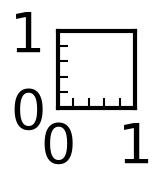

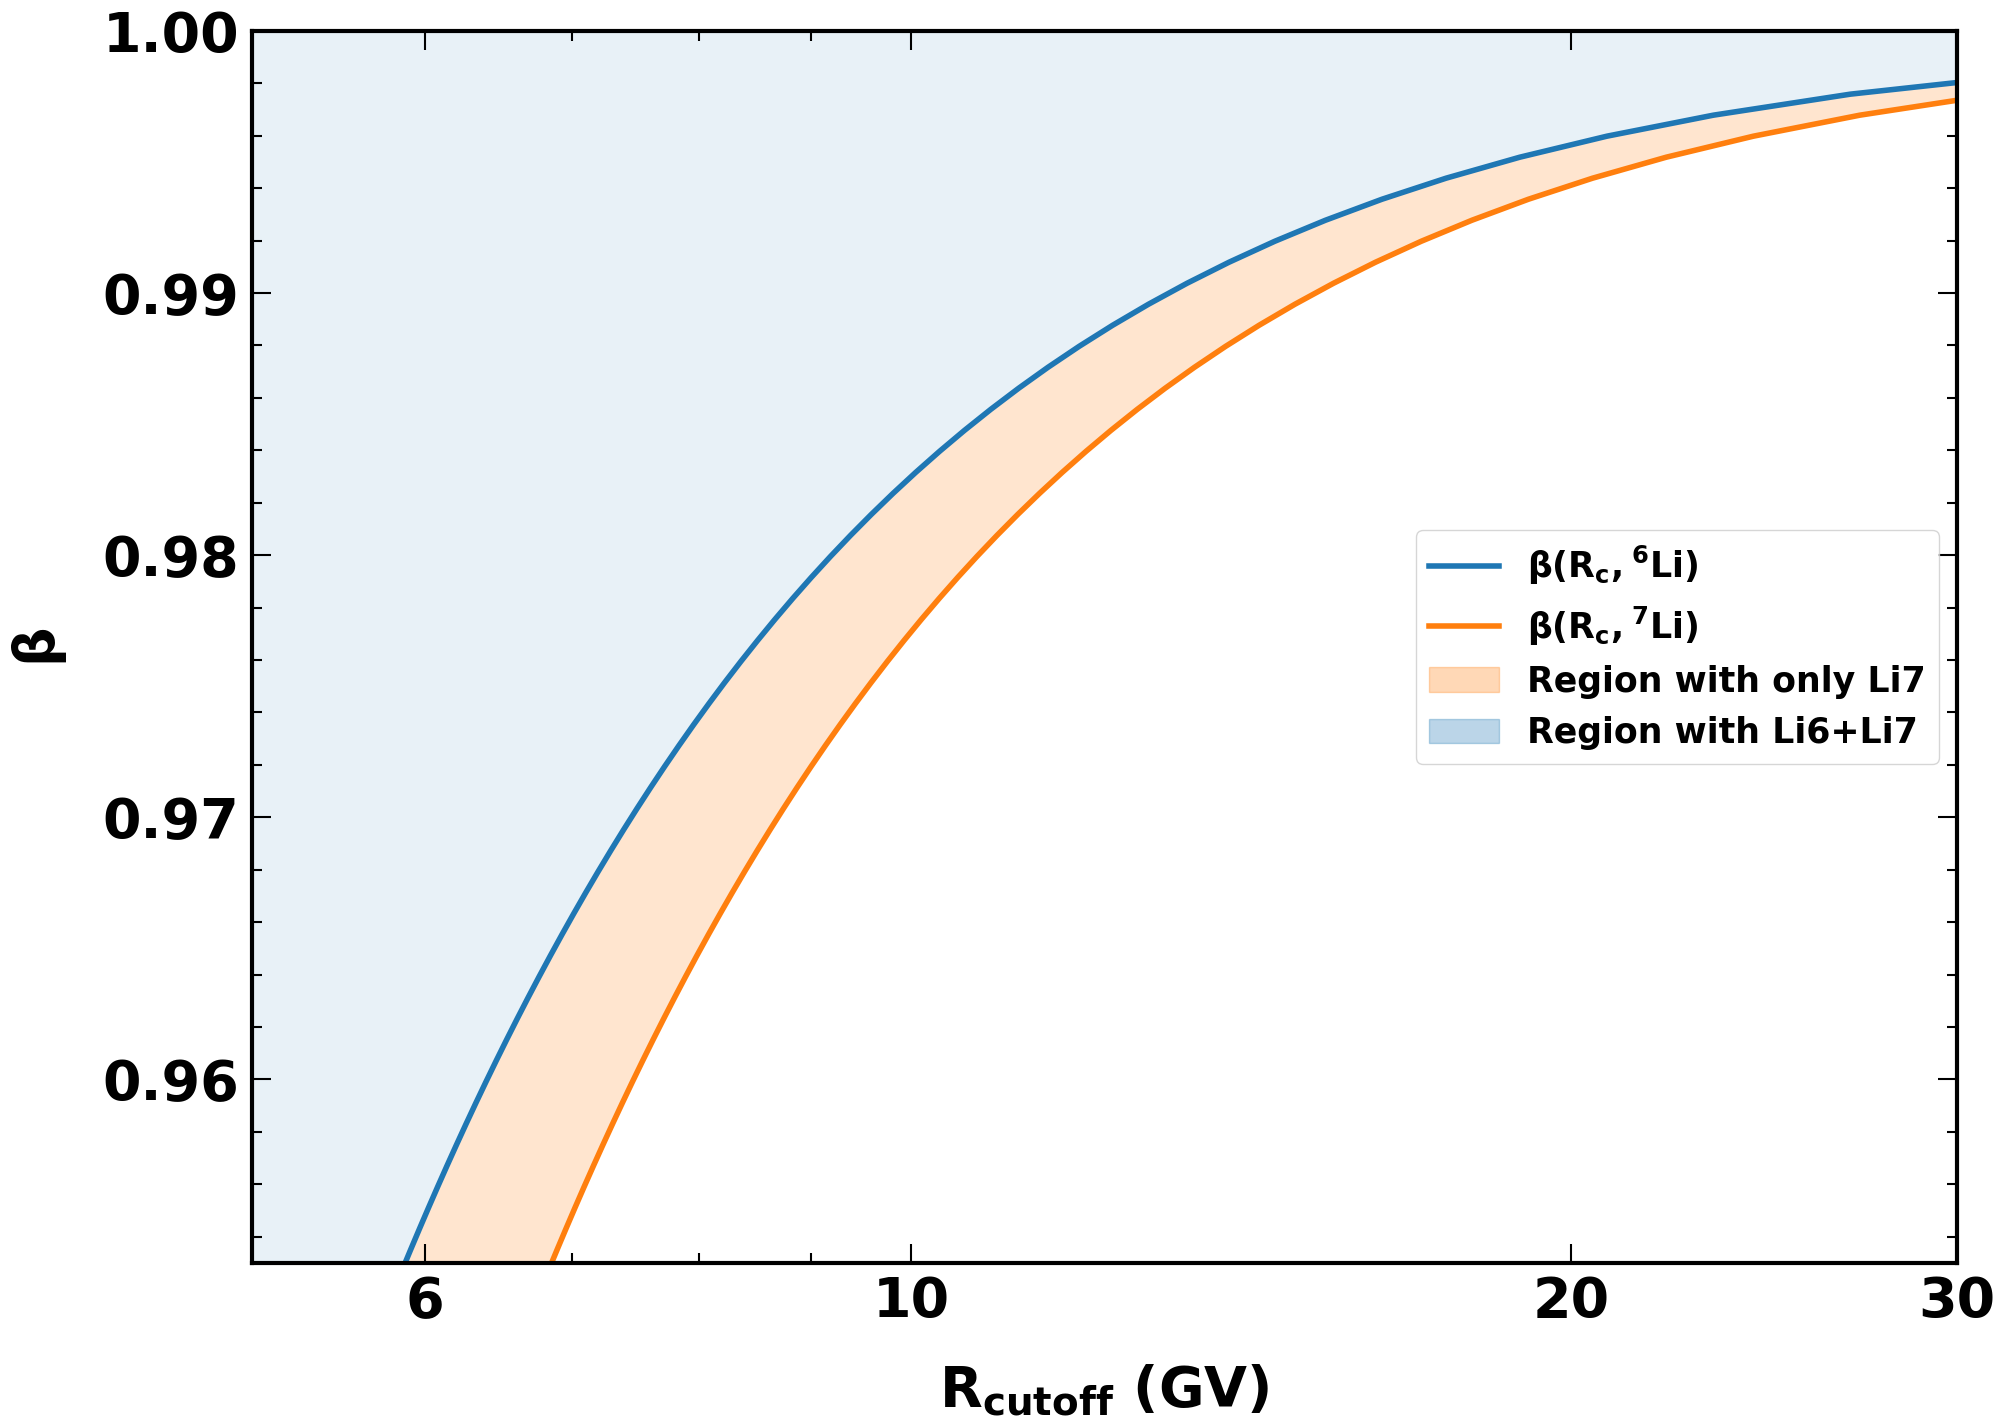

In [3]:
from matplotlib.patches import Patch
ISO_A = {'Li6': 6, 'Li7': 7}
fig, ax1 = plt.subplots(1, 1, figsize=(1,1))
set_plot_style(ax1)

beta_iso = {}
rig = {}
rig_vsBeta = {}

factor_up = {'Tof': 0.98,  'NaF': 0.998, 'Agl': 0.999}                                                                                                                                                                            
factor_low = {'Tof': 1.02,  'NaF': 1.001, 'Agl': 1.001}   

deltabeta = {} 
rig_gen = np.linspace(1, 50, 500)
beta = np.linspace(0.6, 0.99999, 500)
for iso in ISOTOPES['Li']:
    rig[iso] = calc_rig_iso(beta, iso)
    beta_iso[iso] = calc_beta(rig_gen, ISOTOPES_MASS[iso], ISOTOPES_CHARGE[iso])
    rig_vsBeta[iso] = MGraph(beta, rig[iso], np.zeros_like(rig[iso]))
    
RcfRange = {'Tof': [1.2, 5], 'NaF':[3, 20], 'Agl':[5, 30]}
BcfRange ={'Tof': [0.63, 0.9], 'NaF':[0.9, 1.0], 'Agl':[0.953, 1.0]}
detectors = ['Tof', 'NaF', 'Agl']
for dec in ['Agl']:
    fig, ax1 = plt.subplots(1, 1, figsize= FIGSIZE3)
    for iso in ISOTOPES['Li']:
        ax1.plot(rig[iso], beta,  '-', color=ISOTOPES_COLOR[iso], label=rf'$\mathrm{{\beta(R_{{c}}, ^{ISO_A[iso]}Li)}}$', linewidth=4)
        ax1.fill_between(rig_gen, beta_iso['Li7'], beta_iso['Li6'], alpha=0.1, color="tab:orange") 
    ax1.fill_between(rig_gen, np.ones_like(beta_iso['Li6']), beta_iso['Li6'], alpha=0.1, color="tab:blue")    
    SetAx1Axis(ax1, r'$\mathrm{R_{cutoff} \ (GV)}$', r'$\mathrm{\beta}$', TEXTSIZE, xlimrange=RcfRange[dec], ylimrange=BcfRange[dec], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setylog=False, setxlog=True)
    
    set_plot_style(ax1)
    
    orange_patch = Patch(color='tab:orange', alpha=0.3, label='Li7-Li6 Range')
    blue_patch = Patch(color='tab:blue', alpha=0.3, label='Below Li6 Range')
    
    # Combine patches with existing legend entries
    handles, labels = ax1.get_legend_handles_labels()
    handles.extend([orange_patch, blue_patch])
    labels.extend(['Region with only Li7', 'Region with Li6+Li7'])
    ax1.legend(handles=handles, labels=labels, fontsize=25, loc='center right')
    
    ax1.set_xticks([6, 10, 20, 30])                                                                                                                                                                      
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    savefig_tofile(fig, plotfile, f"func_betaVsR_Li", 1)   
    print(plotfile)


In [4]:
file_beta = '/home/manbing/Documents/Data/data_LiP8/Hist2D/LiMC_hist_AllHist.npz'

detectors = ['Tof', 'NaF', 'Agl']
hist2d_beta = {dec: {} for dec in detectors}
gammalim = {'Tof':[1.6, 5.0], "NaF":[2.0, 10.0], "Agl":[3.3, 15.0]}
yresolim = {'Tof':[-0.16, 0.16], "NaF":[-0.03, 0.02], "Agl":[-0.005, 0.005]}
nuclei = 'Li'
isotopes = ISOTOPES[nuclei]
Num = ['a', 'b', 'c']
with np.load(file_beta) as npzfile:
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(20, 20))
    ax = [ax1, ax2, ax3]
    for i, dec in enumerate(detectors):
        for iso in isotopes:
            hist2d_beta[dec][iso] = WeightedHistogram.from_file(npzfile, f"hist2d_beta_resolution_{dec}{iso}") 
            if iso == 'Li6':
                plot2dhist(fig, ax[i], xbinning=hist2d_beta[dec][iso].binnings[0].edges[1:-1],
                           ybinning=hist2d_beta[dec][iso].binnings[1].edges[1:-1],
                           counts=hist2d_beta[dec][iso].values[1:-1, 1:-1], 
                           xlabel='', ylabel='', zlabel="counts", zmin=None, zmax=None, 
                           setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=True)  
                ax[i].text(0.05, 0.98, f"({Num[i]}) ", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold")          
                ax[i].set_xlim([0.2, 20])
                ax[i].set_ylim(yresolim[dec])
                ax[i].set_xscale('log')
                  
        
    ax3.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$", fontsize=40)     
    #ax3.set_xticks([0.4, 1, 2, 10, 30, 100])                                                                                                                                                                      
    #ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
    ax1.sharex(ax3)   
    ax2.sharex(ax3)
    ax2.set_ylabel(r"$\mathrm{(\beta_{m} -\beta_{t})/\beta_{t}}$", fontsize=50) 
    for label in ax1.get_xticklabels():
        label.set_visible(False)
    # Repeat the process for ax2
    for label in ax2.get_xticklabels():
        label.set_visible(False)

    set_plot_defaultstyle(ax1)                                                                                                                                                                                 
    set_plot_defaultstyle(ax2)   
    plt.subplots_adjust(hspace=.05)
    ax1.set_xticks([0.5, 1, 2, 5, 10])                                                                                                                                                                      
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())    
    print(plotfile)
    savefig_tofile(fig, plotfile, f"{iso}hist2d_betareso_vs_ekn", show=True)                                                                                                                 



/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso


/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso


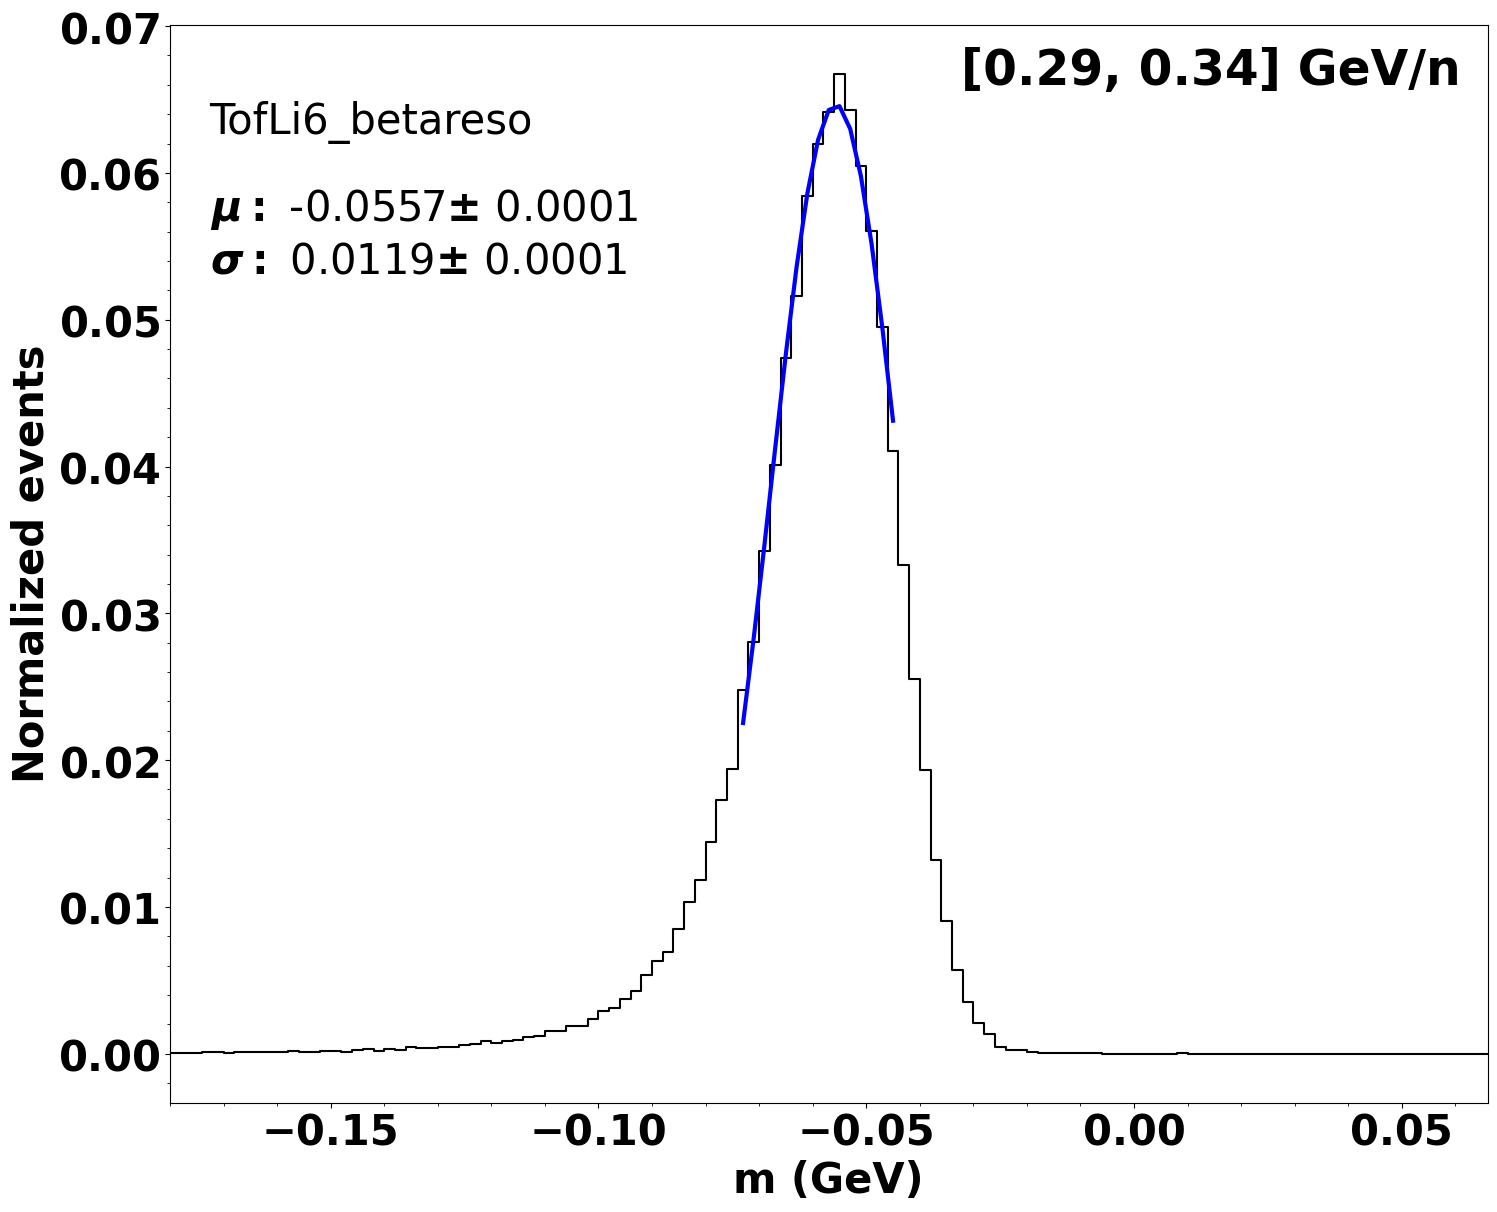

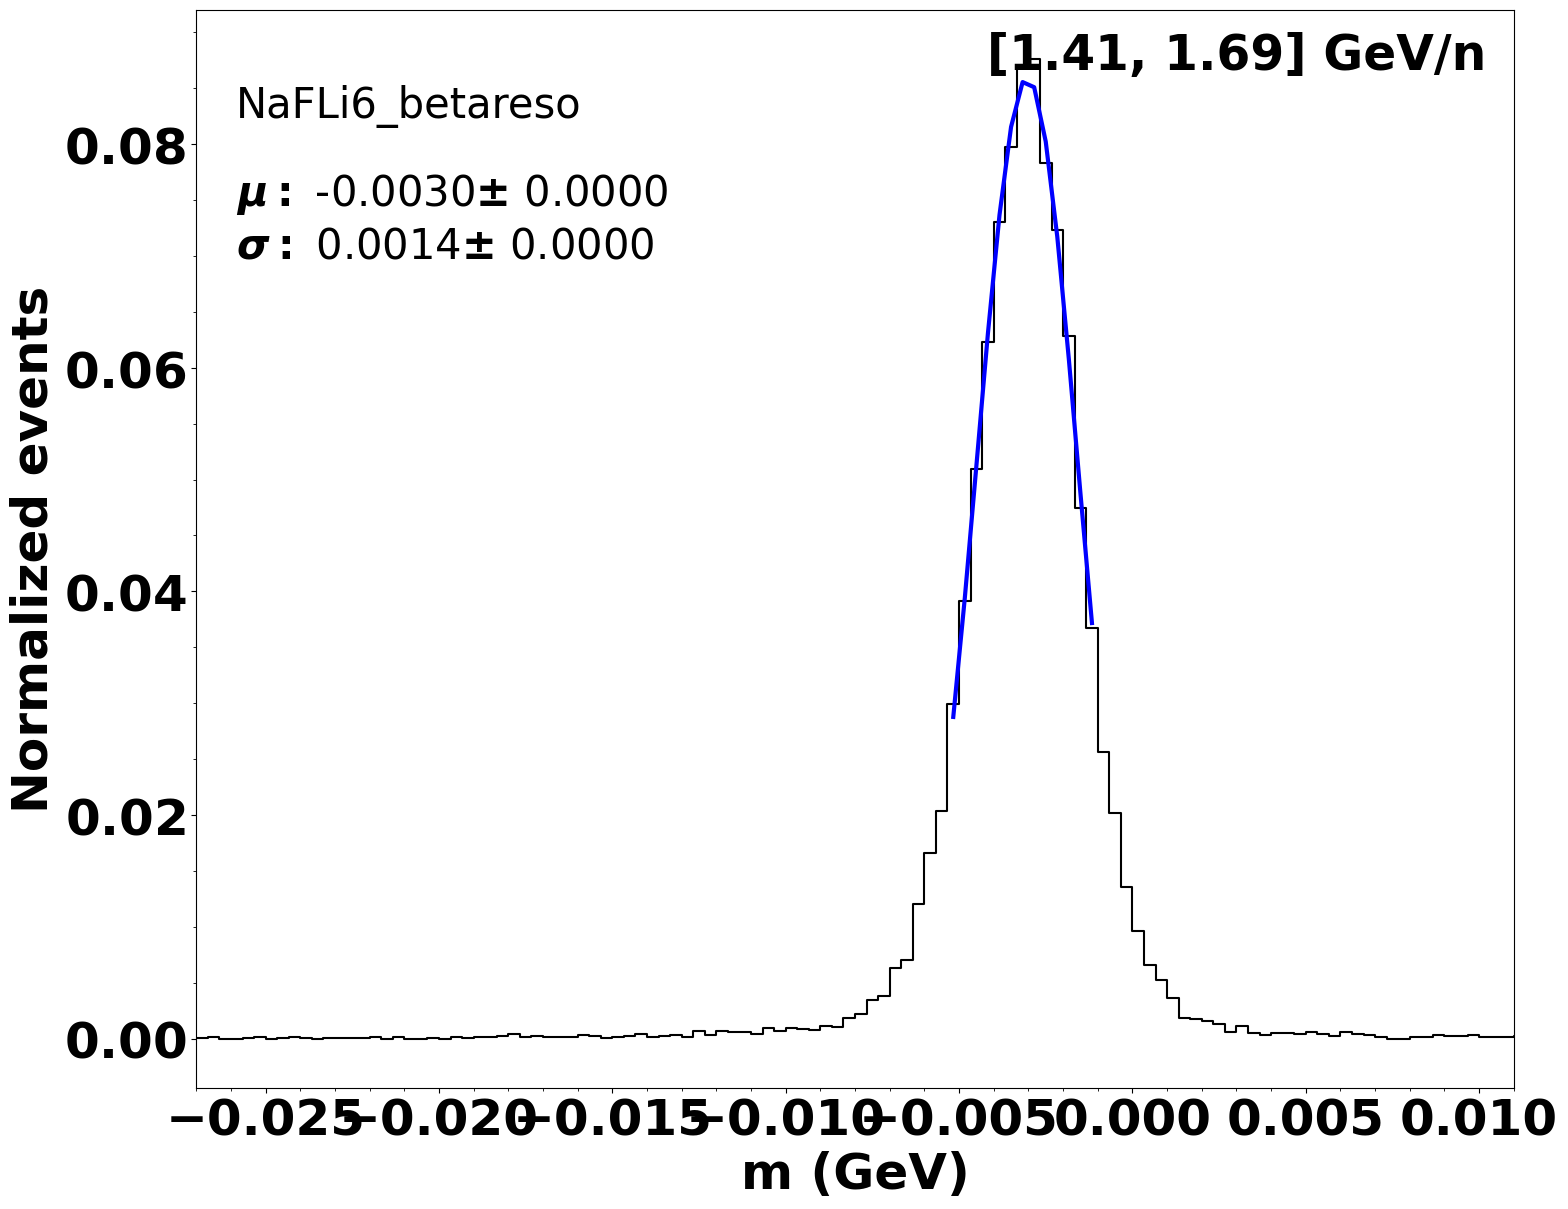

In [5]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/betareso/df_betareso_sigma.npz'
#filename_hist = '/home/manbing/Documents/Data/data_BeP8/Hist2D/BeMC_hist_RICHBeta2CorVsEkinGenAtDec_finebin.npz'
filename_hist = '/home/manbing/Documents/Data/data_LiP8/Hist2D/LiMC_hist_AllHist.npz'
npzfile = np.load(f'{filename_hist}')
df_sigma = np.load(f'{filename}')
graph_betasigma = {dec: {} for dec in detectors}
graph_mean = {dec: {} for dec in detectors}
graph_sigma = {dec: {} for dec in detectors}

minbin = {'Tof': 6, 'NaF':15, 'Agl':20}
maxbin =  {'Tof':28,  'NaF':28, 'Agl':28}
guess0 = {'Tof': dict(norm=1, mu=-0.001, sigma=0.01), 
          'NaF': dict(norm=1, mu=-0.001, sigma=0.001),
         'Agl': dict(norm=1, mu=-0.0001, sigma=0.0005)}
xfitrange = {'Tof':[-0.2, 0.06], "NaF":[-0.03, 0.01], "Agl":[-0.0045, 0.003]}


ylimreso = {'Tof':[0.007, 0.02], "NaF":[0.001, 0.0015], "Agl":[0.0003, 0.0006]}
    
fig, ax1 = plt.subplots(1, 1, figsize= (20, 14))
for i, dec in enumerate(detectors):
    for iso in ['Li6']:
        hist2d_beta[dec][iso] = WeightedHistogram.from_file(npzfile, f"hist2d_beta_resolution_{dec}{iso}") 
        #graph_betasigma[dec][iso] = MGraph.from_file(df_sigma, f"graph_sigma_{dec}_{iso}")
        graph_mean[dec][iso], graph_sigma[dec][iso] = get_musigma_gausfit(hist2d_beta[dec][iso], minbin[dec], maxbin[dec], guess0[dec], xfitrange[dec], fitNsig=1.3,  FigName=f'{dec}{iso}_betareso', plotfile=plotfile)
        plot_graph(fig, ax1,  graph_sigma[dec][iso], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    ax1.set_ylim([0.00017, 0.3])
ax1.set_xlabel("Ekin/n (GeV/n)")     
ax1.set_yscale('log')
SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', r'$\sigma (\mathrm{\Delta \beta/\beta})$', 45, xlimrange=[0.4, 12], ylimrange=[0.0002, 0.02] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= True)
set_plot_defaultstyle(ax1)                                                                                                                                                                                 
plt.subplots_adjust(hspace=.05)

print(plotfile)


/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso


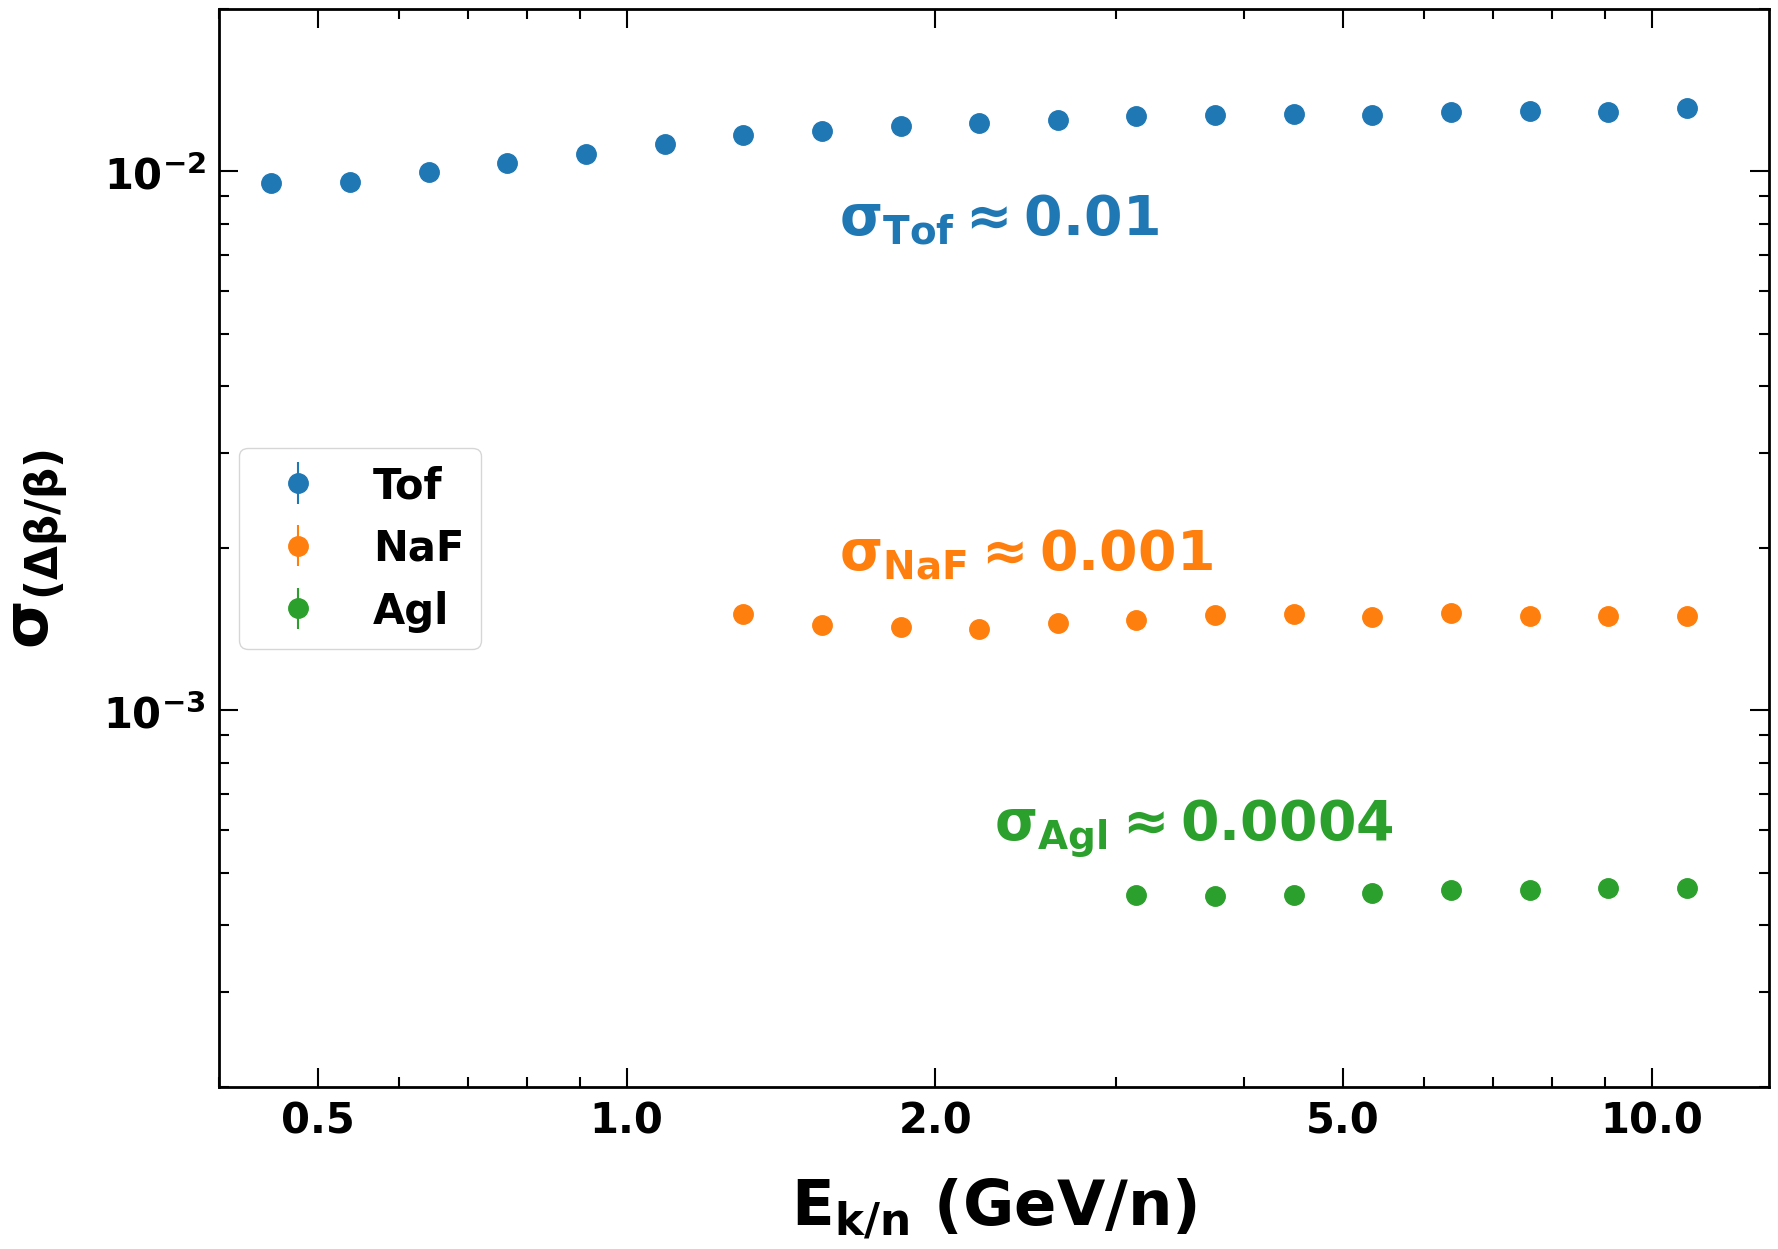

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize= (1, 1))
set_plot_style(ax1)

fig, ax1 = plt.subplots(1, 1, figsize= (20, 14))
MKSIZE = 28
for i, dec in enumerate(detectors):
    for iso in ['Li6']:
        plot_graph(fig, ax1,  graph_sigma[dec][iso], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=MKSIZE, label=f'{dec}')  

SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', r'$\mathrm{\sigma_{(\Delta \beta/\beta)}}$', 45, xlimrange=[0.4, 13], ylimrange=[0.0002, 0.02] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= True)
set_plot_style(ax1)
ax1.text(0.4, 0.83, rf"$\mathrm{{\sigma_{{Tof}} \approx 0.01}}$", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR['Tof'], weight='bold')                                                                                                                                                                                                                                    
ax1.text(0.4, 0.52, rf"$\mathrm{{\sigma_{{NaF}} \approx 0.001}}$", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR['NaF'], weight='bold')     
ax1.text(0.5, 0.27, rf"$\mathrm{{\sigma_{{Agl}} \approx 0.0004}}$", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR['Agl'], weight='bold')     
set_plot_defaultstyle(ax1)  
ax1.legend(loc='center left')
ax1.set_yscale('log')
plt.subplots_adjust(hspace=.05)
ax1.set_xticks([0.5, 1, 2, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
print(plotfile)
savefig_tofile(fig, plotfile, f"graph_betareso_alldec", show=True)   


[0.5144  0.7332  1.01135]
[1.01135 1.35695 1.7779  2.28735 2.8959  3.61425]
[ 3.61425  4.45875  5.4516   6.58395  7.88955  9.425   11.19025]
/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso


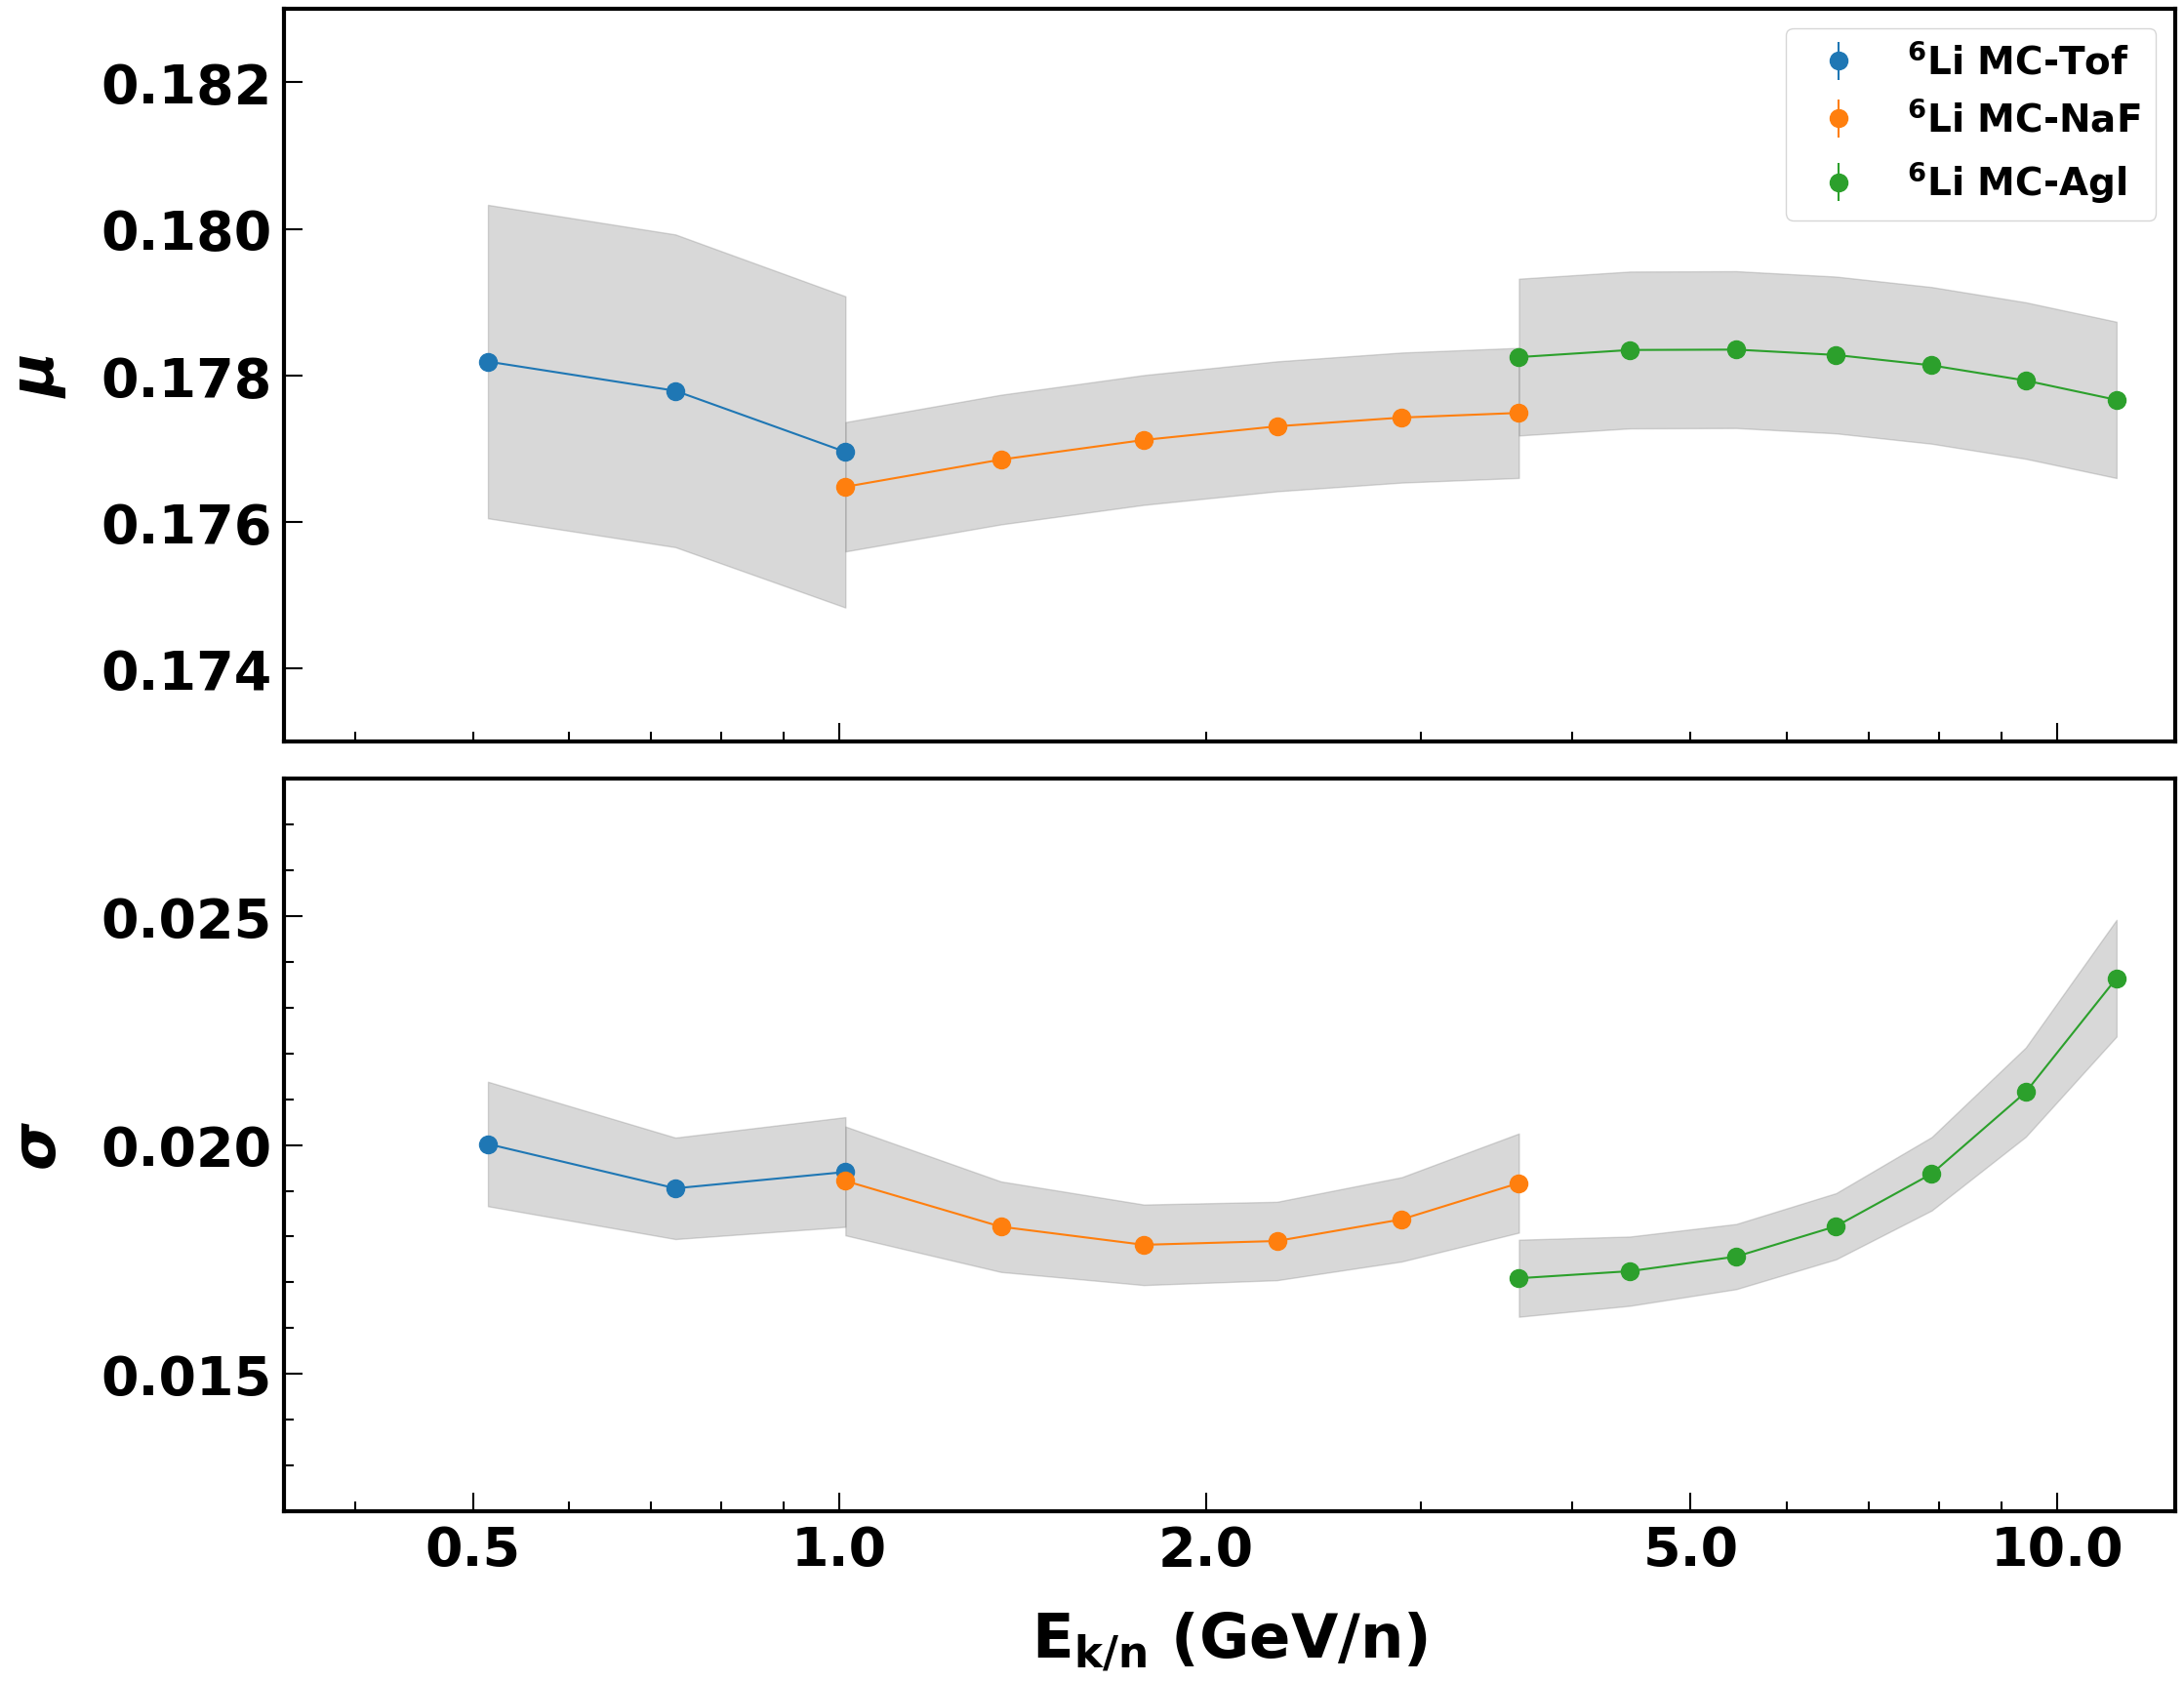

In [7]:
def plot_alldec_par(fig, ax1, key, detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper , subgraph_pars_fitdata, plotdata=False, drawlegend=False ):
    for dec in detectors:
        plot_graph(fig, ax1, graph_guessinit_from_polypar[dec][key], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=26, label=f'{ISO_LABELS["Li6"]} MC-{dec}')  
        plot_graph(fig, ax1, graph_guessinit_from_polypar[dec][key], color=DETECTOR_COLOR[dec],  style="hist", xlog=False, ylog=False, scale=None, markersize=24)  
        ax1.fill_between(graph_guessinit_from_polypar[dec][key].xvalues, graph_pars_lower[dec][key].yvalues, graph_pars_upper[dec][key].yvalues,  color='grey', alpha=0.3)
        if plotdata:
            plot_graph(fig, ax1, subgraph_pars_fitdata[dec][key], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=15, marker='s', label=f'Data {dec}')  
            plot_graph(fig, ax1, subgraph_pars_fitdata[dec][key], color=DETECTOR_COLOR[dec],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, linestyle='--')  
            ax1.fill_between(subgraph_pars_fitdata[dec][key].xvalues, subgraph_pars_fitdata[dec][key].yvalues-subgraph_pars_fitdata[dec][key].yerrs, subgraph_pars_fitdata[dec][key].yvalues+ subgraph_pars_fitdata[dec][key].yerrs,  color='grey', alpha=0.6)
        if drawlegend:
            ax1.legend(fontsize=28)
            
p_pars_mc1236 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitMCMassB1236_Rebin/pvalues_mc7_iter1.npz', allow_pickle=True)  
p_pars_mc1308 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitMassMCB1308_rebin/pvalues_mc7_iter0.npz', allow_pickle=True)  
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1236_rebin_tofparstrict'
dictpar = {}       

dictpar['Tof'] = p_pars_mc1236['Tof'].item()                                                                                                                                         
dictpar['NaF'] = p_pars_mc1236['NaF'].item()   
dictpar['Agl'] = p_pars_mc1236['Agl'].item()   

dictpar2 = {}      

dictpar2['Tof'] = p_pars_mc1308['Tof'].item()                                                                                                                                         
dictpar2['NaF'] = p_pars_mc1308['NaF'].item()   
dictpar2['Agl'] = p_pars_mc1308['Agl'].item()   
xrange = {'Tof': [0.5, 1.3], 'NaF': [1.0, 4.3], 'Agl': [4.0, 12.2]}
xslicerange = {'Tof': [0.5, 1.1], 'NaF': [1.0, 4.0], 'Agl': [4.0, 12.2]}
detectors = ['Tof', 'NaF', 'Agl']
ylim_range = {'mean':        [0.173, 0.183],                                                                                                                                             
              'sigma':       [0.012, 0.028],                                                                                                                                             
              'sigma_ratio': [0.7, 2.4],                                                                                                                                                
              'asy_factor' : [0.84, 1.5],                                                                                                                                                
              'fraccore'   : [0.58, 1.07],                                                                                                                                        
              "norm"       : [0, 40]}

guess_err = '/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertaintymax_BetaRig.pkl'

dict_err = {dec: {} for dec in detectors}
graph_guessinit_from_polypar = {dec: {} for dec in detectors}
graph_guessinit_from_polypar2 = {dec: {} for dec in detectors}
graph_pars_upper = {dec: {} for dec in detectors}
graph_pars_lower = {dec: {} for dec in detectors}
mean_constraint_relativeerr = {'Tof': 0.012, 'NaF': 0.005, 'Agl': 0.006}
graph_pars_fitdata = {dec: {} for dec in detectors}
subgraph_pars_fitdata = {dec: {} for dec in detectors}
with open(f'{guess_err}', 'rb') as file:       
    dictspline_err = pickle.load(file) 
for dec in detectors:
    xbinning = Binning(fbinning_energy_rebin())
    xbin_index = xbinning.get_indices(xrange[dec])
    xbin_centers = xbinning.bin_centers[xbin_index[0]: xbin_index[1]]
    print(xbin_centers)
    spline_err = dictspline_err[dec]   
    for key, value in spline_err.items():
        
        graph_guessinit_from_polypar[dec][key] = MGraph(xbin_centers, poly(np.log(xbin_centers), *dictpar[dec][key]), np.zeros_like(xbin_centers))
        graph_guessinit_from_polypar2[dec][key] = MGraph(xbin_centers, poly(np.log(xbin_centers), *dictpar2[dec][key]), np.zeros_like(xbin_centers))
        
        npzfile = np.load(os.path.join(filename, f'graph_fitpar_{key}.npz'))
        graph_pars_fitdata[dec][key] = MGraph.from_file(npzfile, f'graph_{dec}_{key}')
        subgraph_pars_fitdata[dec][key] = slice_graph_by_value(graph_pars_fitdata[dec][key], xslicerange[dec])
        if key == 'mean':
            dict_err[dec][key] = graph_guessinit_from_polypar[dec][key].yvalues * mean_constraint_relativeerr[dec]
        else:
            dict_err[dec][key] = spline_err[key](np.log(xbin_centers)) *  graph_guessinit_from_polypar[dec][key].yvalues
        
        
        graph_pars_upper[dec][key]= MGraph(xbin_centers, graph_guessinit_from_polypar[dec][key].yvalues + dict_err[dec][key], np.zeros_like(xbin_centers))
        graph_pars_lower[dec][key]= MGraph(xbin_centers, graph_guessinit_from_polypar[dec][key].yvalues - dict_err[dec][key], np.zeros_like(xbin_centers))
        
graph_pars_lower['Tof']['asy_factor'].yvalues[2] *= 0.96
graph_pars_upper['Tof']['asy_factor'].yvalues[2] *= 1.01
subgraph_pars_fitdata['Tof']['mean'].yvalues[2] *= 0.998

xdrawrange = [0.35, 12.5]
#################plot core#############      
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(25, 20))
plot_alldec_par(fig, ax1, 'mean', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata=False, drawlegend=True)
plot_alldec_par(fig, ax2, 'sigma', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata=False)
SetAx1Axis(ax1, '', r'$\mu$', 45, xlimrange=xdrawrange, ylimrange=ylim_range['mean'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= True)
SetAx1Axis(ax2, '', r'$\sigma$', 45, xlimrange=xdrawrange, ylimrange=ylim_range['sigma'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= True)
ax2.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$") 
set_plot_style(ax1)                                                                                                                                                                                 
set_plot_style(ax2)
ax2.set_xticks([0.5, 1, 2, 5, 10])                                                                                                                                                                      
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.subplots_adjust(hspace=.05)
for label in ax1.get_xticklabels():
    label.set_visible(False)
savefig_tofile(fig, plotfile, f"Lithium_MC_coregaus_constraint_Alldec3", show=True)  
#################plot tail#############
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(35, 25))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(22, 22))
ax = [ax1, ax2, ax3]

plot_alldec_par(fig, ax1, 'fraccore', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata=False, drawlegend=True)
plot_alldec_par(fig, ax2, 'sigma_ratio', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata=False)
plot_alldec_par(fig, ax3, 'asy_factor', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata=False)
    
SetAx1Axis(ax1, '', r'$\mathrm{f_{core}}$', 45, xlimrange=xdrawrange, ylimrange=ylim_range['fraccore'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= True)
SetAx1Axis(ax2, '', r'$\epsilon$', 45, xlimrange=xdrawrange, ylimrange=ylim_range['sigma_ratio'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= True)
SetAx1Axis(ax3, '', r'$\alpha$', 45, xlimrange=xdrawrange, ylimrange=ylim_range['asy_factor'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= True)
ax3.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$")                                                                                                                                    
ax1.sharex(ax3)   
for label in ax1.get_xticklabels():
    label.set_visible(False)
# Repeat the process for ax2
for label in ax2.get_xticklabels():
    label.set_visible(False)

set_plot_style(ax1)                                                                                                                                                                                 
set_plot_style(ax2)   
set_plot_style(ax3)   
plt.subplots_adjust(hspace=.05)
ax3.set_xticks([0.5, 1, 2, 5, 10])                                                                                                                                                                      
ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
print(plotfile)
savefig_tofile(fig, plotfile, f"Lithium_MC_tail_constraint_Alldec4", show=True)    



In [8]:
def write_graph_to_txtfile(mgraph, filepath, filename='data'):
    data = np.column_stack((mgraph.xvalues, mgraph.yvalues, mgraph.yerrs))
    np.savetxt(os.path.join(filepath, f'{filename}.csv'), data, delimiter=',', header='x,y,yerr', comments='')
    

[    -inf  0.261    0.338    0.40615  0.49094  0.58761  0.69636  0.82148
  0.95893  1.113    1.2839   1.4714   1.6803   1.9105   2.1621   2.4349
  2.7338   3.0588   3.4096   3.7913   4.2037   4.6468   5.1404   5.6349
  6.1798   6.775    7.4206   8.1166   8.8629   9.6595  10.506   11.454
      inf]
[     -inf  0.2995    0.372075  0.448545  0.539275  0.641985  0.75892
  0.890205  1.035965  1.19845   1.37765   1.57585   1.7954    2.0363
  2.2985    2.58435   2.8963    3.2342    3.60045   3.9975    4.42525
  4.8936    5.38765   5.90735   6.4774    7.0978    7.7686    8.48975
  9.2612   10.08275  10.98           inf]
[4 9]
[0.539275 0.641985 0.75892  0.890205 1.035965]
[    -inf  0.261    0.338    0.40615  0.49094  0.58761  0.69636  0.82148
  0.95893  1.113    1.2839   1.4714   1.6803   1.9105   2.1621   2.4349
  2.7338   3.0588   3.4096   3.7913   4.2037   4.6468   5.1404   5.6349
  6.1798   6.775    7.4206   8.1166   8.8629   9.6595  10.506   11.454
      inf]
[     -inf  0.2995    0.3720

/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)
/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:286: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plot.plot(values_x, values_y, "-", color=color, label=label, **kwargs)


/home/manbing/Documents/Data/data_LiP8/fit_compare
/home/manbing/Documents/Data/data_LiP8/fit_compare
/home/manbing/Documents/Data/data_LiP8/fit_compare


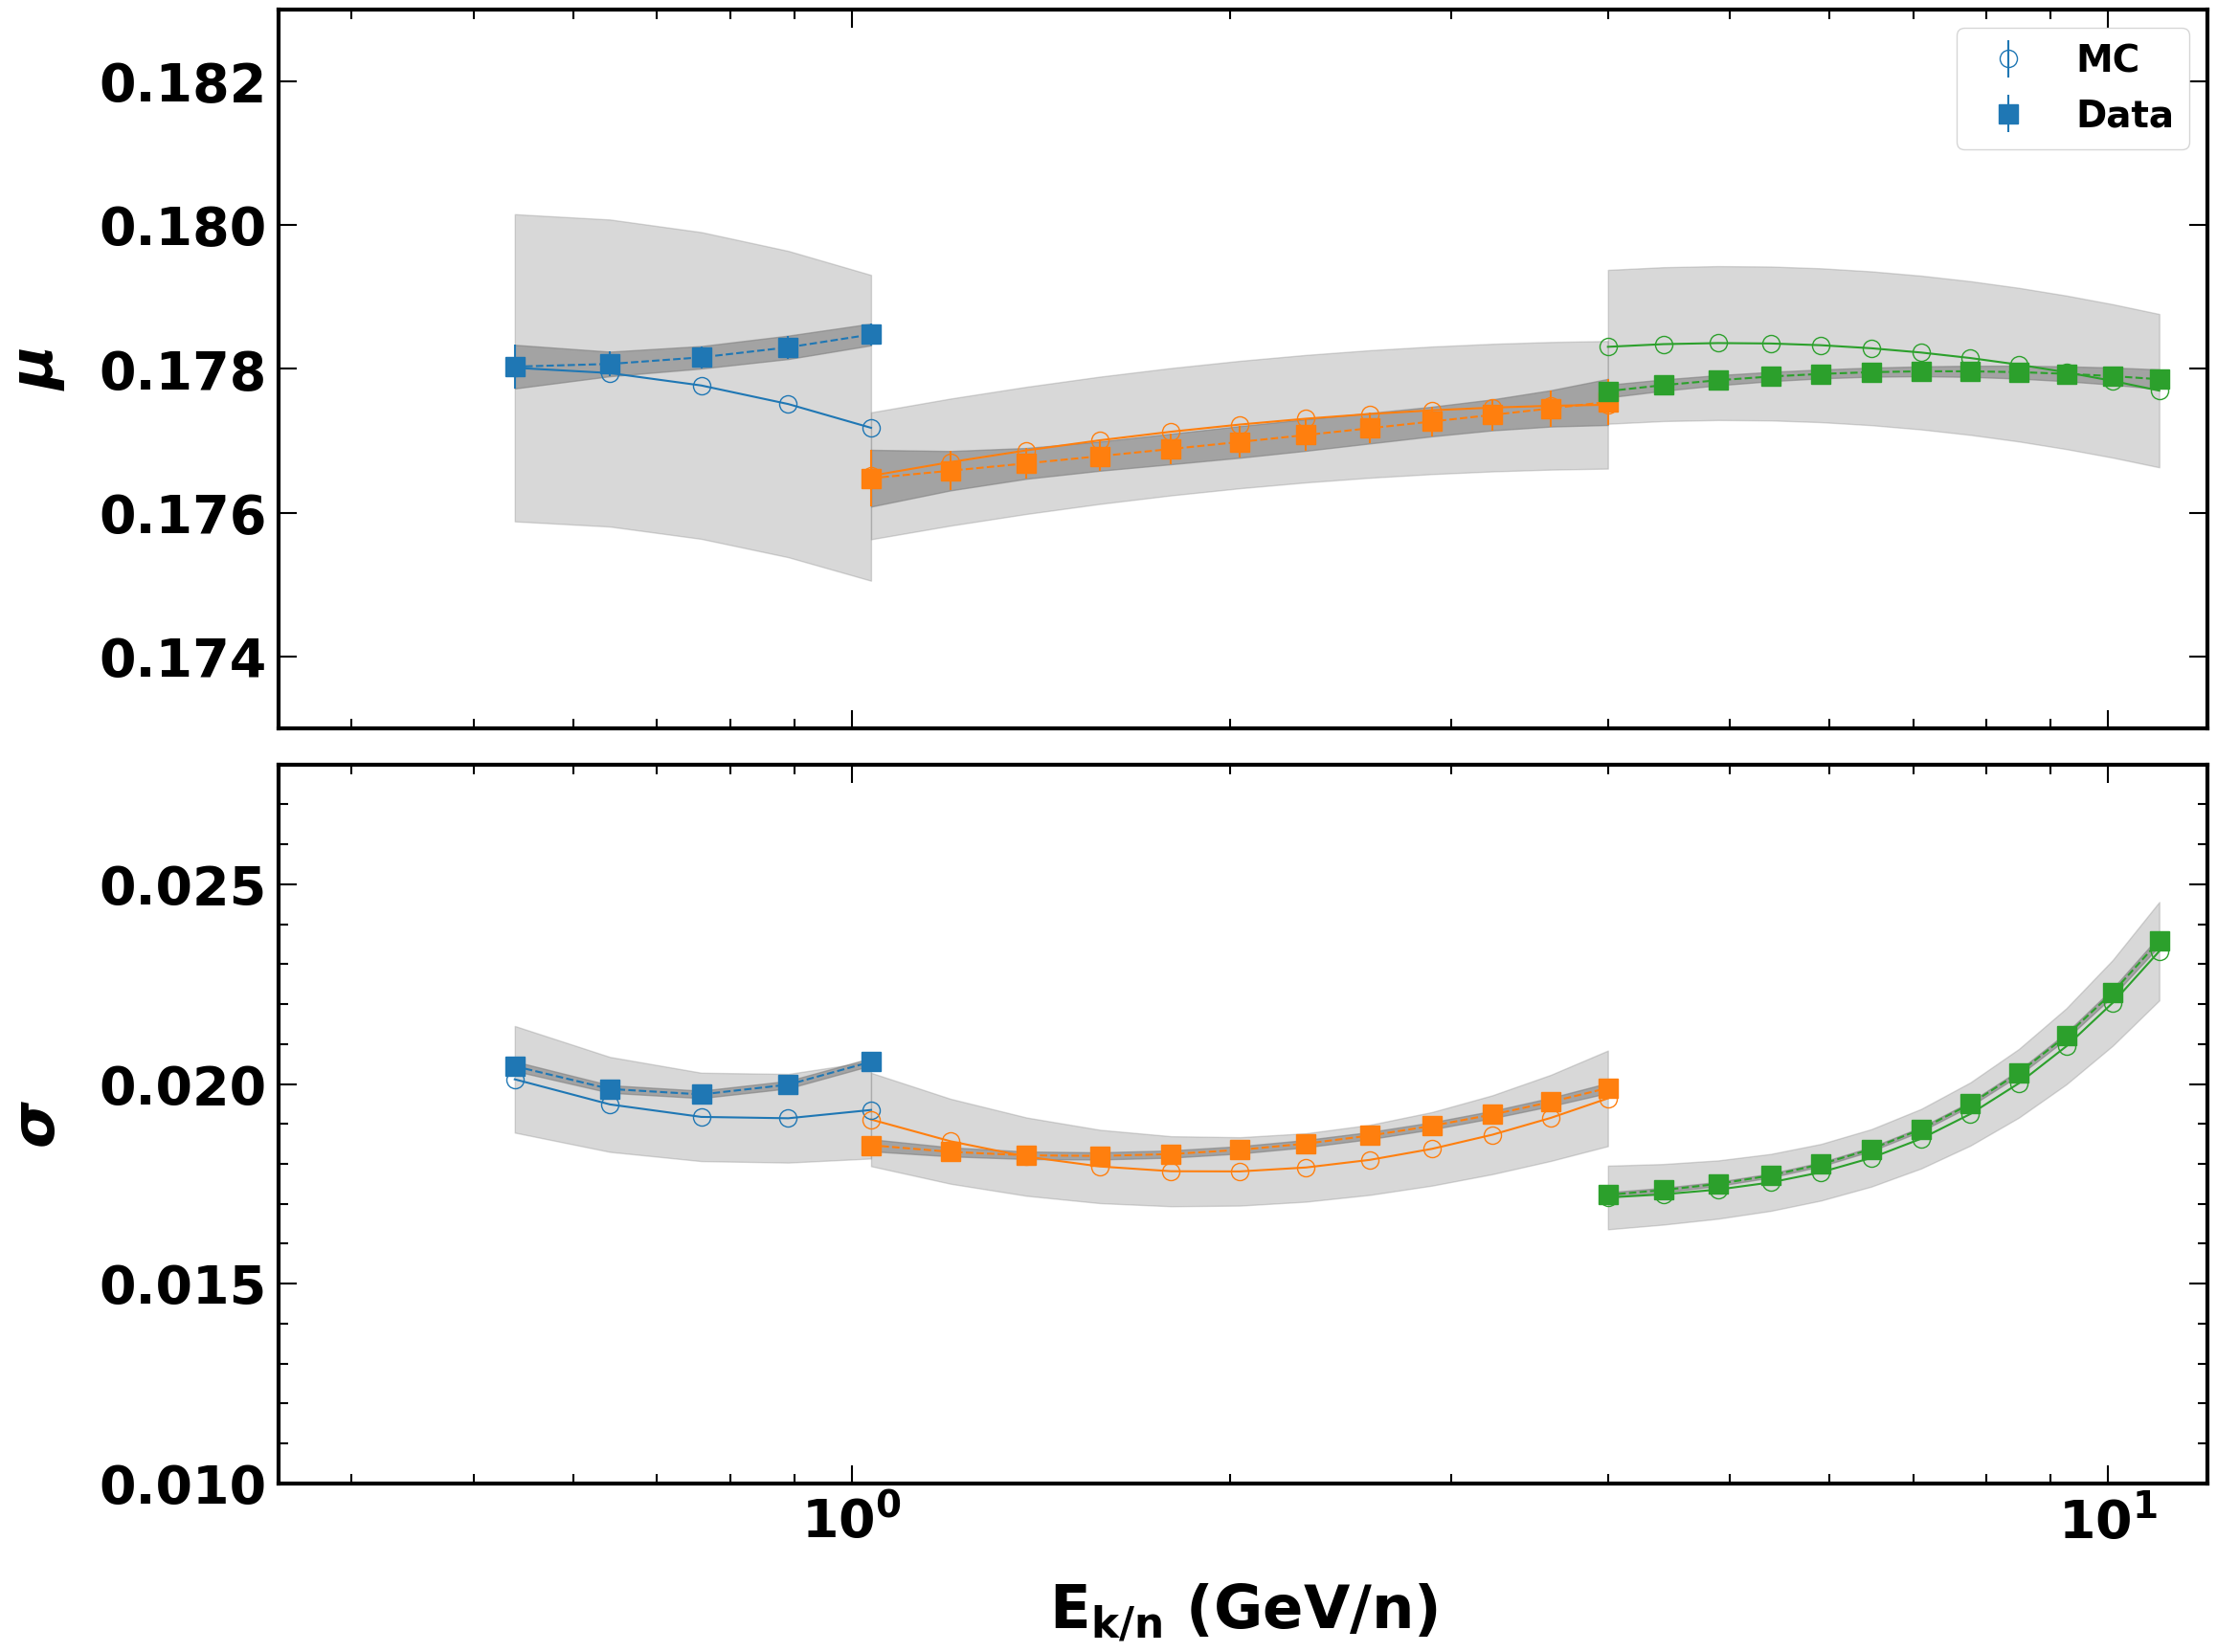

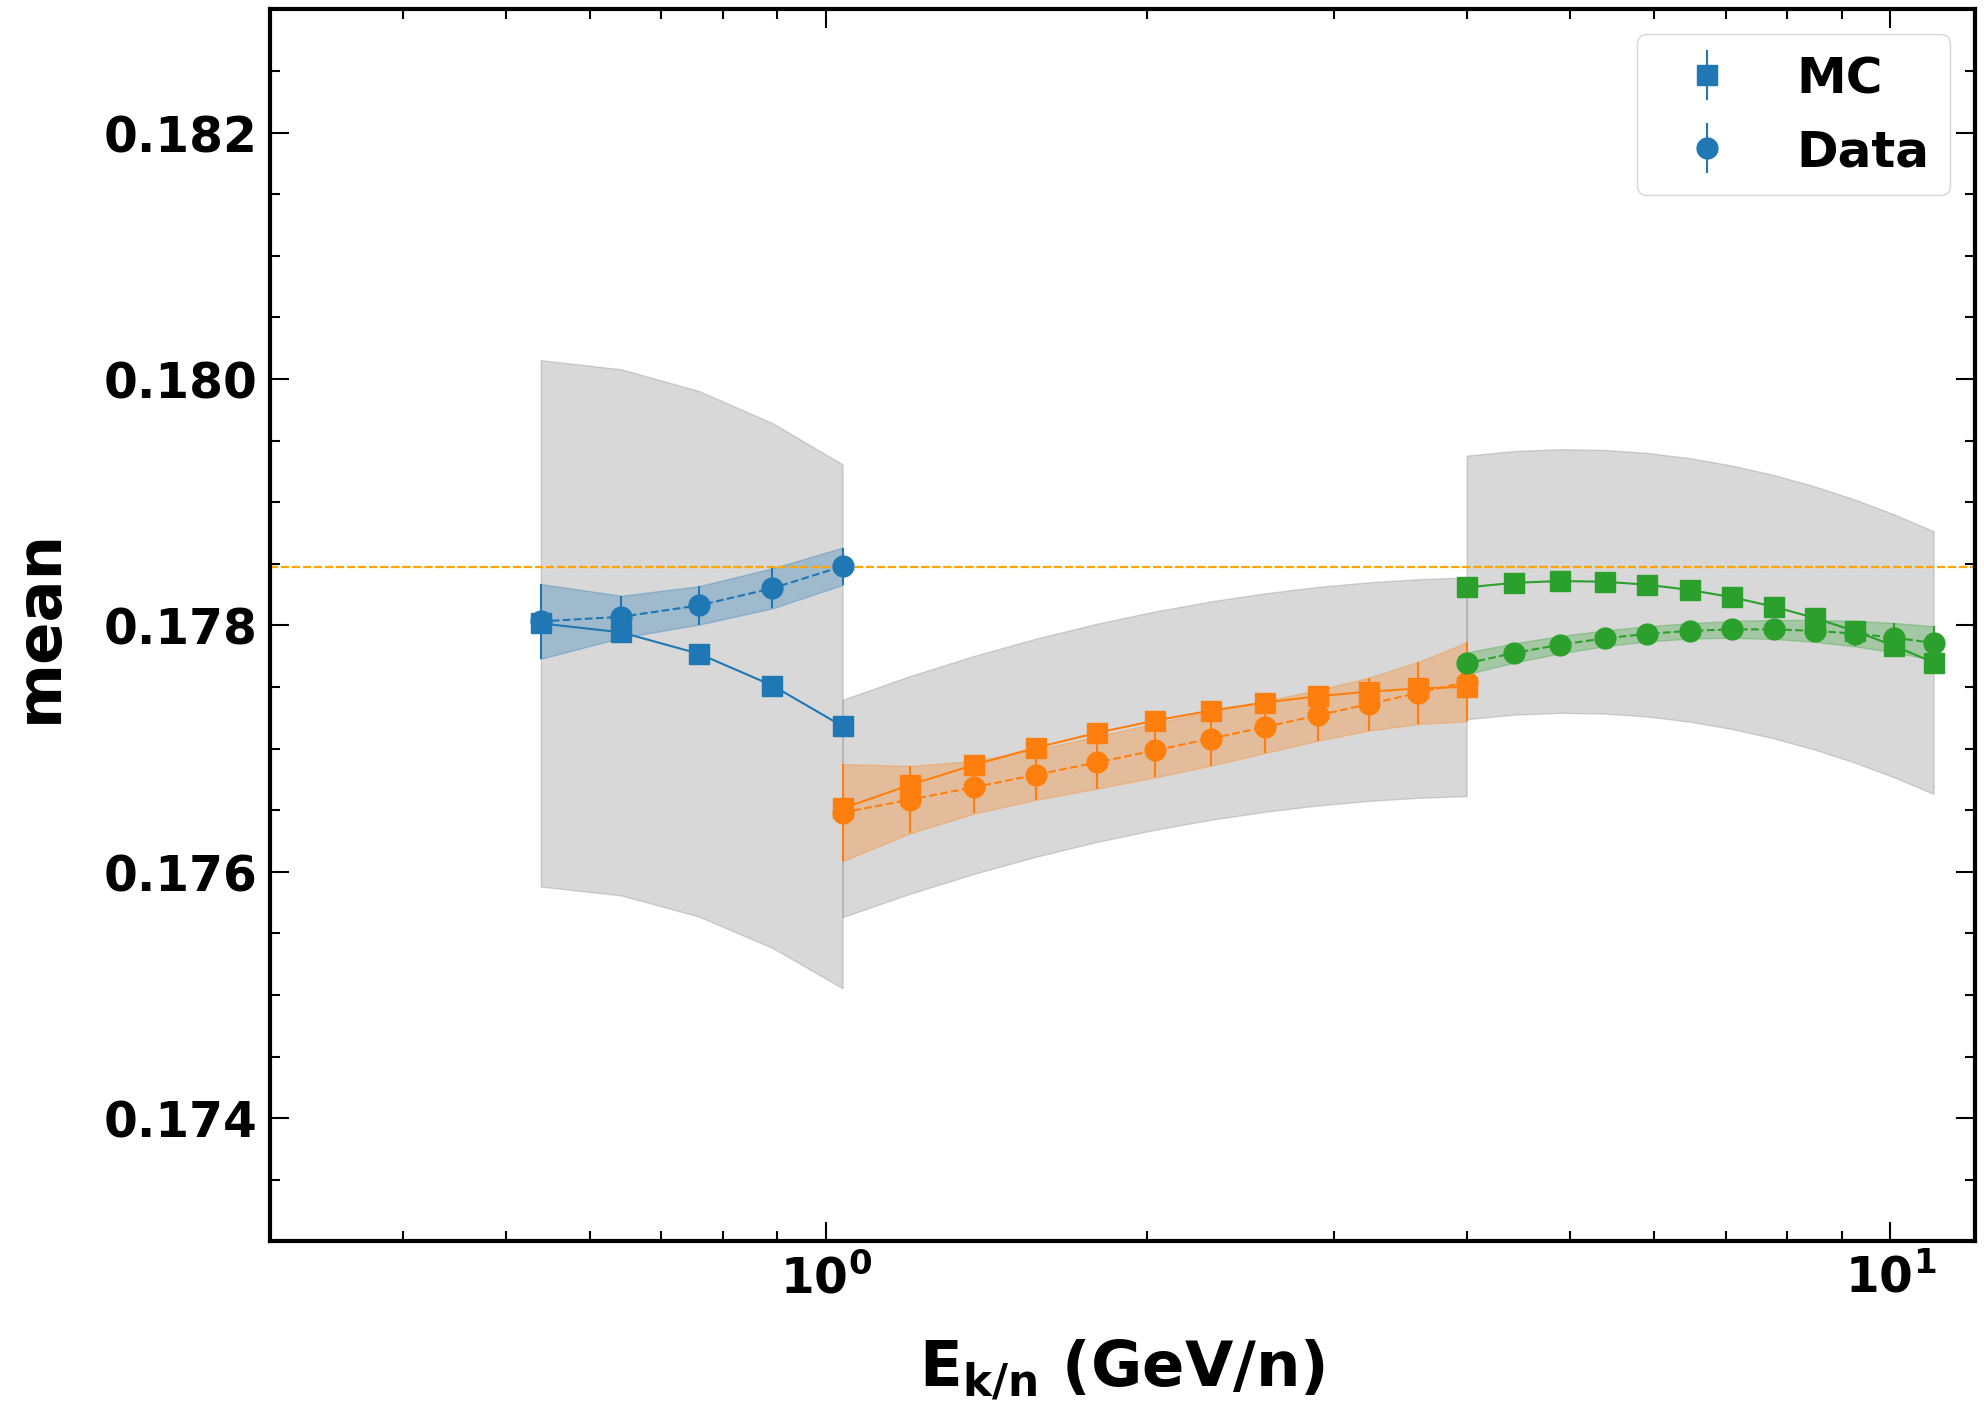

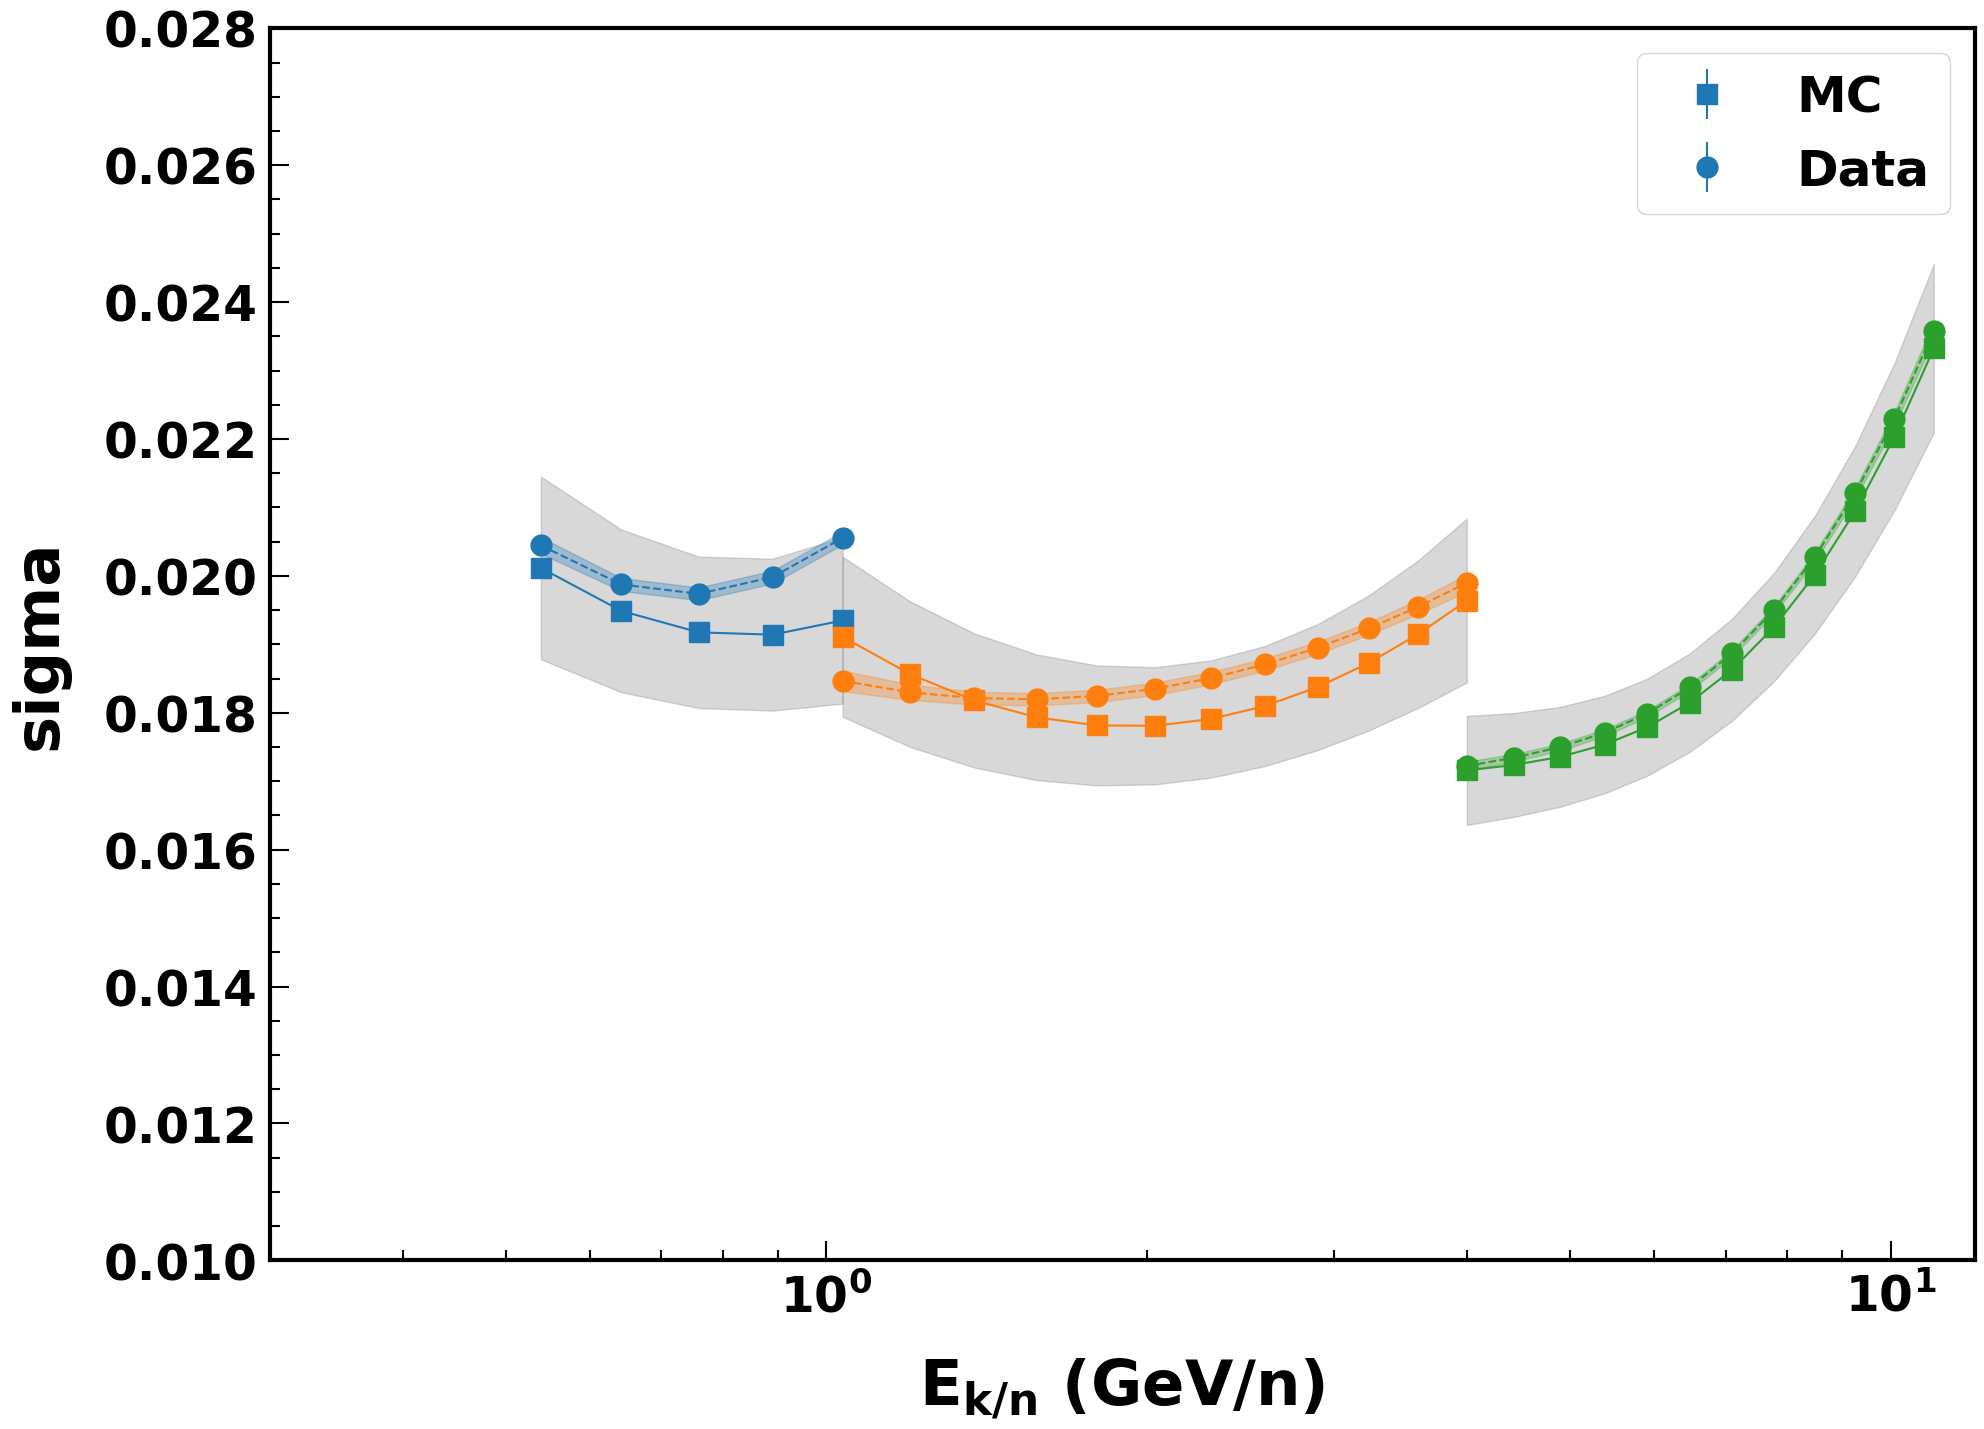

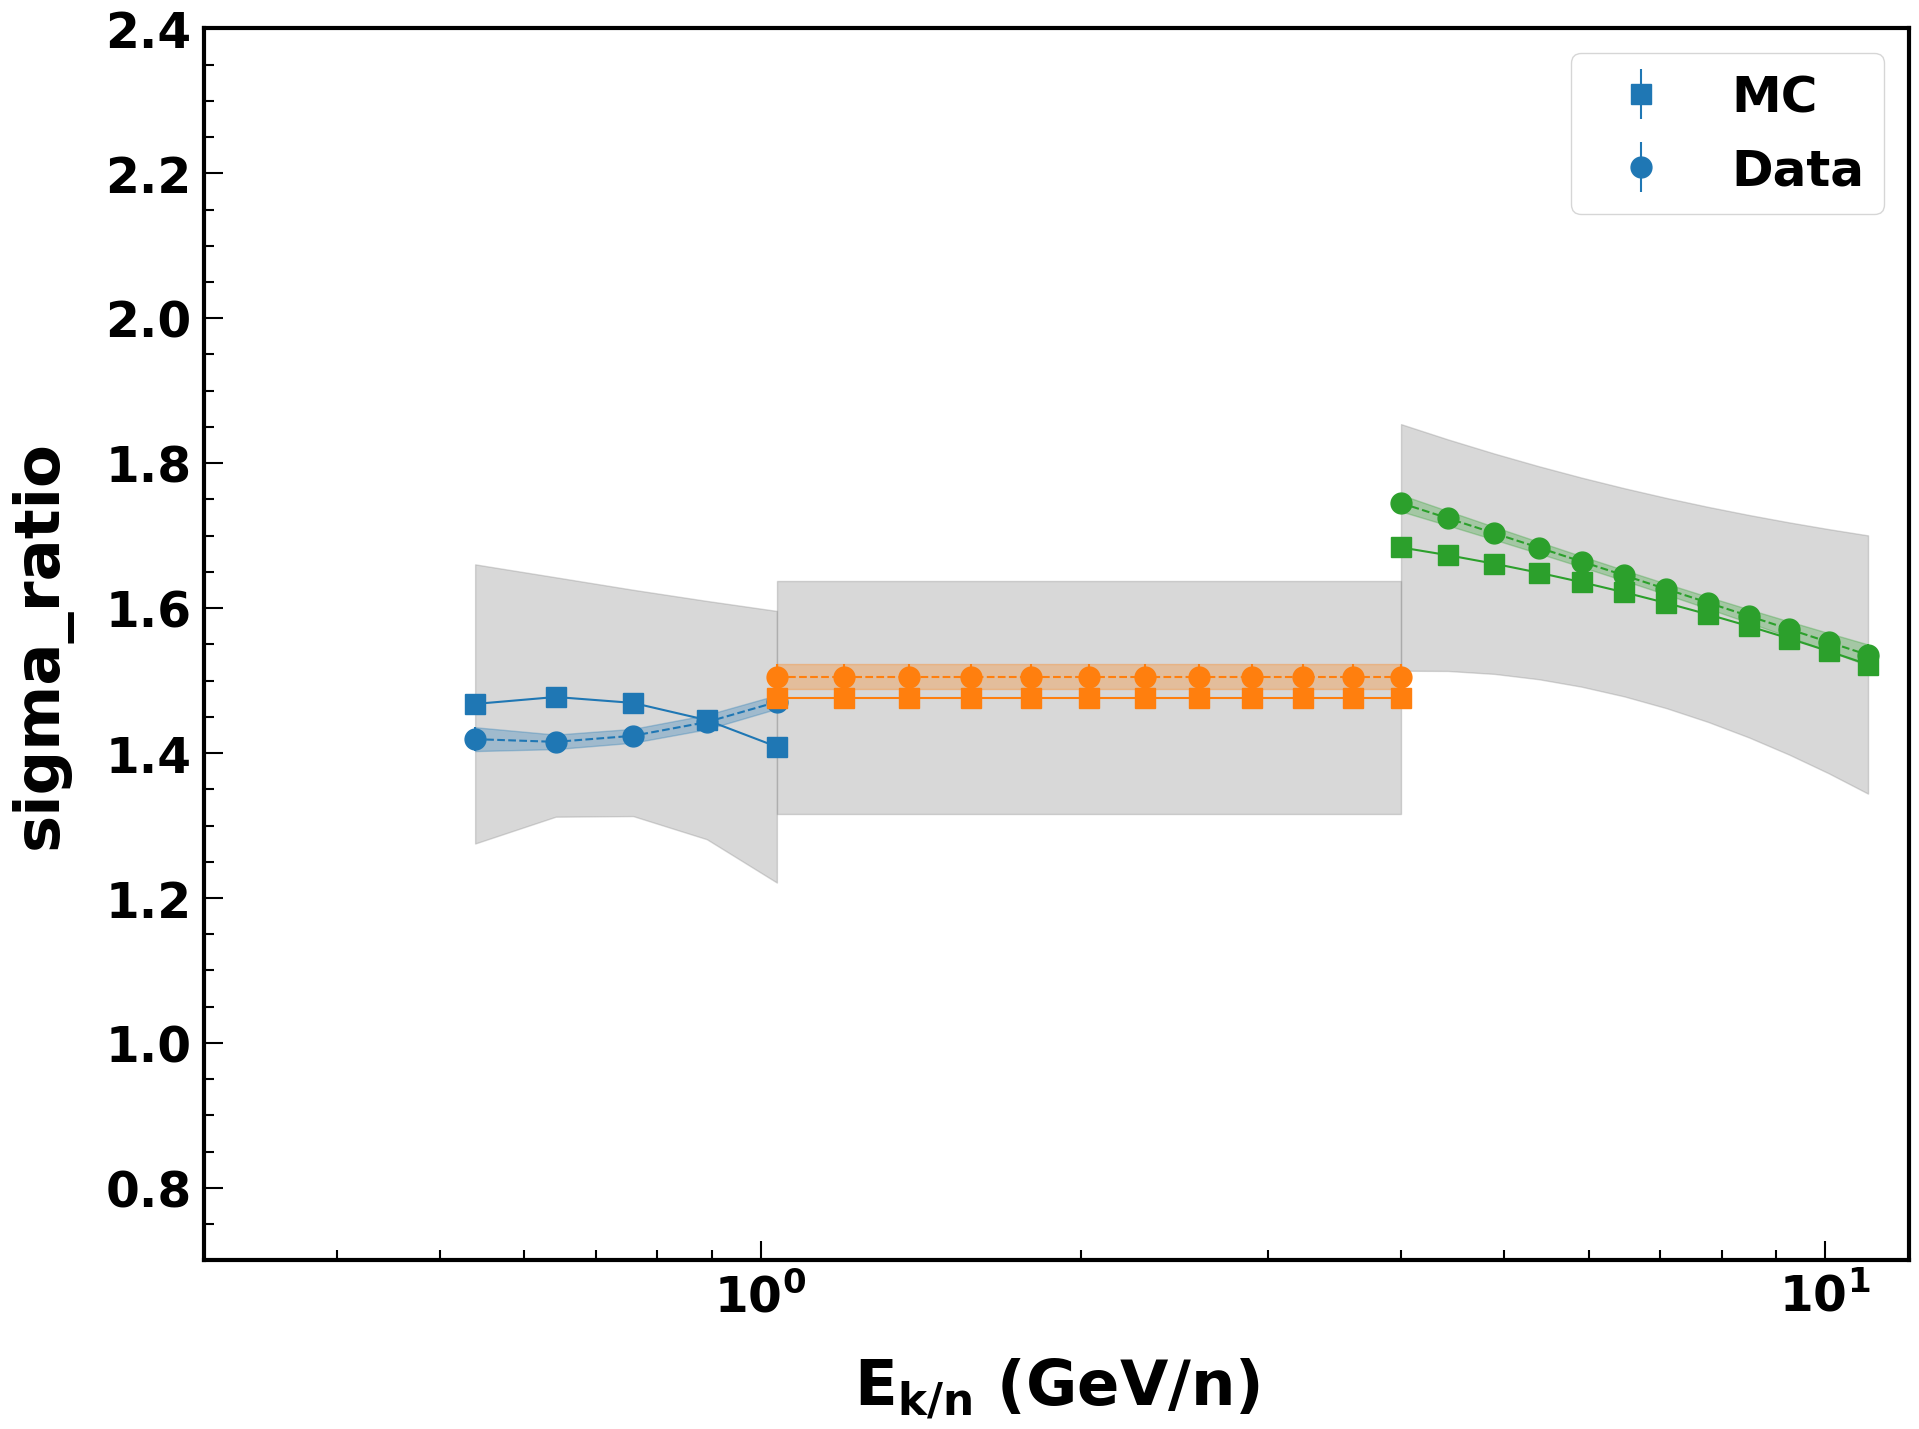

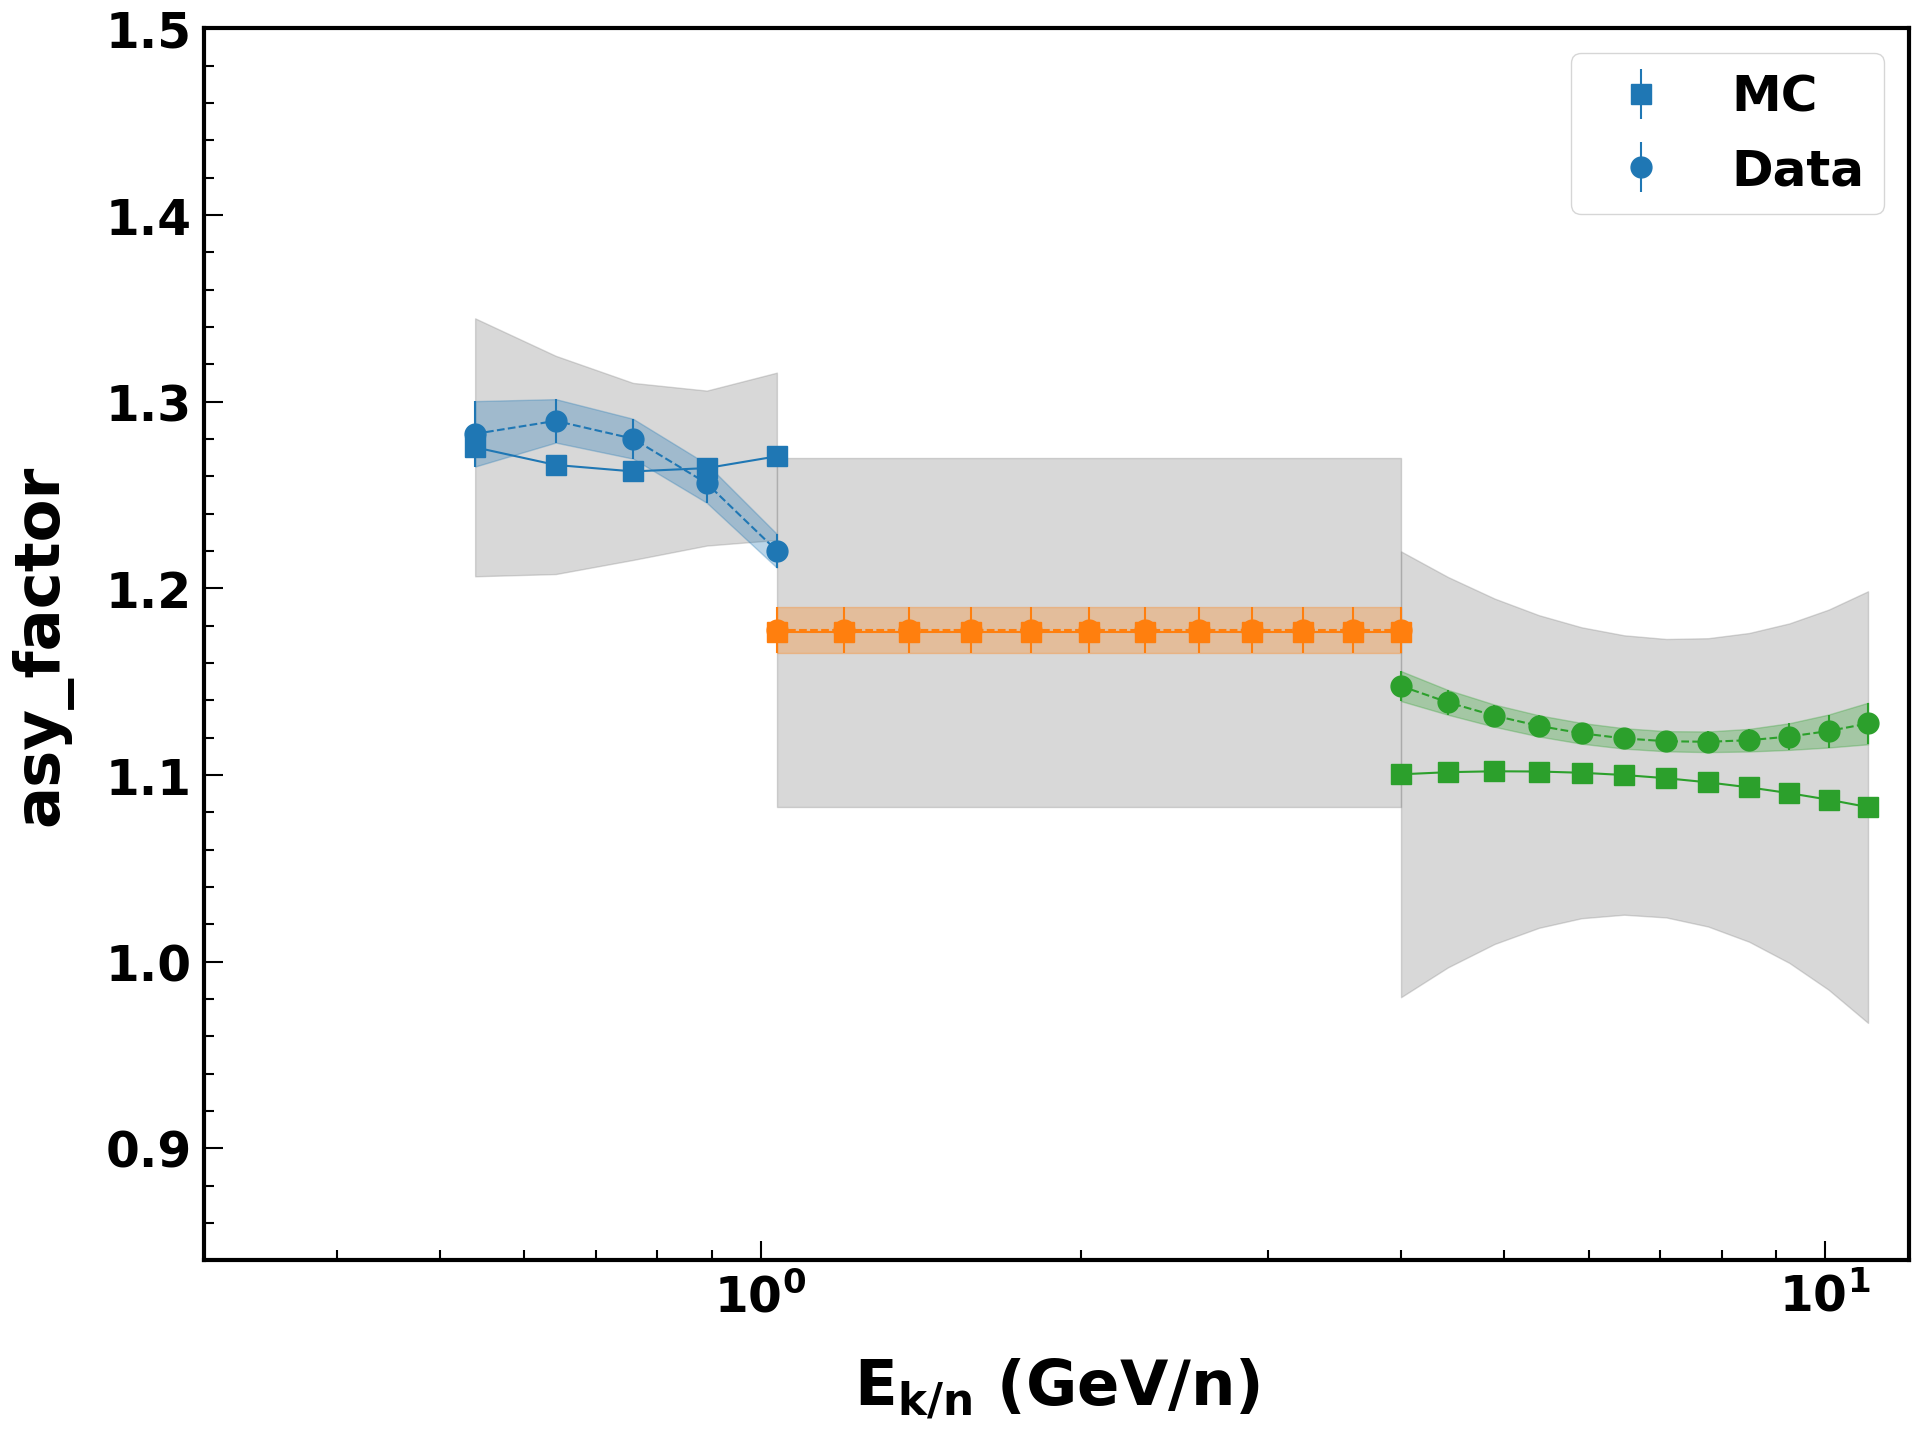

In [9]:
def plot_alldec_par(fig, ax1, key, detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper , subgraph_pars_fitdata, plotdata=False, drawlegend=False ):
    for dec in detectors:
        plot_graph(fig, ax1, graph_guessinit_from_polypar[dec][key], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=26, label=f'MC' if dec == 'Tof' else None, markerfacecolor='none')  
        plot_graph(fig, ax1, graph_guessinit_from_polypar[dec][key], color=DETECTOR_COLOR[dec],  style="hist", xlog=True, ylog=False, scale=None, markersize=24)  
        ax1.fill_between(graph_guessinit_from_polypar[dec][key].xvalues, graph_pars_lower[dec][key].yvalues, graph_pars_upper[dec][key].yvalues,  color='grey', alpha=0.3)
        if plotdata:
            plot_graph(fig, ax1, subgraph_pars_fitdata[dec][key], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=15, marker='s', label=f'Data' if dec == 'Tof' else None)  
            plot_graph(fig, ax1, subgraph_pars_fitdata[dec][key], color=DETECTOR_COLOR[dec],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, linestyle='--')  
            ax1.fill_between(subgraph_pars_fitdata[dec][key].xvalues, subgraph_pars_fitdata[dec][key].yvalues-subgraph_pars_fitdata[dec][key].yerrs, subgraph_pars_fitdata[dec][key].yvalues+ subgraph_pars_fitdata[dec][key].yerrs,  color='grey', alpha=0.6)
        if drawlegend:
            ax1.legend(fontsize=28)
            
p_pars_mc1236 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitMCMassB1236_Rebin/pvalues_mc7_iter1.npz', allow_pickle=True)  
p_pars_mc1308 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitMassMCB1308_finebin/pvalues_mc7_iter1.npz', allow_pickle=True)  
#filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1236_rebin_tofparstrict'
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin'
dictpar = {}       


dictpar['Tof'] = p_pars_mc1308['Tof'].item()                                                                                                                                         
dictpar['NaF'] = p_pars_mc1236['NaF'].item()   
dictpar['Agl'] = p_pars_mc1236['Agl'].item()   

dictpar2 = {}      

dictpar2['Tof'] = p_pars_mc1308['Tof'].item()                                                                                                                                         
dictpar2['NaF'] = p_pars_mc1308['NaF'].item()   
dictpar2['Agl'] = p_pars_mc1308['Agl'].item()   
xrange = {'Tof': [0.5, 1.2], 'NaF': [1.0, 4.5], 'Agl': [4.0, 11.5]}
xslicerange = {'Tof': [0.5, 1.1], 'NaF': [0.9, 4.2], 'Agl': [4.0, 12.2]}
detectors = ['Tof', 'NaF', 'Agl']
ylim_range = {'mean':        [0.173, 0.183],                                                                                                                                             
              'sigma':       [0.01, 0.028],                                                                                                                                             
              'sigma_ratio': [0.7, 2.4],                                                                                                                                                
              'asy_factor' : [0.84, 1.5],                                                                                                                                                
              'fraccore'   : [0.6, 1.02],                                                                                                                                        
              "norm"       : [0, 40]}

guess_err = '/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertaintymax_BetaRig.pkl'

dict_err = {dec: {} for dec in detectors}
graph_guessinit_from_polypar = {dec: {} for dec in detectors}
graph_guessinit_from_polypar2 = {dec: {} for dec in detectors}
graph_pars_upper = {dec: {} for dec in detectors}
graph_pars_lower = {dec: {} for dec in detectors}
mean_constraint_relativeerr = {'Tof': 0.012, 'NaF': 0.005, 'Agl': 0.006}
graph_pars_fitdata = {dec: {} for dec in detectors}
subgraph_pars_fitdata = {dec: {} for dec in detectors}
with open(f'{guess_err}', 'rb') as file:       
    dictspline_err = pickle.load(file) 
for dec in detectors:
    xbinning = Binning(fbinning_energy_Li())
    xbin_index = xbinning.get_indices(xrange[dec])
    print(xbinning.edges)
    print(xbinning.bin_centers)
    print(xbin_index)
    xbin_centers = xbinning.bin_centers[xbin_index[0]: xbin_index[1]]
    print(xbin_centers)
    spline_err = dictspline_err[dec]   
    for key, value in spline_err.items():
        
        graph_guessinit_from_polypar[dec][key] = MGraph(xbin_centers, poly(np.log(xbin_centers), *dictpar[dec][key]), np.zeros_like(xbin_centers))
        graph_guessinit_from_polypar2[dec][key] = MGraph(xbin_centers, poly(np.log(xbin_centers), *dictpar2[dec][key]), np.zeros_like(xbin_centers))
        
        npzfile = np.load(os.path.join(filename, f'graph_fitpar_{key}.npz'))
        graph_pars_fitdata[dec][key] = MGraph.from_file(npzfile, f'graph_{dec}_{key}')
        subgraph_pars_fitdata[dec][key] = slice_graph_by_value(graph_pars_fitdata[dec][key], xslicerange[dec])
        if key == 'mean':
            dict_err[dec][key] = graph_guessinit_from_polypar[dec][key].yvalues * mean_constraint_relativeerr[dec]
        else:
            dict_err[dec][key] = spline_err[key](np.log(xbin_centers)) *  graph_guessinit_from_polypar[dec][key].yvalues
        
        
        graph_pars_upper[dec][key]= MGraph(xbin_centers, graph_guessinit_from_polypar[dec][key].yvalues + dict_err[dec][key], np.zeros_like(xbin_centers))
        graph_pars_lower[dec][key]= MGraph(xbin_centers, graph_guessinit_from_polypar[dec][key].yvalues - dict_err[dec][key], np.zeros_like(xbin_centers))
        


#################plot core#############      
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(26, 20))
plot_alldec_par(fig, ax1, 'mean', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata= True, drawlegend=True)
plot_alldec_par(fig, ax2, 'sigma', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata= True)
SetAx1Axis(ax1, '', r'$\mu$', 45, xlimrange=[0.35, 12], ylimrange=ylim_range['mean'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
SetAx1Axis(ax2, '', r'$\sigma$', 45, xlimrange=[0.35, 12], ylimrange=ylim_range['sigma'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
ax2.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$") 
set_plot_style(ax1)                                                                                                                                                                                 
set_plot_style(ax2)
plt.subplots_adjust(hspace=.05)
for label in ax1.get_xticklabels():
    label.set_visible(False)
savefig_tofile(fig, plotfile, f"lithium_pars_core_datamc3", show=True) 
    
#################plot tail#############
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(35, 25))
ax = [ax1, ax2, ax3]

plot_alldec_par(fig, ax1, 'fraccore', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata= True, drawlegend=True)
plot_alldec_par(fig, ax2, 'sigma_ratio', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata=True)
plot_alldec_par(fig, ax3, 'asy_factor', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata=True)
    
SetAx1Axis(ax1, '', r'$\mathrm{f_{core}}$', 45, xlimrange=[0.35, 12], ylimrange=ylim_range['fraccore'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
SetAx1Axis(ax2, '', r'$\epsilon$', 45, xlimrange=[0.35, 12], ylimrange=ylim_range['sigma_ratio'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
SetAx1Axis(ax3, '', r'$\alpha$', 45, xlimrange=[0.35, 12], ylimrange=ylim_range['asy_factor'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
ax3.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$")                                                                                                                                    
ax1.sharex(ax3)   
for label in ax1.get_xticklabels():
    label.set_visible(False)
# Repeat the process for ax2
for label in ax2.get_xticklabels():
    label.set_visible(False)

set_plot_style(ax1)                                                                                                                                                                                 
set_plot_style(ax2)   
set_plot_style(ax3)   
plt.subplots_adjust(hspace=.05)
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin_untuned'
savefig_tofile(fig, plotdir, f"lithium_pars_tail_datamc3", show=True)    



for key, value in spline_err.items():  
    fig, ax1 = plt.subplots(1, 1, figsize= FIGSIZE3)
    set_plot_style(ax1)
    for dec in detectors:
        ax1.axhline(y=1/ISOTOPES_MASS['Li6'], color='orange', linestyle='--') 
        plot_graph(fig, ax1, graph_guessinit_from_polypar[dec][key], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=15, label=f'MC' if dec == 'Tof' else None, marker='s')  
        plot_graph(fig, ax1, subgraph_pars_fitdata[dec][key], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=30, label=f'Data' if dec == 'Tof' else None)  
        plot_graph(fig, ax1, subgraph_pars_fitdata[dec][key], color=DETECTOR_COLOR[dec],  style="hist", xlog=True, ylog=False, scale=None, markersize=30, label='', linestyle='--')  
        plot_graph(fig, ax1, graph_guessinit_from_polypar[dec][key], color=DETECTOR_COLOR[dec],  style="hist", xlog=True, ylog=False, scale=None, markersize=30, label=f'')  
        #plot_graph(fig, ax1, graph_guessinit_from_polypar2[dec][key], color='black',  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{key}')  
        ax1.fill_between(graph_guessinit_from_polypar[dec][key].xvalues, graph_pars_lower[dec][key].yvalues, graph_pars_upper[dec][key].yvalues,  color='grey', alpha=0.3)
        ax1.fill_between(subgraph_pars_fitdata[dec][key].xvalues, subgraph_pars_fitdata[dec][key].yvalues-subgraph_pars_fitdata[dec][key].yerrs, subgraph_pars_fitdata[dec][key].yvalues+ subgraph_pars_fitdata[dec][key].yerrs,  color=DETECTOR_COLOR[dec], alpha=0.3)
        SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', f'{key}', 45, xlimrange=[0.3, 12], ylimrange=ylim_range[key] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
        datapath = '/home/manbing/Documents/Data/data_LiP8/fit_compare'
        
        if key == 'mean':
            print(datapath)
            write_graph_to_txtfile(subgraph_pars_fitdata[dec][key], datapath, filename=f'LiFitdata{dec}_{key}')
            write_graph_to_txtfile(graph_guessinit_from_polypar[dec][key], datapath, filename=f'LiFitMC{dec}_{key}')
            write_graph_to_txtfile(subgraph_pars_fitdata[dec][key]/graph_guessinit_from_polypar[dec][key], datapath, filename=f'LiDataMCRatio{dec}_{key}')
            savefig_tofile(fig, plotdir, f"lithium_pars_mean_datamc", show=True)
    ax1.legend()

In [10]:
def plot_alldec_par(fig, ax1, key, detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper , subgraph_pars_fitdata, plotdata=False, drawlegend=False ):
    for dec in detectors:
        plot_graph(fig, ax1, graph_guessinit_from_polypar[dec][key], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=26, label=f'MC' if dec == 'Tof' else None, markerfacecolor='none')  
        plot_graph(fig, ax1, graph_guessinit_from_polypar[dec][key], color=DETECTOR_COLOR[dec],  style="hist", xlog=True, ylog=False, scale=None, markersize=24)  
        ax1.fill_between(graph_guessinit_from_polypar[dec][key].xvalues, graph_pars_lower[dec][key].yvalues, graph_pars_upper[dec][key].yvalues,  color='grey', alpha=0.3)
        if plotdata:
            plot_graph(fig, ax1, subgraph_pars_fitdata[dec][key], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=15, marker='s', label=f'Data' if dec == 'Tof' else None)  
            plot_graph(fig, ax1, subgraph_pars_fitdata[dec][key], color=DETECTOR_COLOR[dec],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, linestyle='--')  
            ax1.fill_between(subgraph_pars_fitdata[dec][key].xvalues, subgraph_pars_fitdata[dec][key].yvalues-subgraph_pars_fitdata[dec][key].yerrs, subgraph_pars_fitdata[dec][key].yvalues+ subgraph_pars_fitdata[dec][key].yerrs,  color='grey', alpha=0.6)
        if drawlegend:
            ax1.legend(fontsize=28)
            
p_pars_mc1236 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitMCMassB1236_Rebin/pvalues_mc7_iter1.npz', allow_pickle=True)  
p_pars_mc1308 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitMassMCB1308_untunedBeta_TofV3/pvalues_mc7_iter1.npz', allow_pickle=True)  
#filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1236_rebin_tofparstrict'
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin_ShiftToF_WithToFEdge_11May_NotConstraintNTotal'
dictpar = {}       


dictpar['Tof'] = p_pars_mc1308['Tof'].item()                                                                                                                                         
dictpar['NaF'] = p_pars_mc1308['NaF'].item()   
dictpar['Agl'] = p_pars_mc1308['Agl'].item()   

dictpar2 = {}      

dictpar2['Tof'] = p_pars_mc1308['Tof'].item()                                                                                                                                         
dictpar2['NaF'] = p_pars_mc1308['NaF'].item()   
dictpar2['Agl'] = p_pars_mc1308['Agl'].item()   
xrange = {'Tof': [0.45, 0.9], 'NaF': [0.9, 5.7], 'Agl': [4.0, 11.5]}
xslicerange = {'Tof': [0.4, 0.8], 'NaF': [0.9, 5.4], 'Agl': [4.0, 12.2]}
detectors = ['Tof', 'NaF', 'Agl']
ylim_range = {'mean':        [0.173, 0.183],                                                                                                                                             
              'sigma':       [0.01, 0.028],                                                                                                                                             
              'sigma_ratio': [0.7, 3.0],                                                                                                                                                
              'asy_factor' : [0.84, 1.5],                                                                                                                                                
              'fraccore'   : [0.6, 1.02],                                                                                                                                        
              "norm"       : [0, 40]}

guess_err = '/home/manbing/Documents/Data/data_BeP8/FitParsRange/splines_pars_uncertaintymax_BetaRig.pkl'

dict_err = {dec: {} for dec in detectors}
graph_guessinit_from_polypar = {dec: {} for dec in detectors}
graph_guessinit_from_polypar2 = {dec: {} for dec in detectors}
graph_pars_upper = {dec: {} for dec in detectors}
graph_pars_lower = {dec: {} for dec in detectors}
mean_constraint_relativeerr = {'Tof': 0.012, 'NaF': 0.005, 'Agl': 0.006}
graph_pars_fitdata = {dec: {} for dec in detectors}
subgraph_pars_fitdata = {dec: {} for dec in detectors}
with open(f'{guess_err}', 'rb') as file:       
    dictspline_err = pickle.load(file) 
for dec in detectors:
    xbinning = Binning(fbinning_energy_Li())
    xbin_index = xbinning.get_indices(xrange[dec])
    print(xbinning.edges)
    print(xbinning.bin_centers)
    print(xbin_index)
    xbin_centers = xbinning.bin_centers[xbin_index[0]: xbin_index[1]]
    print(xbin_centers)
    spline_err = dictspline_err[dec]   
    for key, value in spline_err.items():
        
        graph_guessinit_from_polypar[dec][key] = MGraph(xbin_centers, poly(np.log(xbin_centers), *dictpar[dec][key]), np.zeros_like(xbin_centers))
        graph_guessinit_from_polypar2[dec][key] = MGraph(xbin_centers, poly(np.log(xbin_centers), *dictpar2[dec][key]), np.zeros_like(xbin_centers))
        
        npzfile = np.load(os.path.join(filename, f'graph_fitpar_{key}.npz'))
        graph_pars_fitdata[dec][key] = MGraph.from_file(npzfile, f'graph_{dec}_{key}')
        subgraph_pars_fitdata[dec][key] = slice_graph_by_value(graph_pars_fitdata[dec][key], xslicerange[dec])
        if key == 'mean':
            dict_err[dec][key] = graph_guessinit_from_polypar[dec][key].yvalues * mean_constraint_relativeerr[dec]
        else:
            dict_err[dec][key] = spline_err[key](np.log(xbin_centers)) *  graph_guessinit_from_polypar[dec][key].yvalues
        
        
        graph_pars_upper[dec][key]= MGraph(xbin_centers, graph_guessinit_from_polypar[dec][key].yvalues + dict_err[dec][key], np.zeros_like(xbin_centers))
        graph_pars_lower[dec][key]= MGraph(xbin_centers, graph_guessinit_from_polypar[dec][key].yvalues - dict_err[dec][key], np.zeros_like(xbin_centers))


#################plot core#############      
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(26, 20))
plot_alldec_par(fig, ax1, 'mean', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata= True, drawlegend=True)
plot_alldec_par(fig, ax2, 'sigma', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata= True)
SetAx1Axis(ax1, '', r'$\mu$', 45, xlimrange=[0.35, 12], ylimrange=ylim_range['mean'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
SetAx1Axis(ax2, '', r'$\sigma$', 45, xlimrange=[0.35, 12], ylimrange=ylim_range['sigma'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
ax2.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$") 
set_plot_style(ax1)                                                                                                                                                                                 
set_plot_style(ax2)
plt.subplots_adjust(hspace=.05)
for label in ax1.get_xticklabels():
    label.set_visible(False)
savefig_tofile(fig, plotfile, f"lithium_pars_core_datamc3", show=True) 
    
#################plot tail#############
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(35, 25))
ax = [ax1, ax2, ax3]

plot_alldec_par(fig, ax1, 'fraccore', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata= True, drawlegend=True)
plot_alldec_par(fig, ax2, 'sigma_ratio', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata=True)
plot_alldec_par(fig, ax3, 'asy_factor', detectors, graph_guessinit_from_polypar,graph_pars_lower,graph_pars_upper, subgraph_pars_fitdata, plotdata=True)
    
SetAx1Axis(ax1, '', r'$\mathrm{f_{core}}$', 45, xlimrange=[0.35, 12], ylimrange=ylim_range['fraccore'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
SetAx1Axis(ax2, '', r'$\epsilon$', 45, xlimrange=[0.35, 12], ylimrange=ylim_range['sigma_ratio'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
SetAx1Axis(ax3, '', r'$\alpha$', 45, xlimrange=[0.35, 12], ylimrange=ylim_range['asy_factor'] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
ax3.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$")                                                                                                                                    
ax1.sharex(ax3)   
for label in ax1.get_xticklabels():
    label.set_visible(False)
# Repeat the process for ax2
for label in ax2.get_xticklabels():
    label.set_visible(False)

set_plot_style(ax1)                                                                                                                                                                                 
set_plot_style(ax2)   
set_plot_style(ax3)   
plt.subplots_adjust(hspace=.05)
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin_untuned'
savefig_tofile(fig, plotdir, f"lithium_pars_tail_datamc3", show=True)    



for key, value in spline_err.items():  
    fig, ax1 = plt.subplots(1, 1, figsize= FIGSIZE3)
    set_plot_style(ax1)
    for dec in detectors:
        ax1.axhline(y=1/ISOTOPES_MASS['Li6'], color='orange', linestyle='--') 
        plot_graph(fig, ax1, graph_guessinit_from_polypar[dec][key], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=15, label=f'MC' if dec == 'Tof' else None, marker='s')  
        plot_graph(fig, ax1, subgraph_pars_fitdata[dec][key], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=30, label=f'Data' if dec == 'Tof' else None)  
        plot_graph(fig, ax1, subgraph_pars_fitdata[dec][key], color=DETECTOR_COLOR[dec],  style="hist", xlog=True, ylog=False, scale=None, markersize=30, label='', linestyle='--')  
        plot_graph(fig, ax1, graph_guessinit_from_polypar[dec][key], color=DETECTOR_COLOR[dec],  style="hist", xlog=True, ylog=False, scale=None, markersize=30, label=f'')  
        #plot_graph(fig, ax1, graph_guessinit_from_polypar2[dec][key], color='black',  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{key}')  
        ax1.fill_between(graph_guessinit_from_polypar[dec][key].xvalues, graph_pars_lower[dec][key].yvalues, graph_pars_upper[dec][key].yvalues,  color='grey', alpha=0.3)
        ax1.fill_between(subgraph_pars_fitdata[dec][key].xvalues, subgraph_pars_fitdata[dec][key].yvalues-subgraph_pars_fitdata[dec][key].yerrs, subgraph_pars_fitdata[dec][key].yvalues+ subgraph_pars_fitdata[dec][key].yerrs,  color=DETECTOR_COLOR[dec], alpha=0.3)
        SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', f'{key}', 45, xlimrange=[0.3, 12], ylimrange=ylim_range[key] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
        datapath = '/home/manbing/Documents/Data/data_LiP8/fit_compare'
        
        if key == 'mean':
            print(datapath)
            write_graph_to_txtfile(subgraph_pars_fitdata[dec][key], datapath, filename=f'LiFitdata{dec}_{key}')
            write_graph_to_txtfile(graph_guessinit_from_polypar[dec][key], datapath, filename=f'LiFitMC{dec}_{key}')
            write_graph_to_txtfile(subgraph_pars_fitdata[dec][key]/graph_guessinit_from_polypar[dec][key], datapath, filename=f'LiDataMCRatio{dec}_{key}')
            savefig_tofile(fig, plotdir, f"lithium_pars_mean_datamc", show=True)
    ax1.legend()

[    -inf  0.261    0.338    0.40615  0.49094  0.58761  0.69636  0.82148
  0.95893  1.113    1.2839   1.4714   1.6803   1.9105   2.1621   2.4349
  2.7338   3.0588   3.4096   3.7913   4.2037   4.6468   5.1404   5.6349
  6.1798   6.775    7.4206   8.1166   8.8629   9.6595  10.506   11.454
      inf]
[     -inf  0.2995    0.372075  0.448545  0.539275  0.641985  0.75892
  0.890205  1.035965  1.19845   1.37765   1.57585   1.7954    2.0363
  2.2985    2.58435   2.8963    3.2342    3.60045   3.9975    4.42525
  4.8936    5.38765   5.90735   6.4774    7.0978    7.7686    8.48975
  9.2612   10.08275  10.98           inf]
[3 7]
[0.448545 0.539275 0.641985 0.75892 ]


FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin_untuned_TofV3/graph_fitpar_mean.npz'

mufactorfile: {'Li7': array([0.99999066])}
{'Tof': {'Li7': array([ 1.00583761, -0.00394063, -0.00616981])}, 'NaF': {'Li7': array([ 1.00809629,  0.00119154, -0.00101847])}, 'Agl': {'Li7': array([ 1.01593406, -0.01473855,  0.00734292])}}


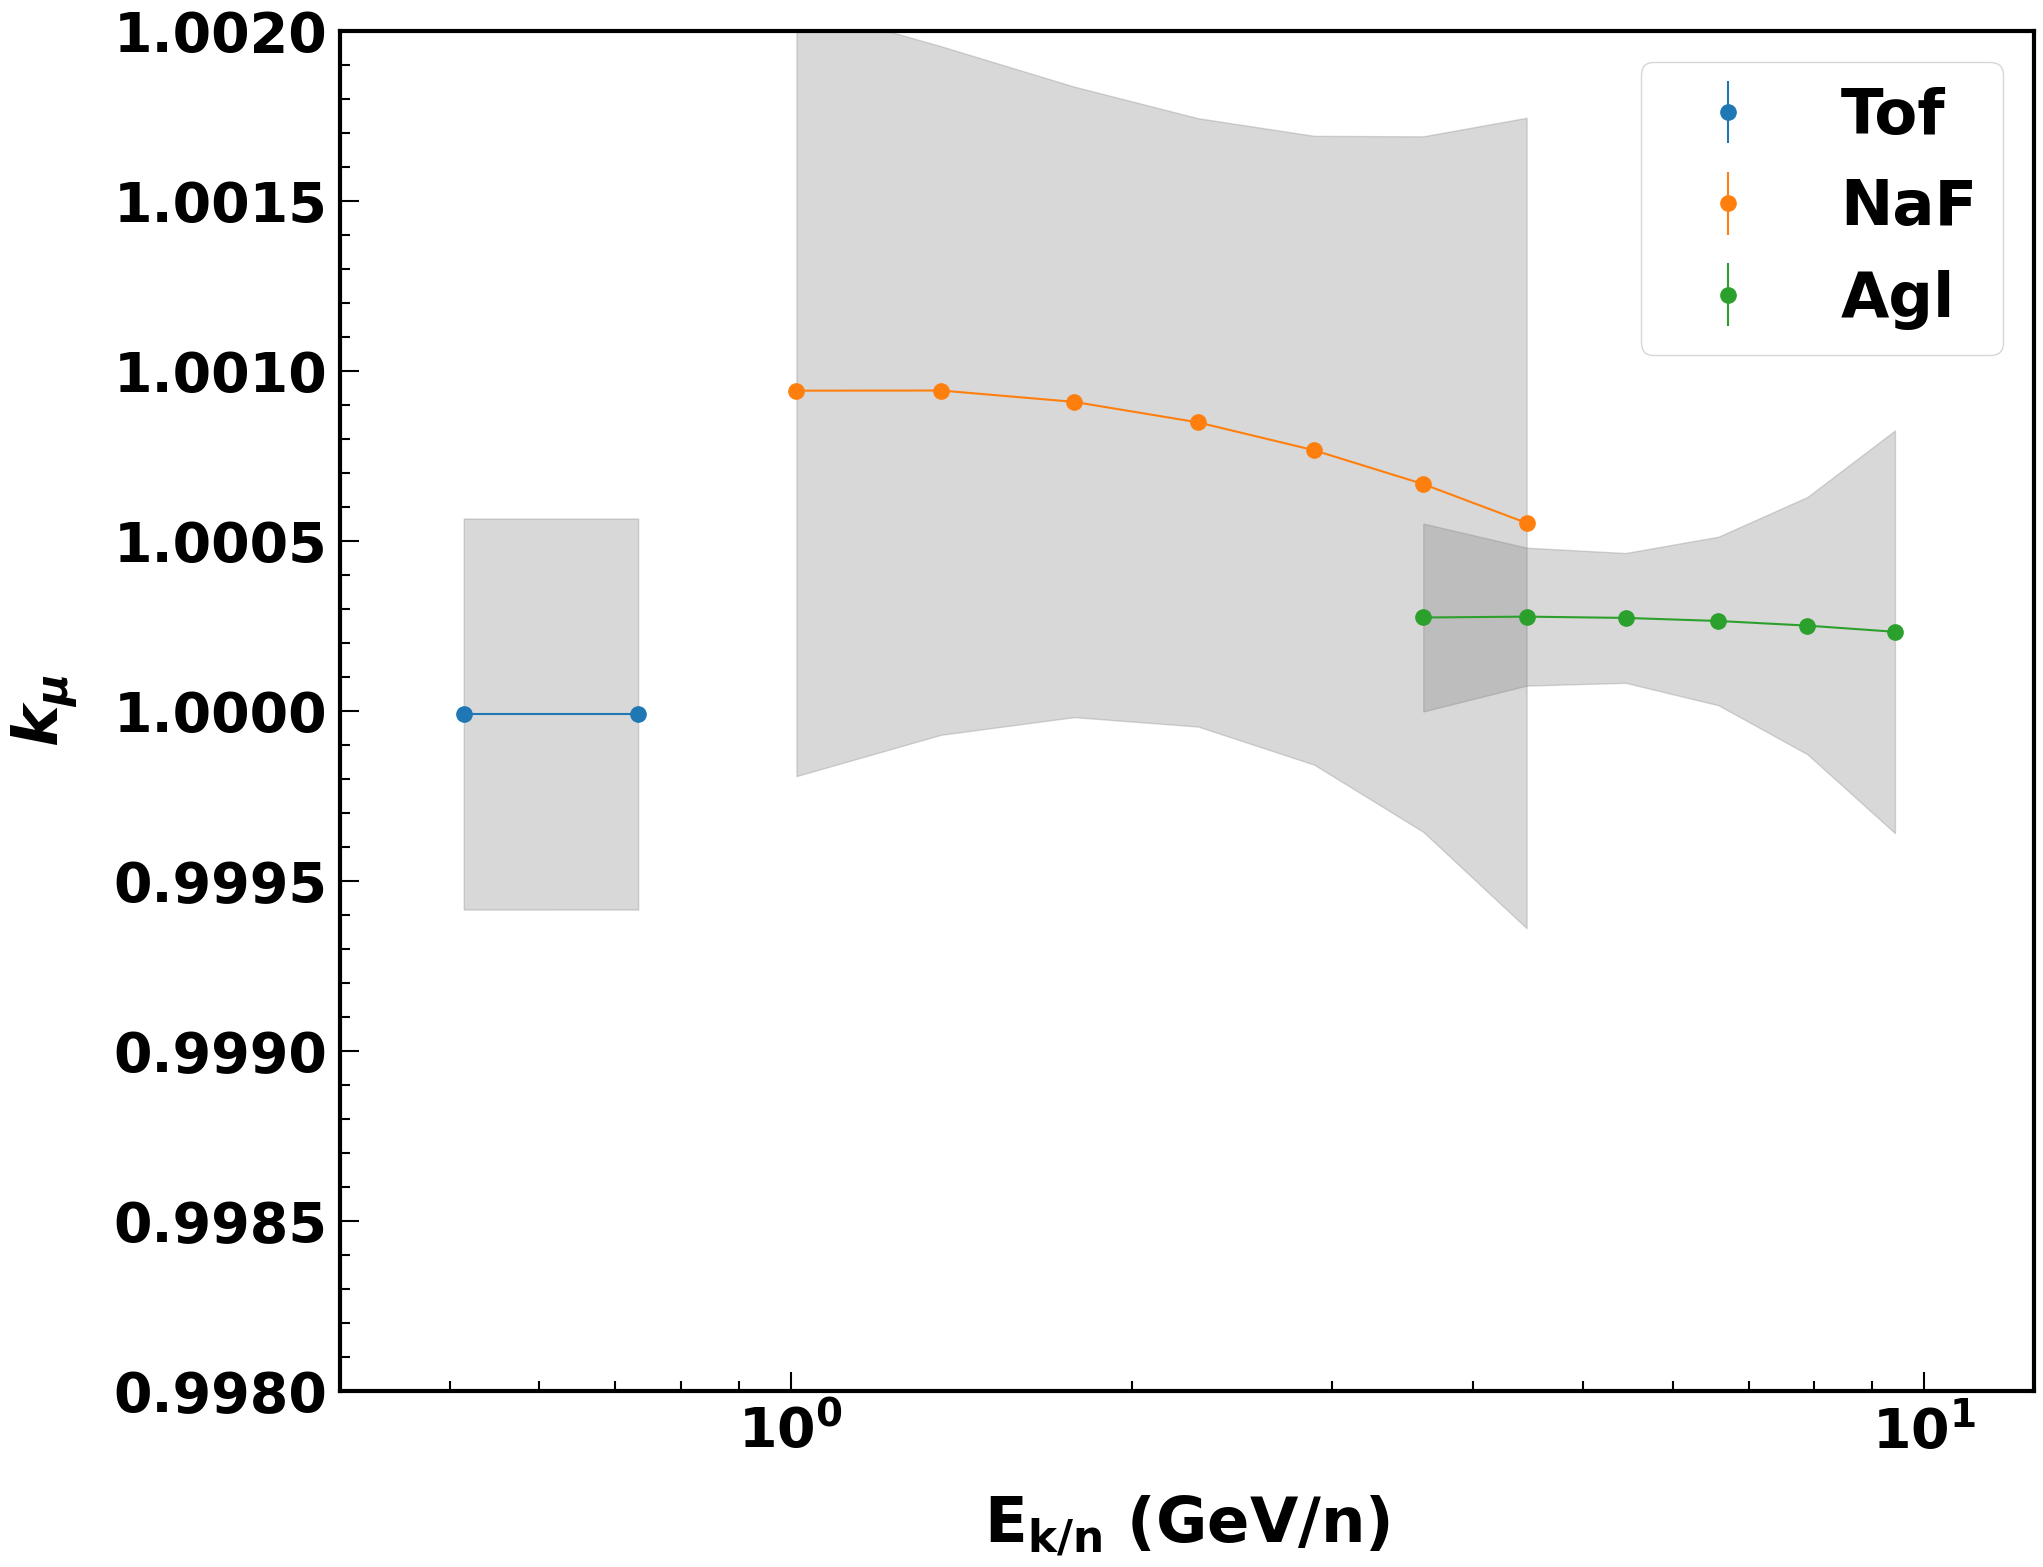

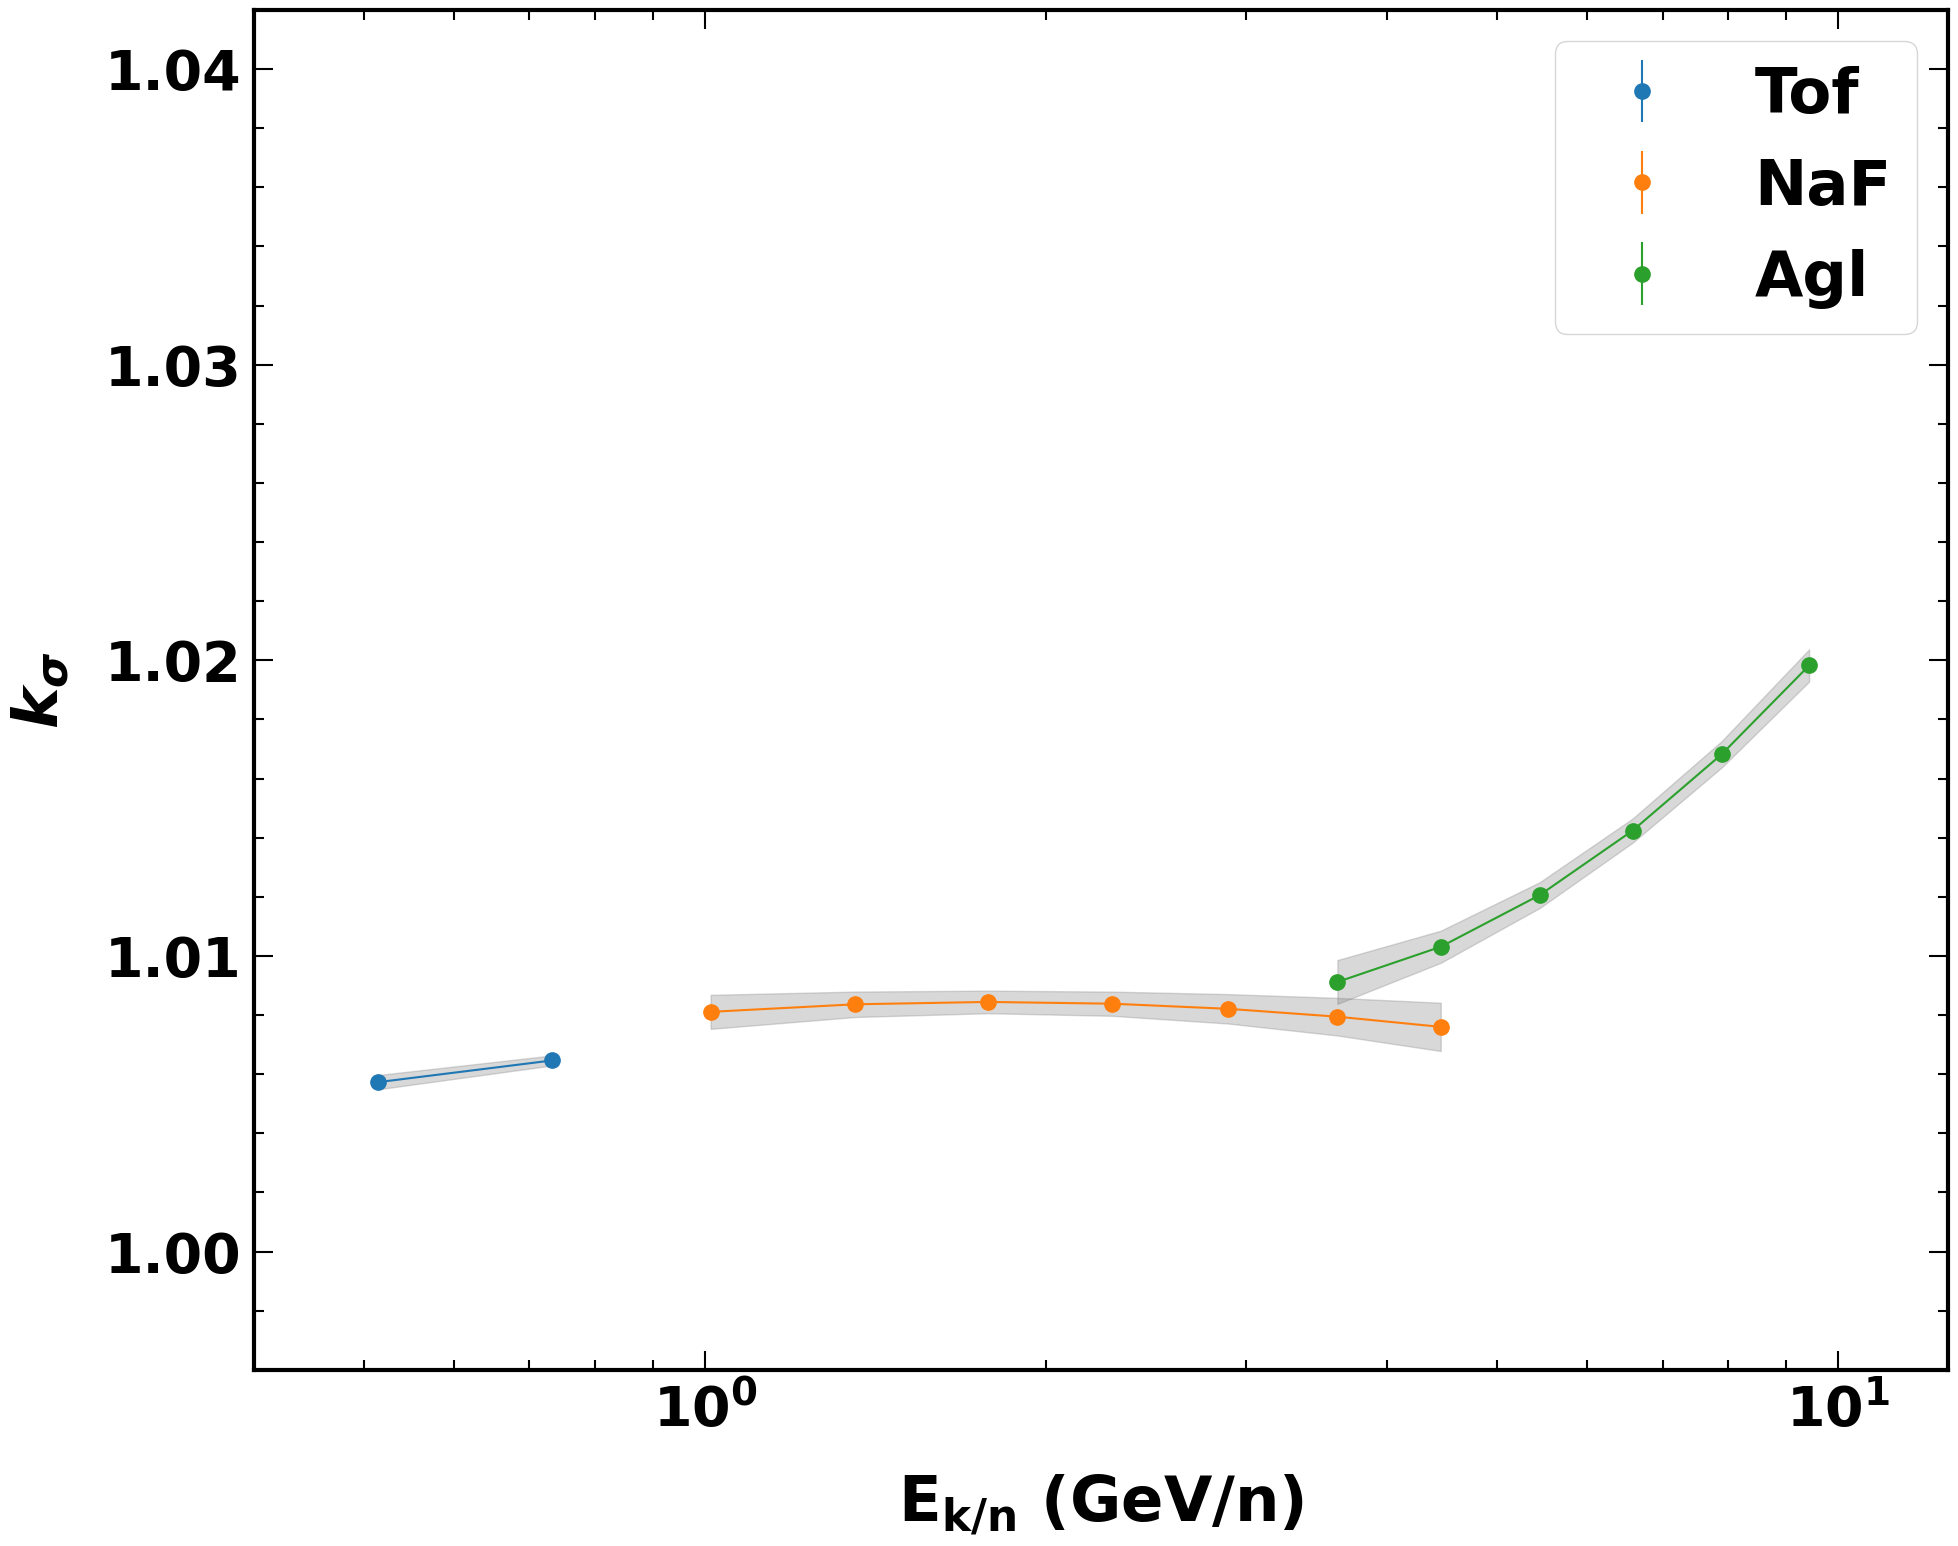

In [11]:
############################################################################################                                                                                         
#read the scale factor and write them to the initial guess                                                                                                                           
############################################################################################                                                                                         
with open('/home/manbing/Documents/Data/data_LiP8/polypars_mufactor.pickle', 'rb') as file:                                                                                          
    mufactorfile = pickle.load(file)                                                                                                                                                                                                    
    print('mufactorfile:', mufactorfile['Tof']   )                
with open('/home/manbing/Documents/Data/data_LiP8/polypars_sigfactor.pickle', 'rb') as file:  
    sigfactorfile = pickle.load(file)     
    print(sigfactorfile)
    
with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/spline_ku_uncertainty.pickle', 'rb') as file:                                                                     
    spline_ku_err = pickle.load(file)                                                                              
    Agl_spline_ku_err = spline_ku_err['Agl'] 
    
with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/spline_ksig_uncertainty.pickle', 'rb') as file:                                                      
    spline_ksig_err = pickle.load(file)                                                                                                                              
    Agl_spline_ksig_err = spline_ksig_err['Agl'] 
    
    
graph_kmu = {}
graph_ksigma = {}
mu_kuerr = {}
sigma_ksigmaerr = {}

detectors = ['Tof', 'NaF', 'Agl']
for dec in detectors:
    xbinning = Binning(fbinning_energy_rebin())
    xbin_index = xbinning.get_indices(xrange[dec])
    xbin_centers = xbinning.bin_centers[xbin_index[0]: xbin_index[1]] 
    graph_kmu[dec] = MGraph(xbin_centers, poly(np.log(xbin_centers), *mufactorfile[dec]['Li7']), np.zeros_like(xbin_centers))
    graph_ksigma[dec] = MGraph(xbin_centers, poly(np.log(xbin_centers), *sigfactorfile[dec]['Li7']), np.zeros_like(xbin_centers))
    mu_kuerr[dec] = spline_ku_err[dec](np.log(xbin_centers)) *0.5
    sigma_ksigmaerr[dec] = spline_ksig_err[dec](np.log(xbin_centers)) *1.5
    


xrangelim = {'Tof': [0.5, 1.2], 'NaF': [1.0, 4.5], 'Agl': [3.5, 12.2]}
fig, ax1 = plt.subplots(1, 1, figsize= FIGSIZE3)
fig.subplots_adjust(left= 0.18, right=0.95, bottom=0.1, top=0.95)
for dec in detectors:   
    plot_graph(fig, ax1, graph_kmu[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec}')  
    plot_graph(fig, ax1, graph_kmu[dec], color=DETECTOR_COLOR[dec],  style="hist", xlog=True, ylog=False, scale=None, markersize=22)  
    SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', r'$k_{\mu}$', 45, xlimrange=[0.4, 12.5], ylimrange=[0.998, 1.002] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
    ax1.fill_between(graph_kmu[dec].xvalues, graph_kmu[dec].yvalues-mu_kuerr[dec], graph_kmu[dec].yvalues+mu_kuerr[dec],  color='grey', alpha=0.3)
    set_plot_style(ax1) 
    ax1.legend()
savefig_tofile(fig, plotfile, f"kmu_Alldecs", show=True) 
   
fig, ax1 = plt.subplots(1, 1, figsize= FIGSIZE3)
fig.subplots_adjust(left= 0.18, right=0.95, bottom=0.1, top=0.95)
for dec in detectors:   
    plot_graph(fig, ax1, graph_ksigma[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec}')  
    plot_graph(fig, ax1, graph_ksigma[dec], color=DETECTOR_COLOR[dec],  style="hist", xlog=True, ylog=False, scale=None, markersize=22)  
    ax1.fill_between(graph_ksigma[dec].xvalues, graph_ksigma[dec].yvalues-sigma_ksigmaerr[dec], graph_ksigma[dec].yvalues+sigma_ksigmaerr[dec],  color='grey', alpha=0.3)
    SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', r'$k_{\sigma}$', 45, xlimrange=[0.4, 12.5], ylimrange=[0.996, 1.042] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
    #ax1.fill_between(graph_guessinit_from_polypar[dec][key].xvalues, graph_pars_lower[dec][key].yvalues, graph_pars_upper[dec][key].yvalues,  color='grey', alpha=0.3)
    set_plot_style(ax1) 
    ax1.legend()
    
savefig_tofile(fig, plotfile, f"ksigma_Alldecs", show=True) 


/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso
/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso
/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.6103 0.8561


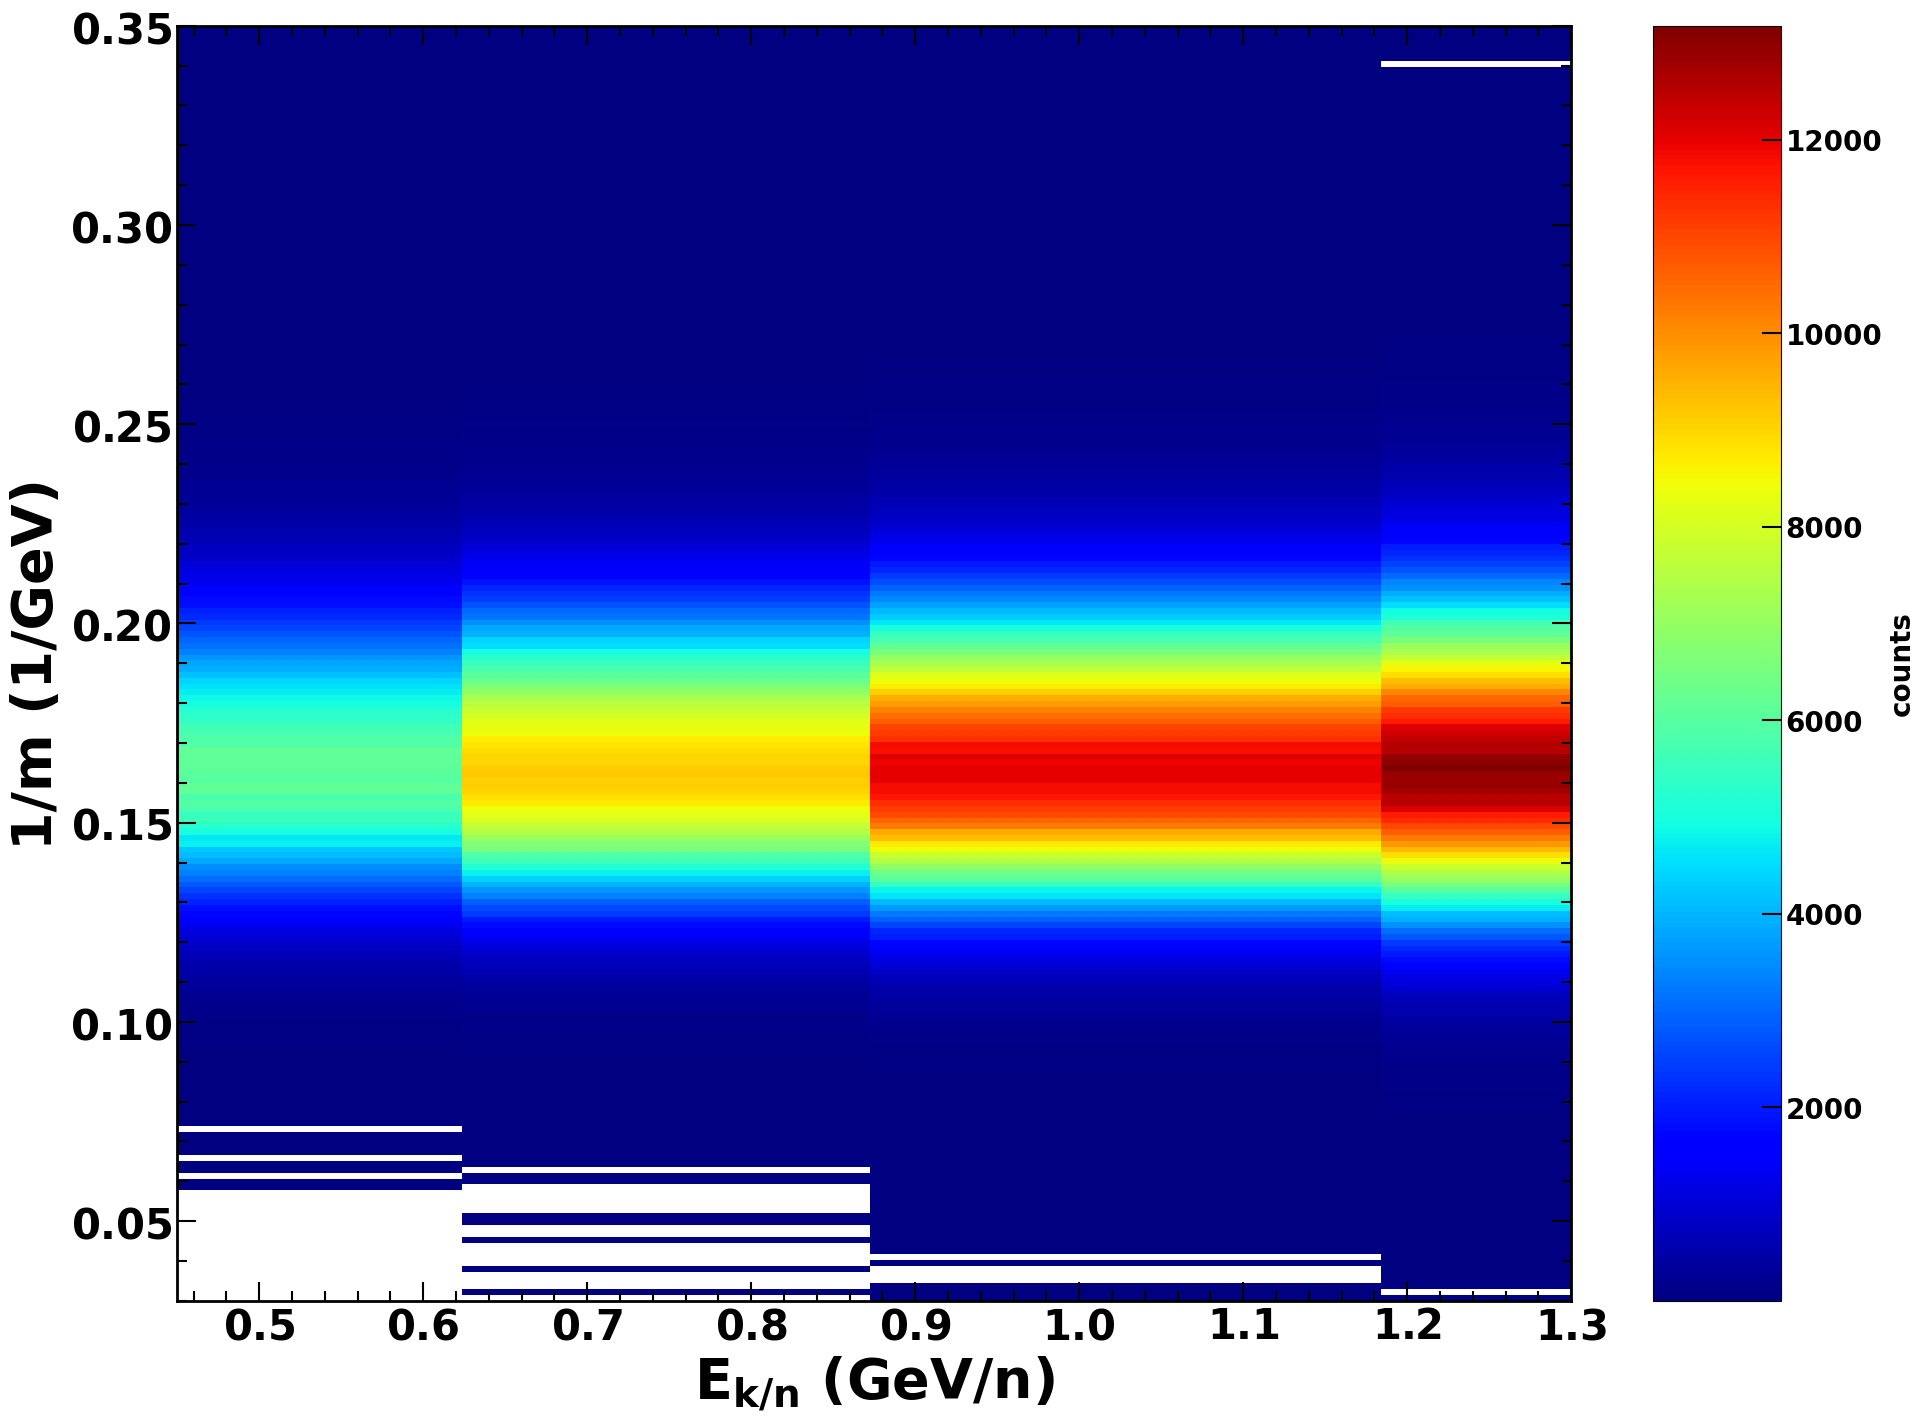

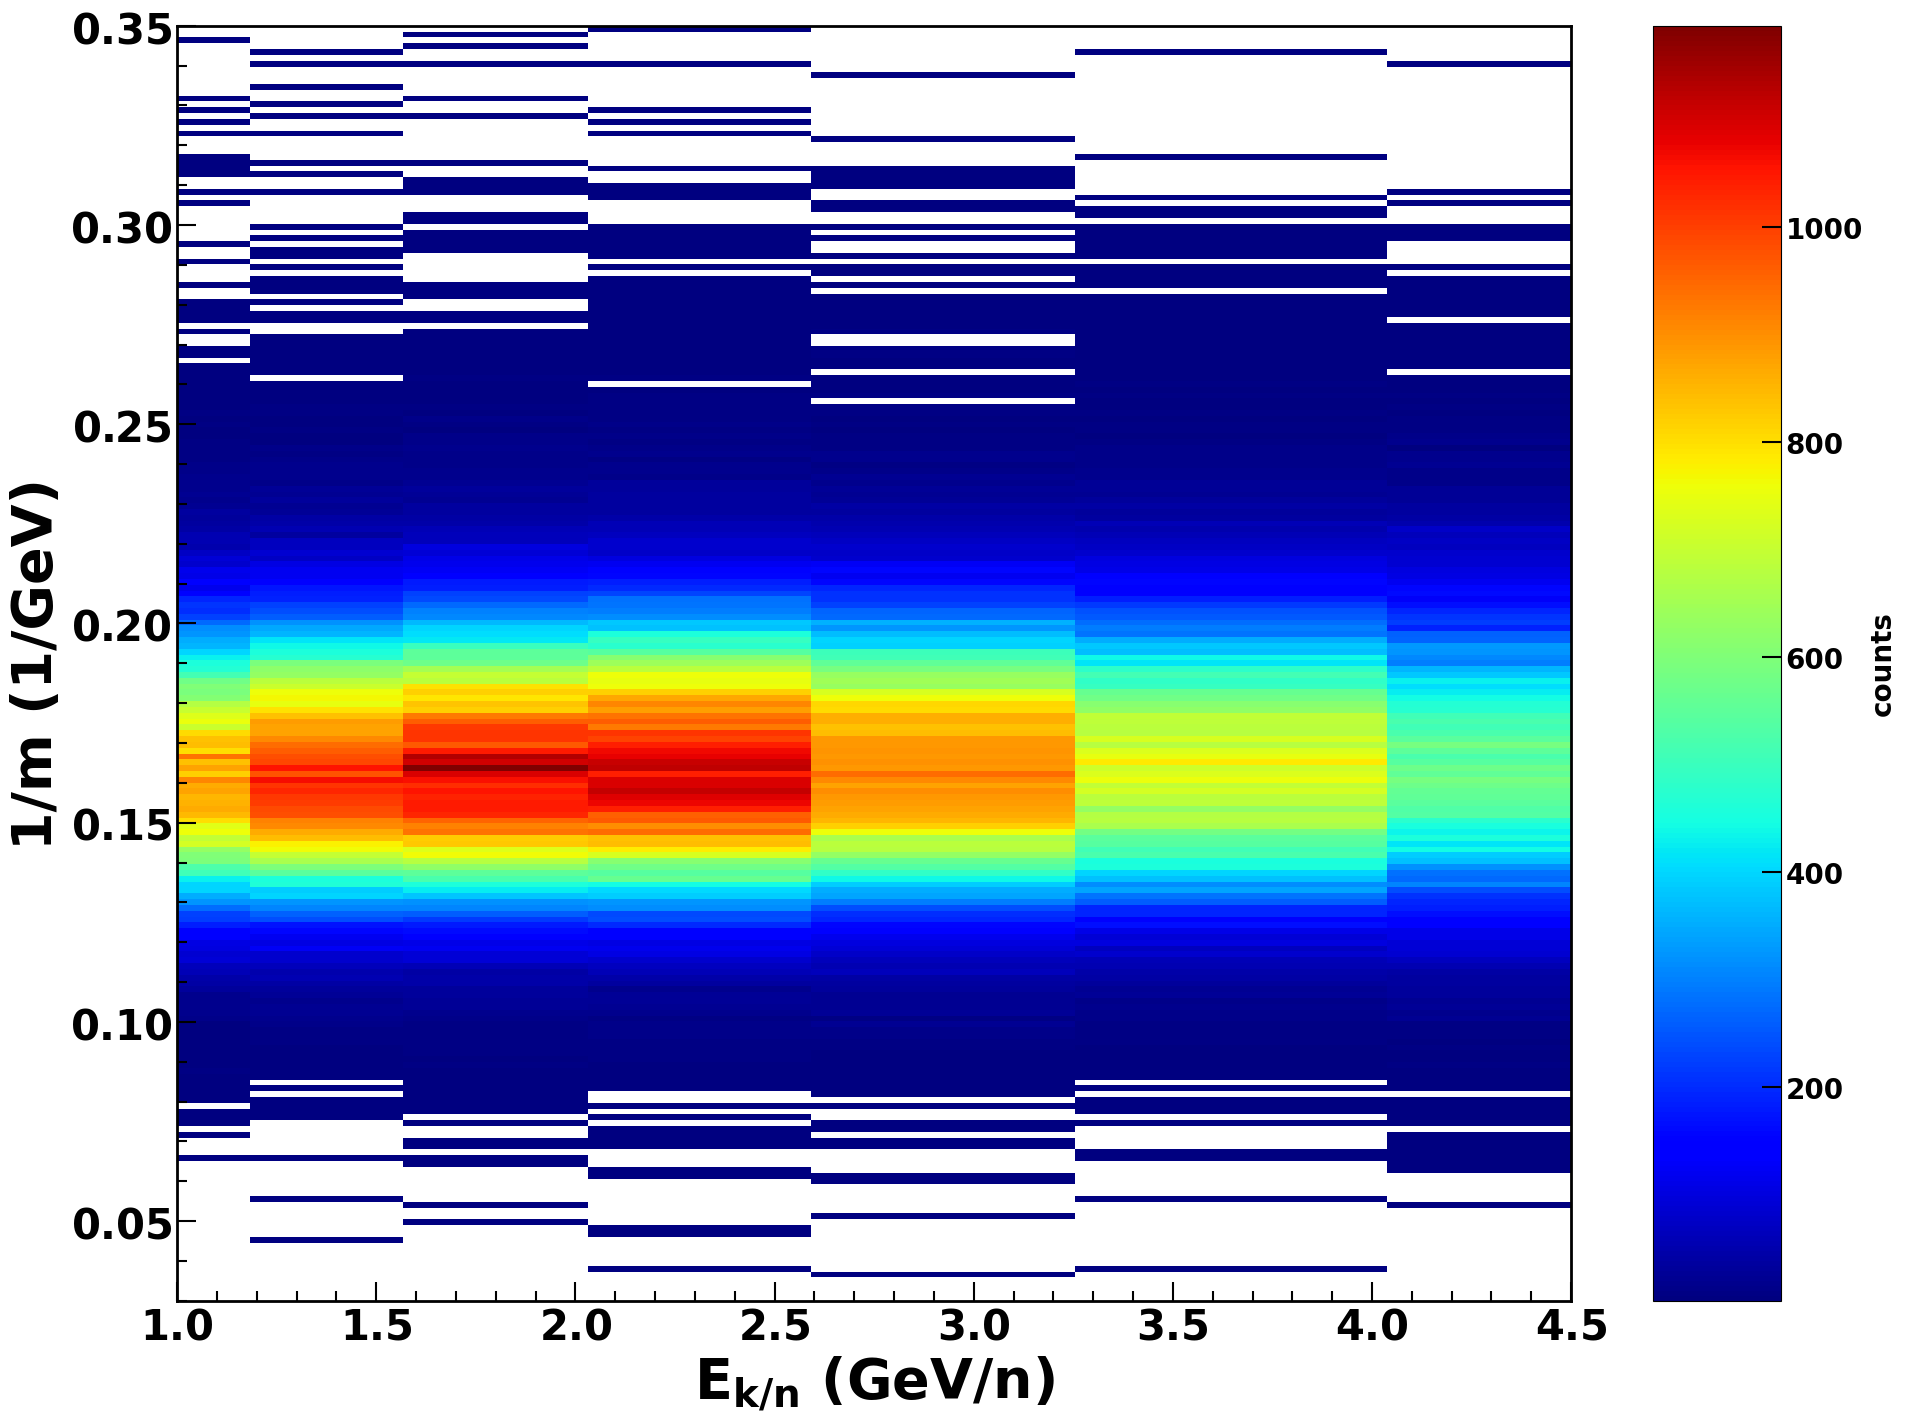

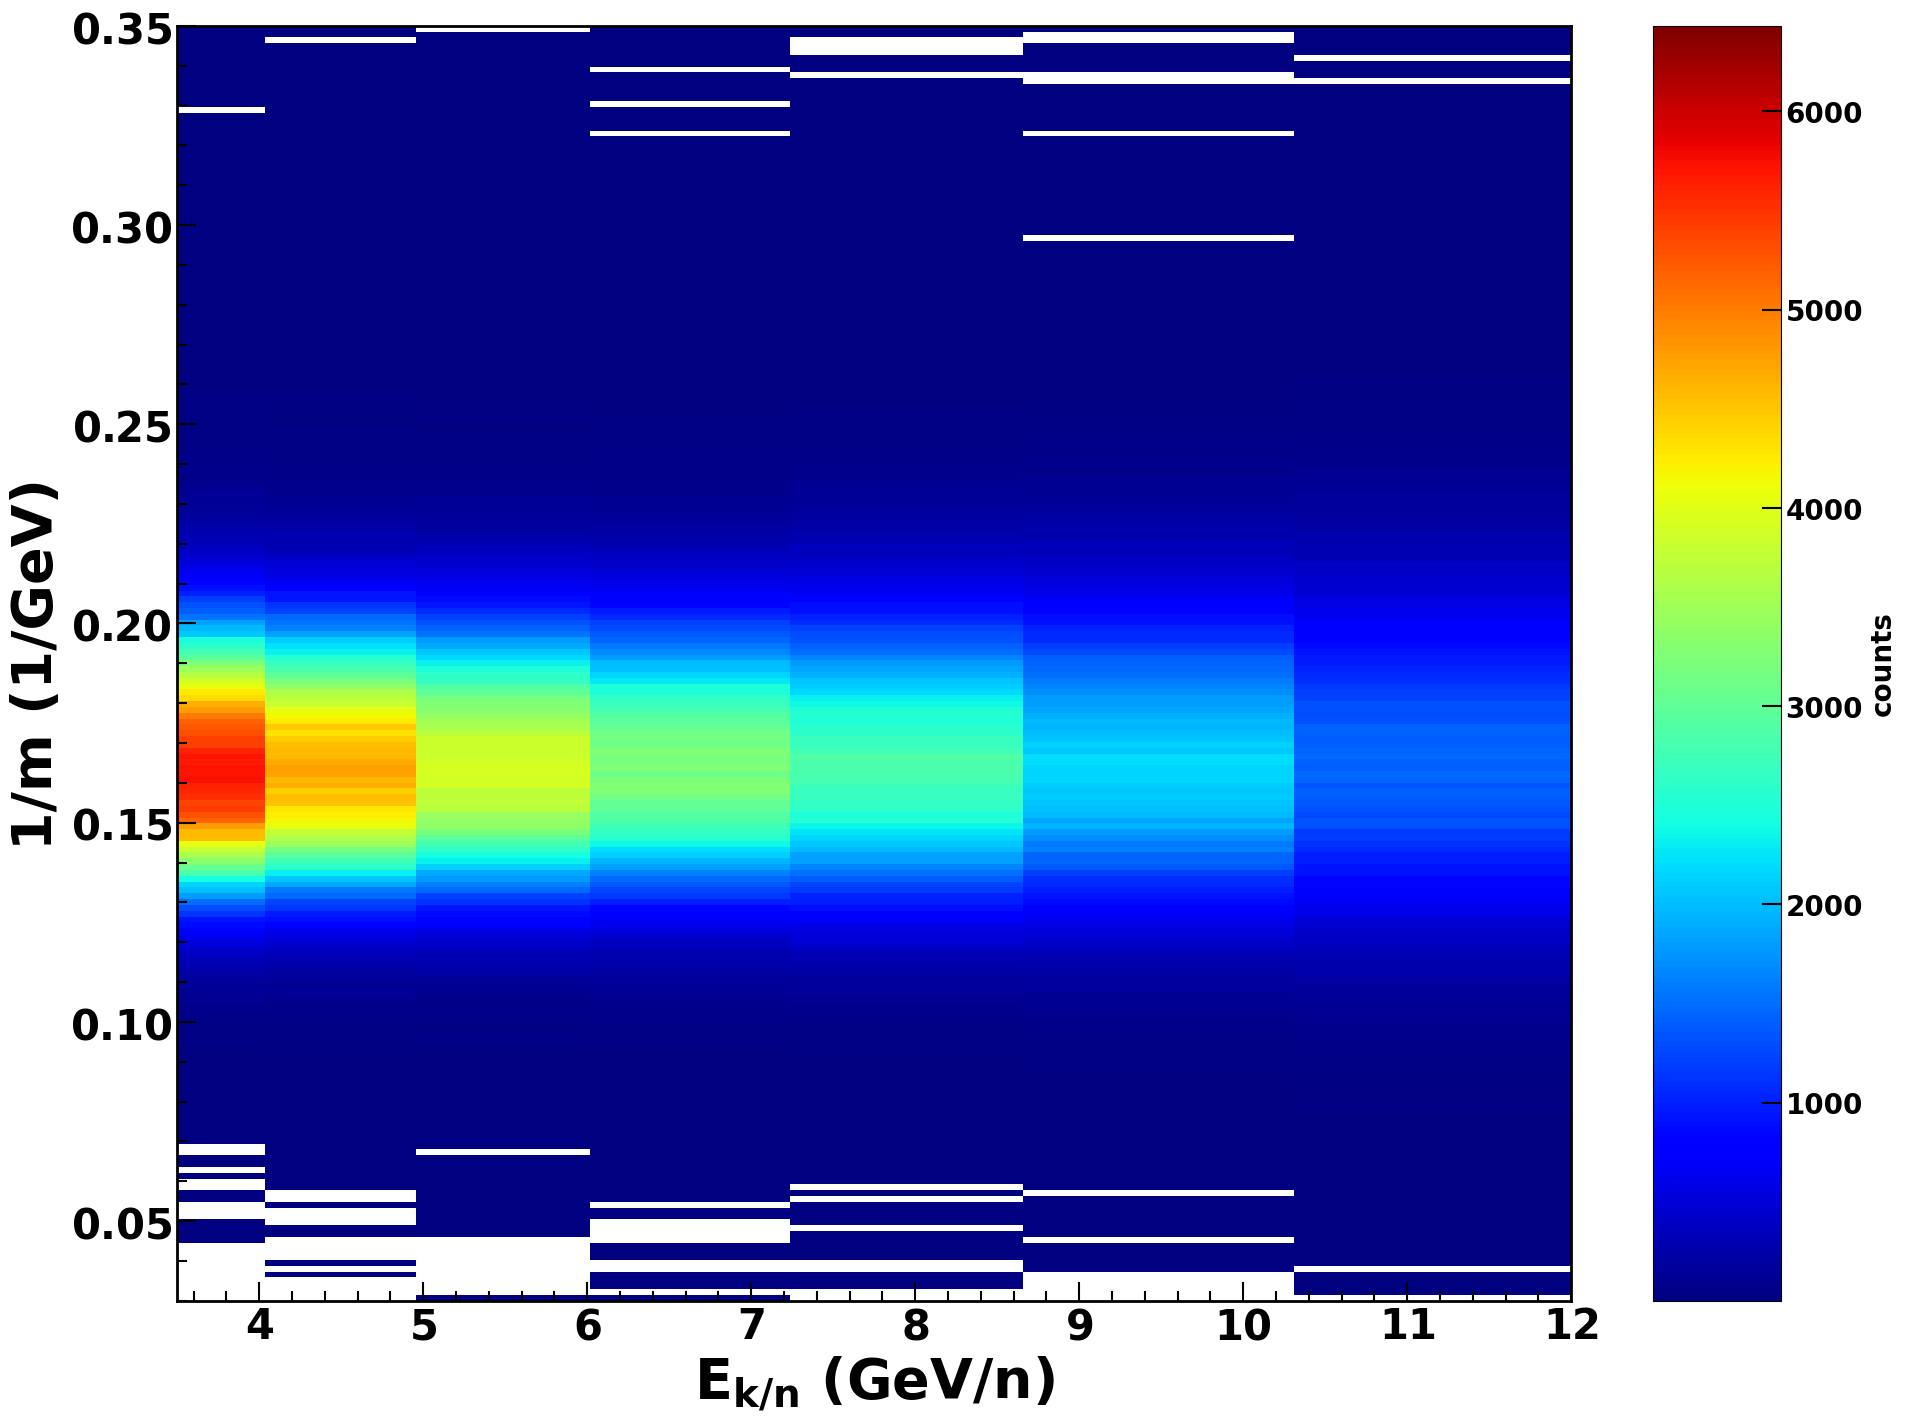

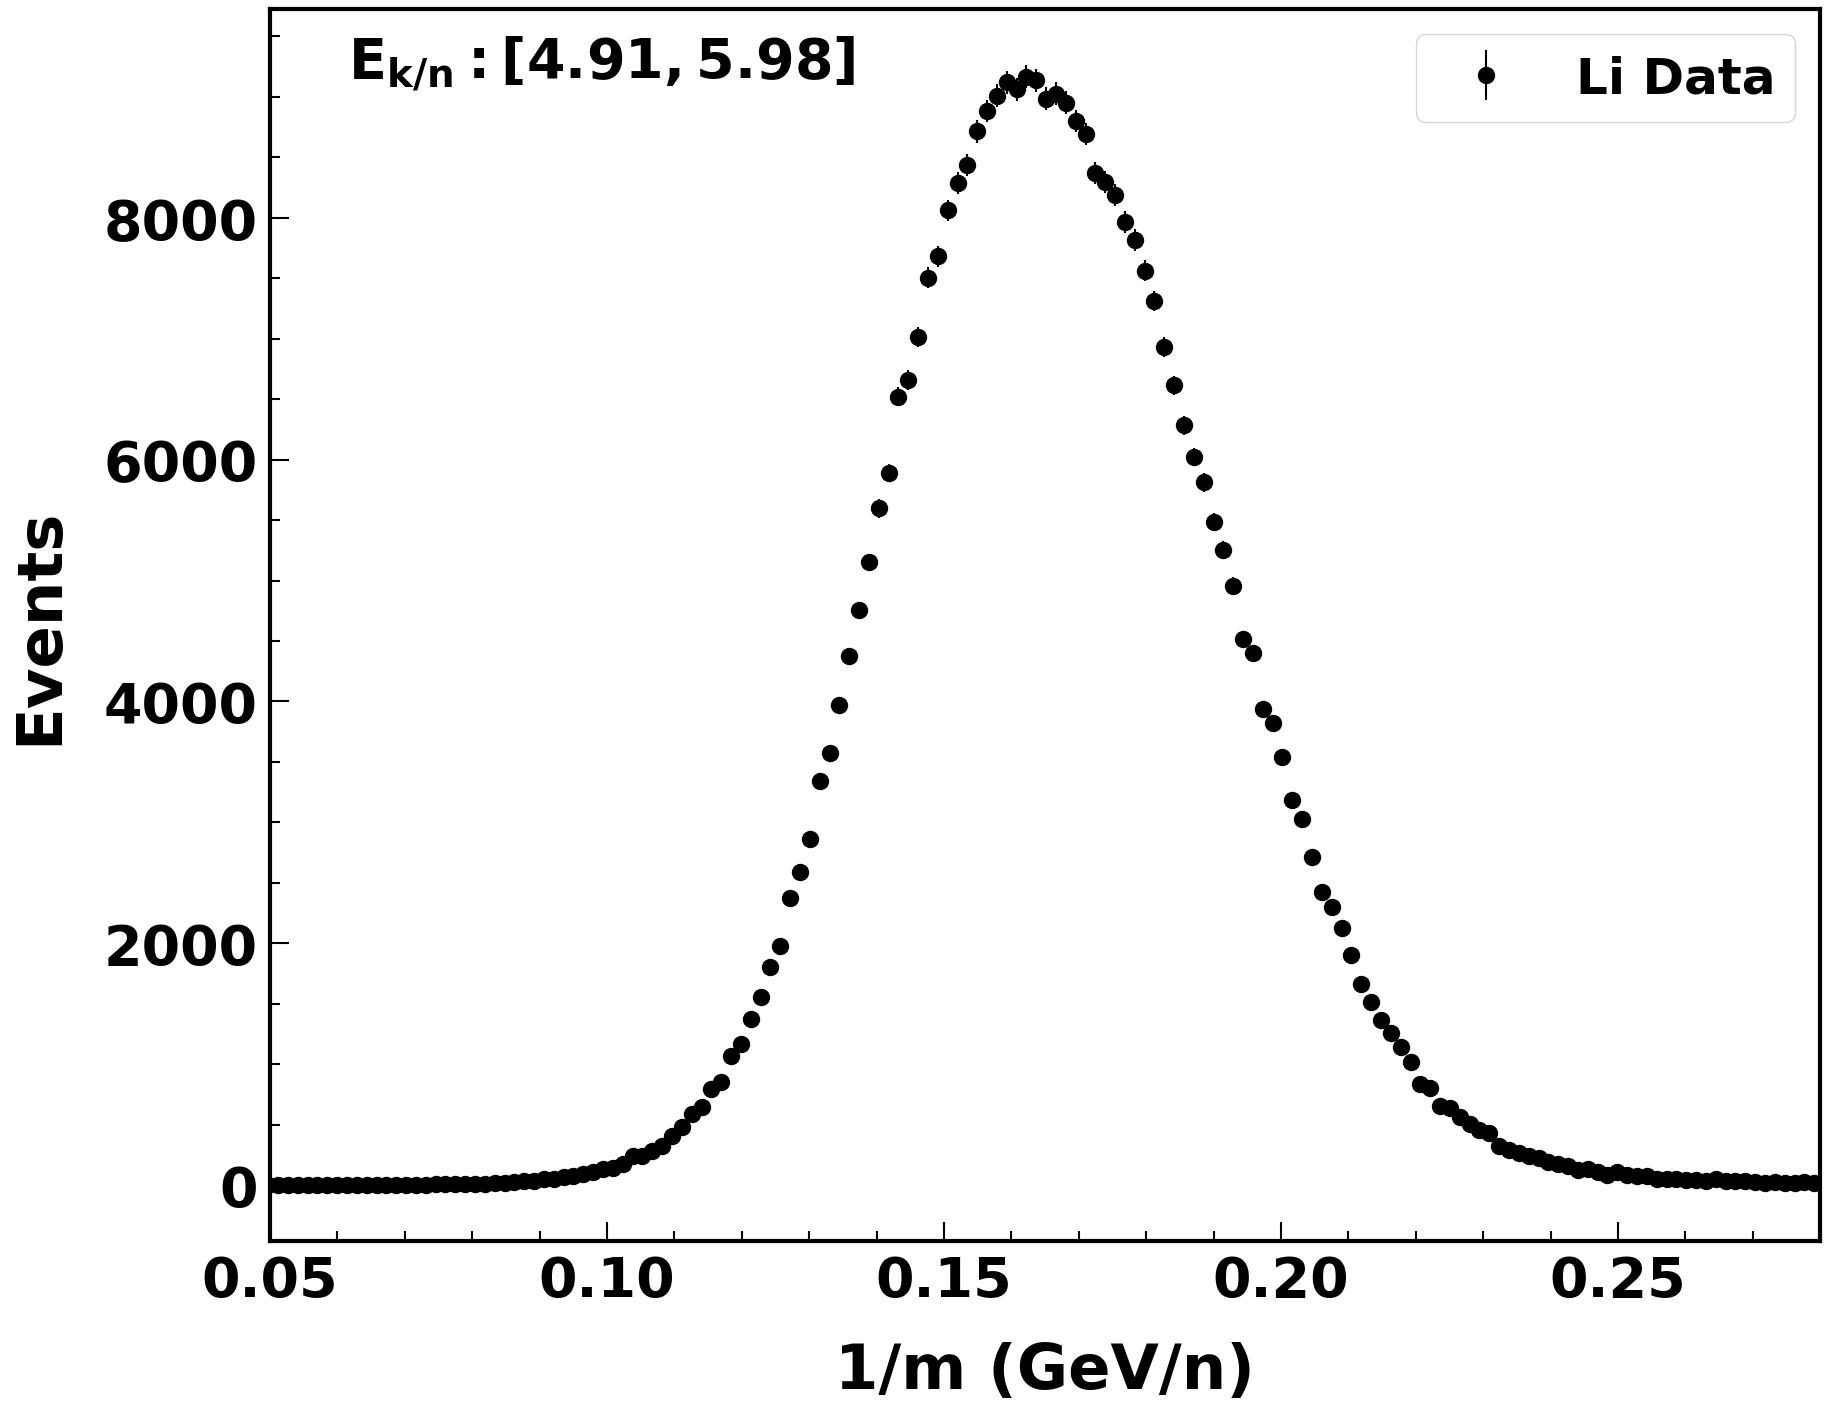

In [12]:
filename = "/home/manbing/Documents/Data/data_LiP8/Hist2D/LiISS_masshist_EkinP8GBL_Rebin.npz"
#filename = "/home/manbing/Documents/Data/data_LiP8/Hist2D/LiISS_Ekin_Lithium_FromCarbon.npz"
massfile = np.load(filename)
nuclei = 'Li'
OpIso = 'Li6'
hist2d_mass_energy = {}
detectors_energyrange = {"Tof": [0.45, 1.3], "NaF": [1.0, 4.5], "Agl": [3.5, 12]}
for dec in detectors: 
    hist2d_mass_energy[dec] = Histogram.from_file(massfile, f"{nuclei}_{dec}OptLi6_mass_ciemat")
    fig = plt.figure(figsize=(20, 15))                                                                       
    plot = fig.subplots(1, 1)  
    set_plot_style(ax1)
    plot2dhist(fig, plot, xbinning=hist2d_mass_energy[dec].binnings[0].edges[1:-1],                   
               ybinning=hist2d_mass_energy[dec].binnings[1].edges[1:-1],                              
               counts=hist2d_mass_energy[dec].values[1:-1, 1:-1],                                    
               xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None,                              
               setlogx=False, setlogy=False, setscilabelx=True, setscilabely=True,  setlogz=False)         
    #plot.text(0.05, 0.98, f"{dec}", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")                                            
    plot.set_ylabel("1/m (1/GeV)", fontsize=40)                                                           
    plot.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$", fontsize=40)                                                           
    plot.set_xlim(detectors_energyrange[dec])  
    print(plotfile)
    savefig_tofile(fig, plotfile, f"hist_ISS_mass_OpLi6_{dec}", show=True) 
    
ibin = 2
decA = 'Tof'
hist1dmass = hist2d_mass_energy[decA].project(ibin)
print(hist2d_mass_energy[decA].binnings[0].edges[ibin], hist2d_mass_energy[decA].binnings[0].edges[ibin+1])
fig = plt.figure(figsize=(20, 16))
plot = fig.subplots(1, 1) 
set_plot_style(plot)

plot_histogram_1d(plot, hist1dmass, style="iss", color="black", label="Li Data", scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False, markersize=23)
SetAx1Axis(plot, '1/m (GeV/n)', 'Events', 45, xlimrange=[0.05, 0.28], ylimrange=None, custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
plot.text(0.05, 0.98, r"$\mathrm{E_{k/n}: [4.91, 5.98]}$", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")                                            
plot.legend()
savefig_tofile(fig, plotfile, f"hist1d_ISS_mass_Agl", show=True) 

/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso


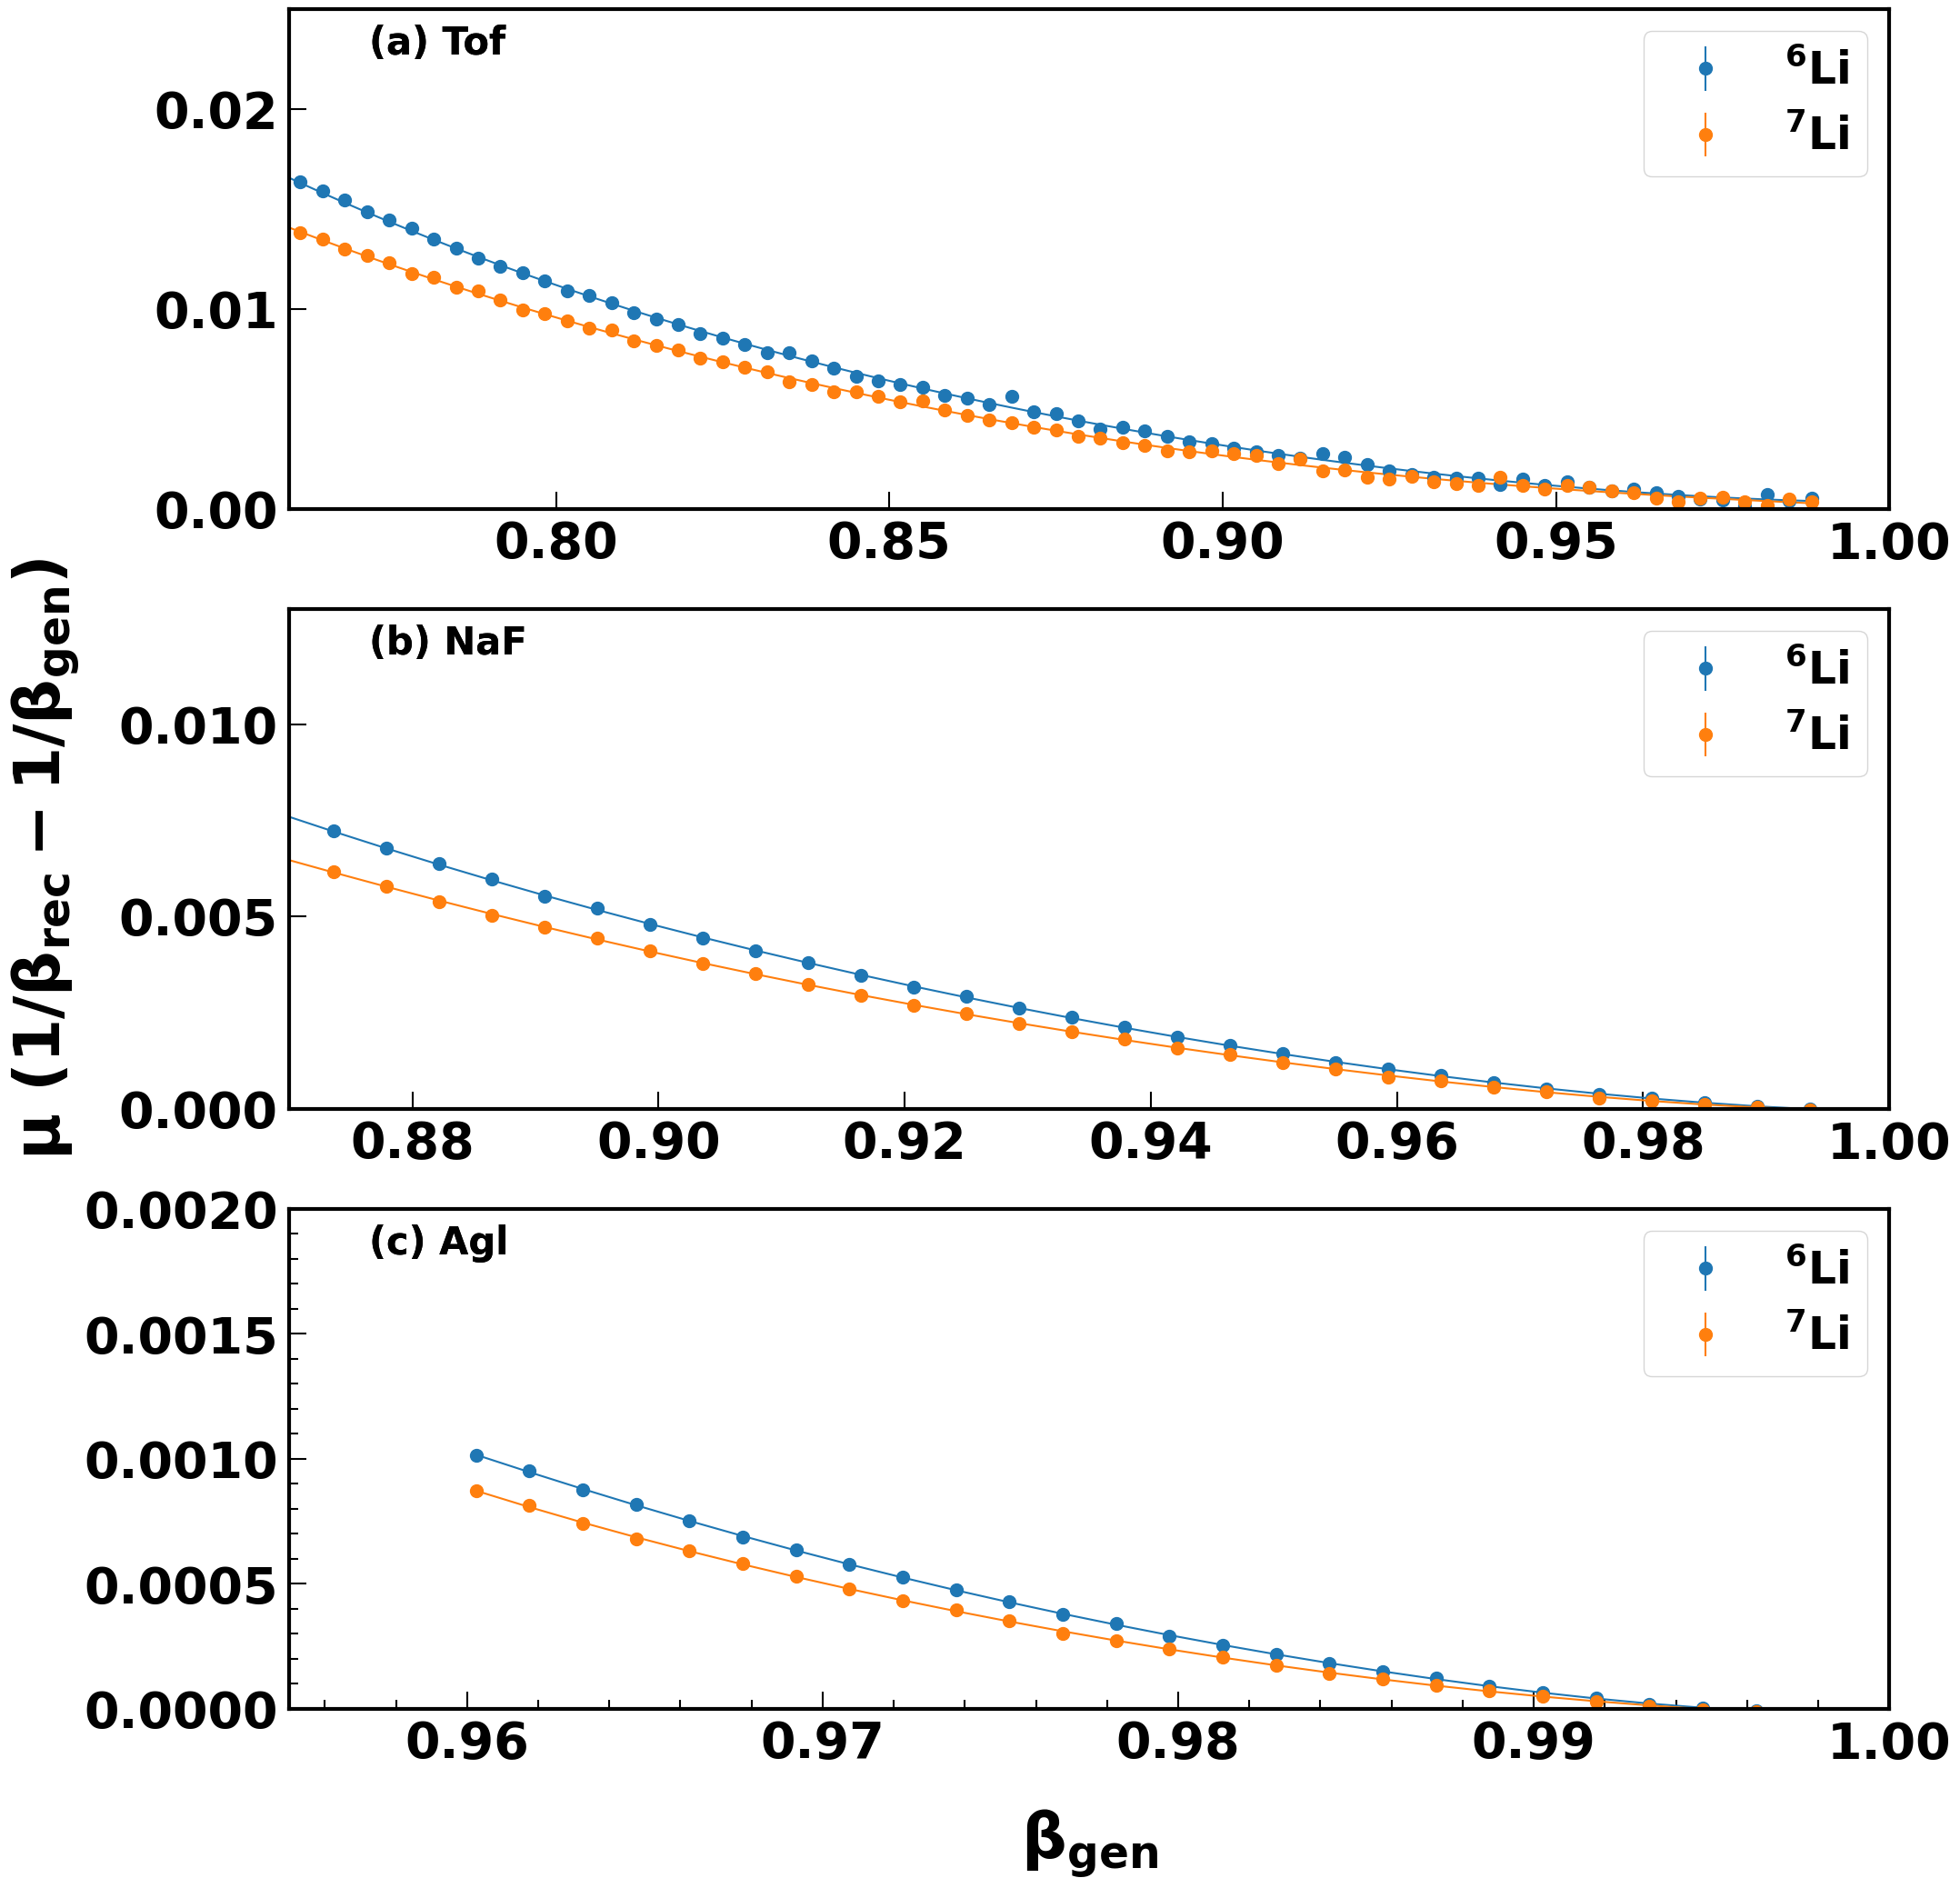

In [13]:
file_beta = '/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/LiBeta/graph_betaresidual_vsbeta2.npz'

detectors = ['Tof', 'NaF', 'Agl']

isotopes = ['Li6', 'Li7']
Num = ['a', 'b', 'c']
#parnames = ['mean', 'sigma', 'sigma_ratio', 'asy_factor', 'fraccore'] 
parnames = ['mean']

xlim_betarange = {'Tof':[0.76, 1.0], "NaF":[0.87, 1.0], "Agl":[0.955, 1.0]}
ylim_range = {'Tof':[0.0, 0.025], "NaF":[0.0, 0.013], "Agl":[0.000, 0.002]}
graph_par = {dec: {iso: {} for iso in isotopes} for dec in detectors}

with np.load(file_beta) as npzfile:    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(22, 22))
    #fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=FIGSIZE_X12)
    fig.subplots_adjust(left= 0.15, right=0.95, bottom=0.1, top=0.95) 
    ax = [ax1, ax2, ax3]
    for i, dec in enumerate(detectors):
        for iso in isotopes:
            for par in parnames:
                graph_par[dec][iso][par] = MGraph.from_file(npzfile, f"graph_betaresidual_{dec}{iso}_{par}_vsbeta") 
                graph_par[dec][iso]['mean'].yvalues = graph_par[dec][iso]['mean'].yvalues * -1
                plot_graph(fig, ax[i], graph_par[dec][iso][par], color=ISOTOPES_COLOR[iso], label=f"{ISO_LABELS[iso]}", style="EP", xlog=False, ylog=False, markersize=20)                                                                            
                spline_betaresidual = UnivariateSpline(graph_par[dec][iso][par].xvalues, graph_par[dec][iso][par].yvalues, k=5, s=5)  
                ax[i].plot(graph_par[dec][iso][par].xvalues, spline_betaresidual(graph_par[dec][iso][par].xvalues))   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
                #ax[i].text(0.05, 0.98, f"{dec}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", weight='bold')                                                                                                                                                                                                                                                           
                set_plot_style(ax[i])
                SetAx1Axis(ax[i], '', '', 40, xlimrange=xlim_betarange[dec], ylimrange=ylim_range[dec] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog=False)
                ax[i].text(0.05, 0.97, f"({Num[i]}) {dec} ", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold")          
                ax[i].grid(axis='y')
                ax[i].legend(fontsize=35)   
    ax3.set_xlabel(r'$\mathrm{\beta_{gen}}$', fontsize=50, labelpad=30)     
    #ax3.set_xticks([0.4, 1, 2, 10, 30, 100])                                                                                                                                                                      
    #ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
    #ax1.sharex(ax3)   
    #ax2.sharex(ax3)
    ax2.set_ylabel(r"$\mathrm{\mu \ (1/\beta_{rec} -1/\beta_{gen})}$", fontsize=50, labelpad=30) 
    #for label in ax1.get_xticklabels():
    #    label.set_visible(False)
    # Repeat the process for ax2
    #for label in ax2.get_xticklabels():
    #    label.set_visible(False)

    #set_plot_defaultstyle(ax1)                                                                                                                                                                                 
    #set_plot_defaultstyle(ax2)   
    plt.subplots_adjust(hspace=.2)
        
    print(plotfile)
    savefig_tofile(fig, plotfile, f"Li_graph_betamu_vebeta", show=True)                                                                                                                 



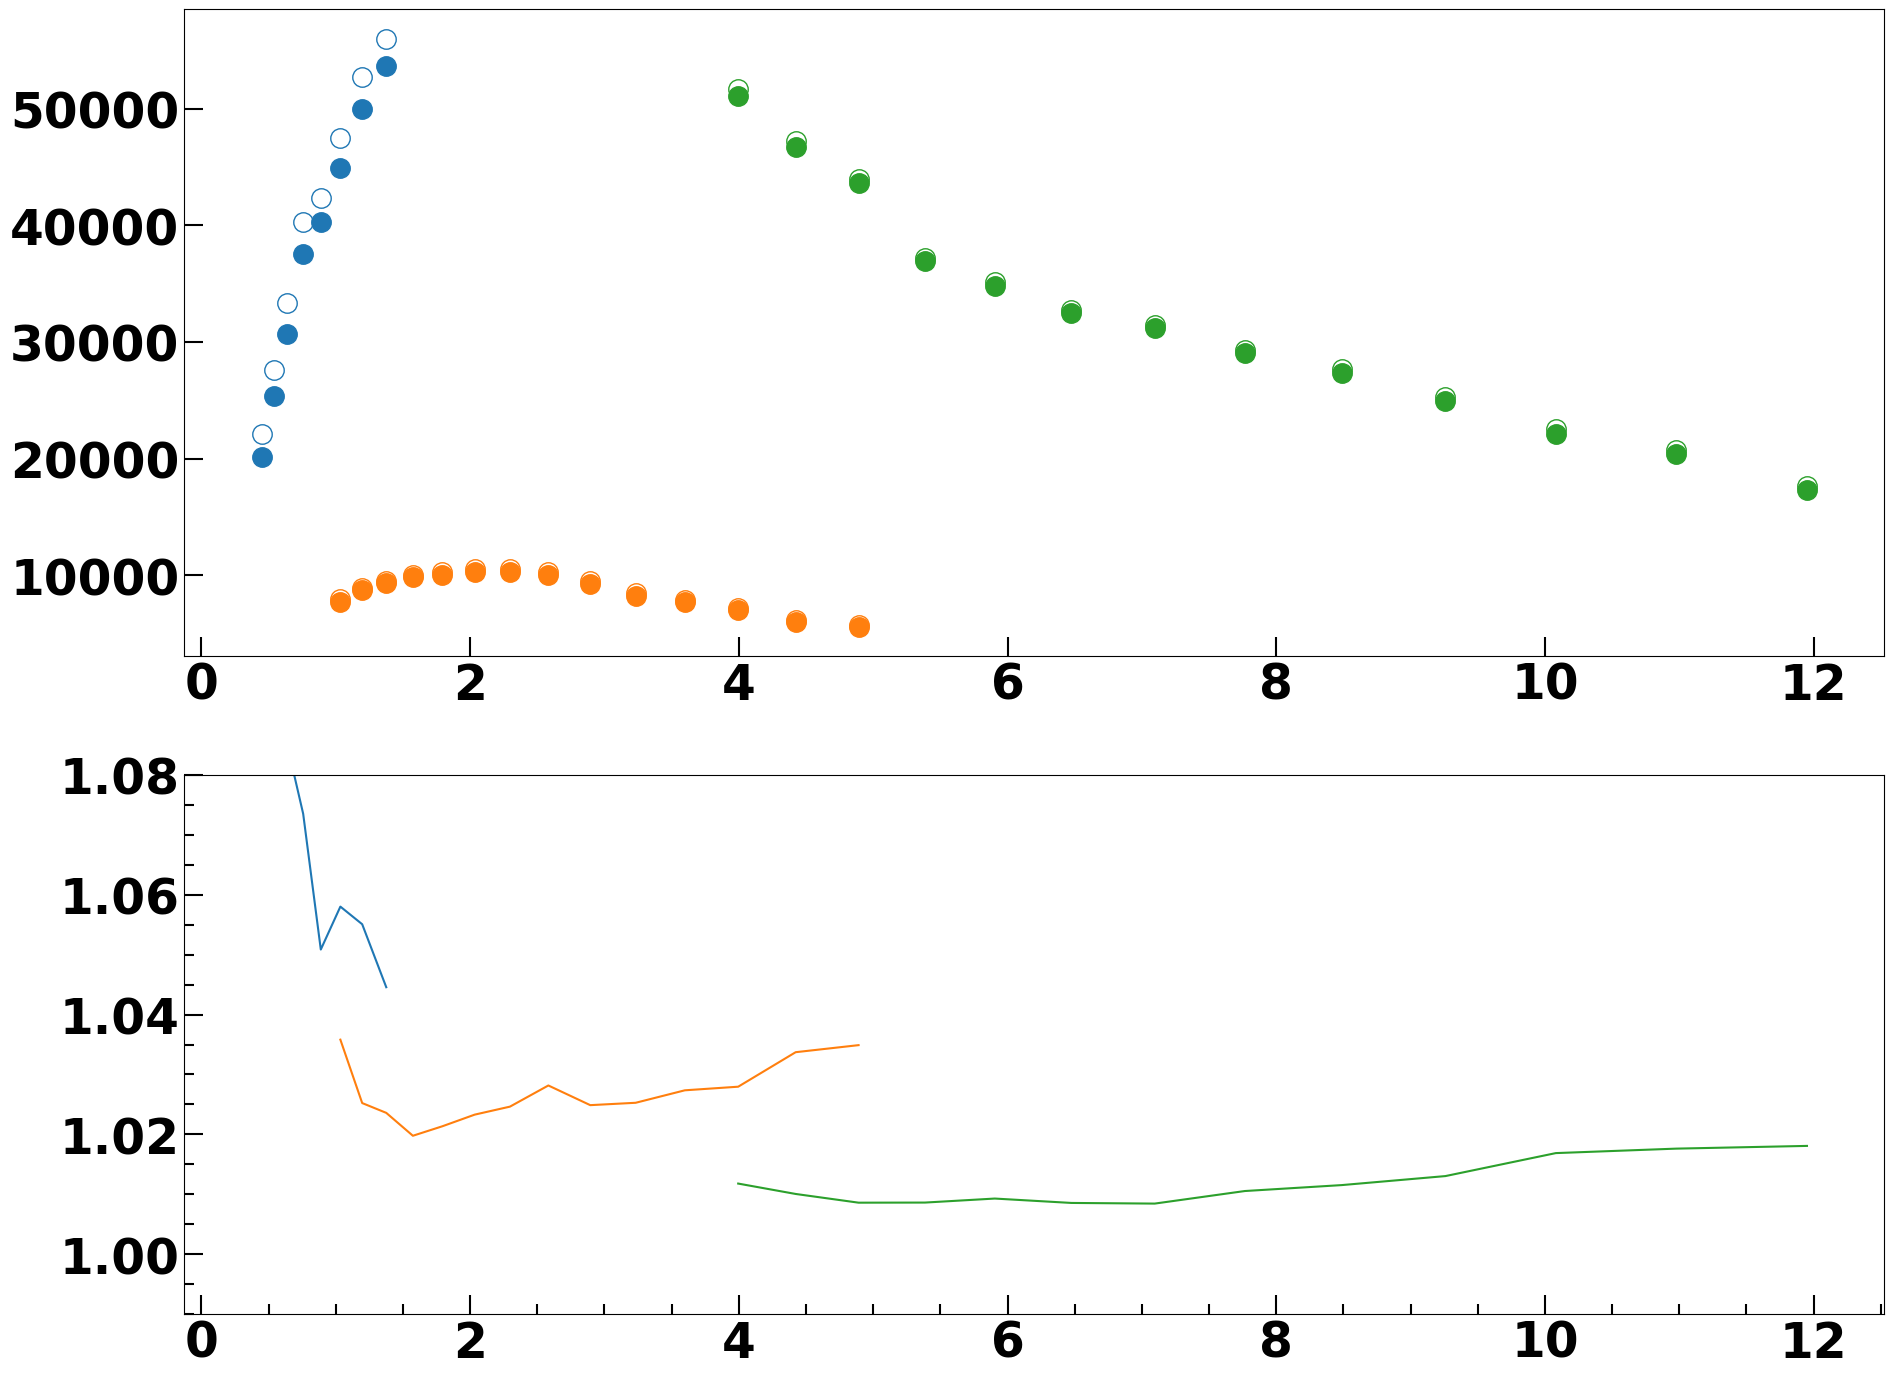

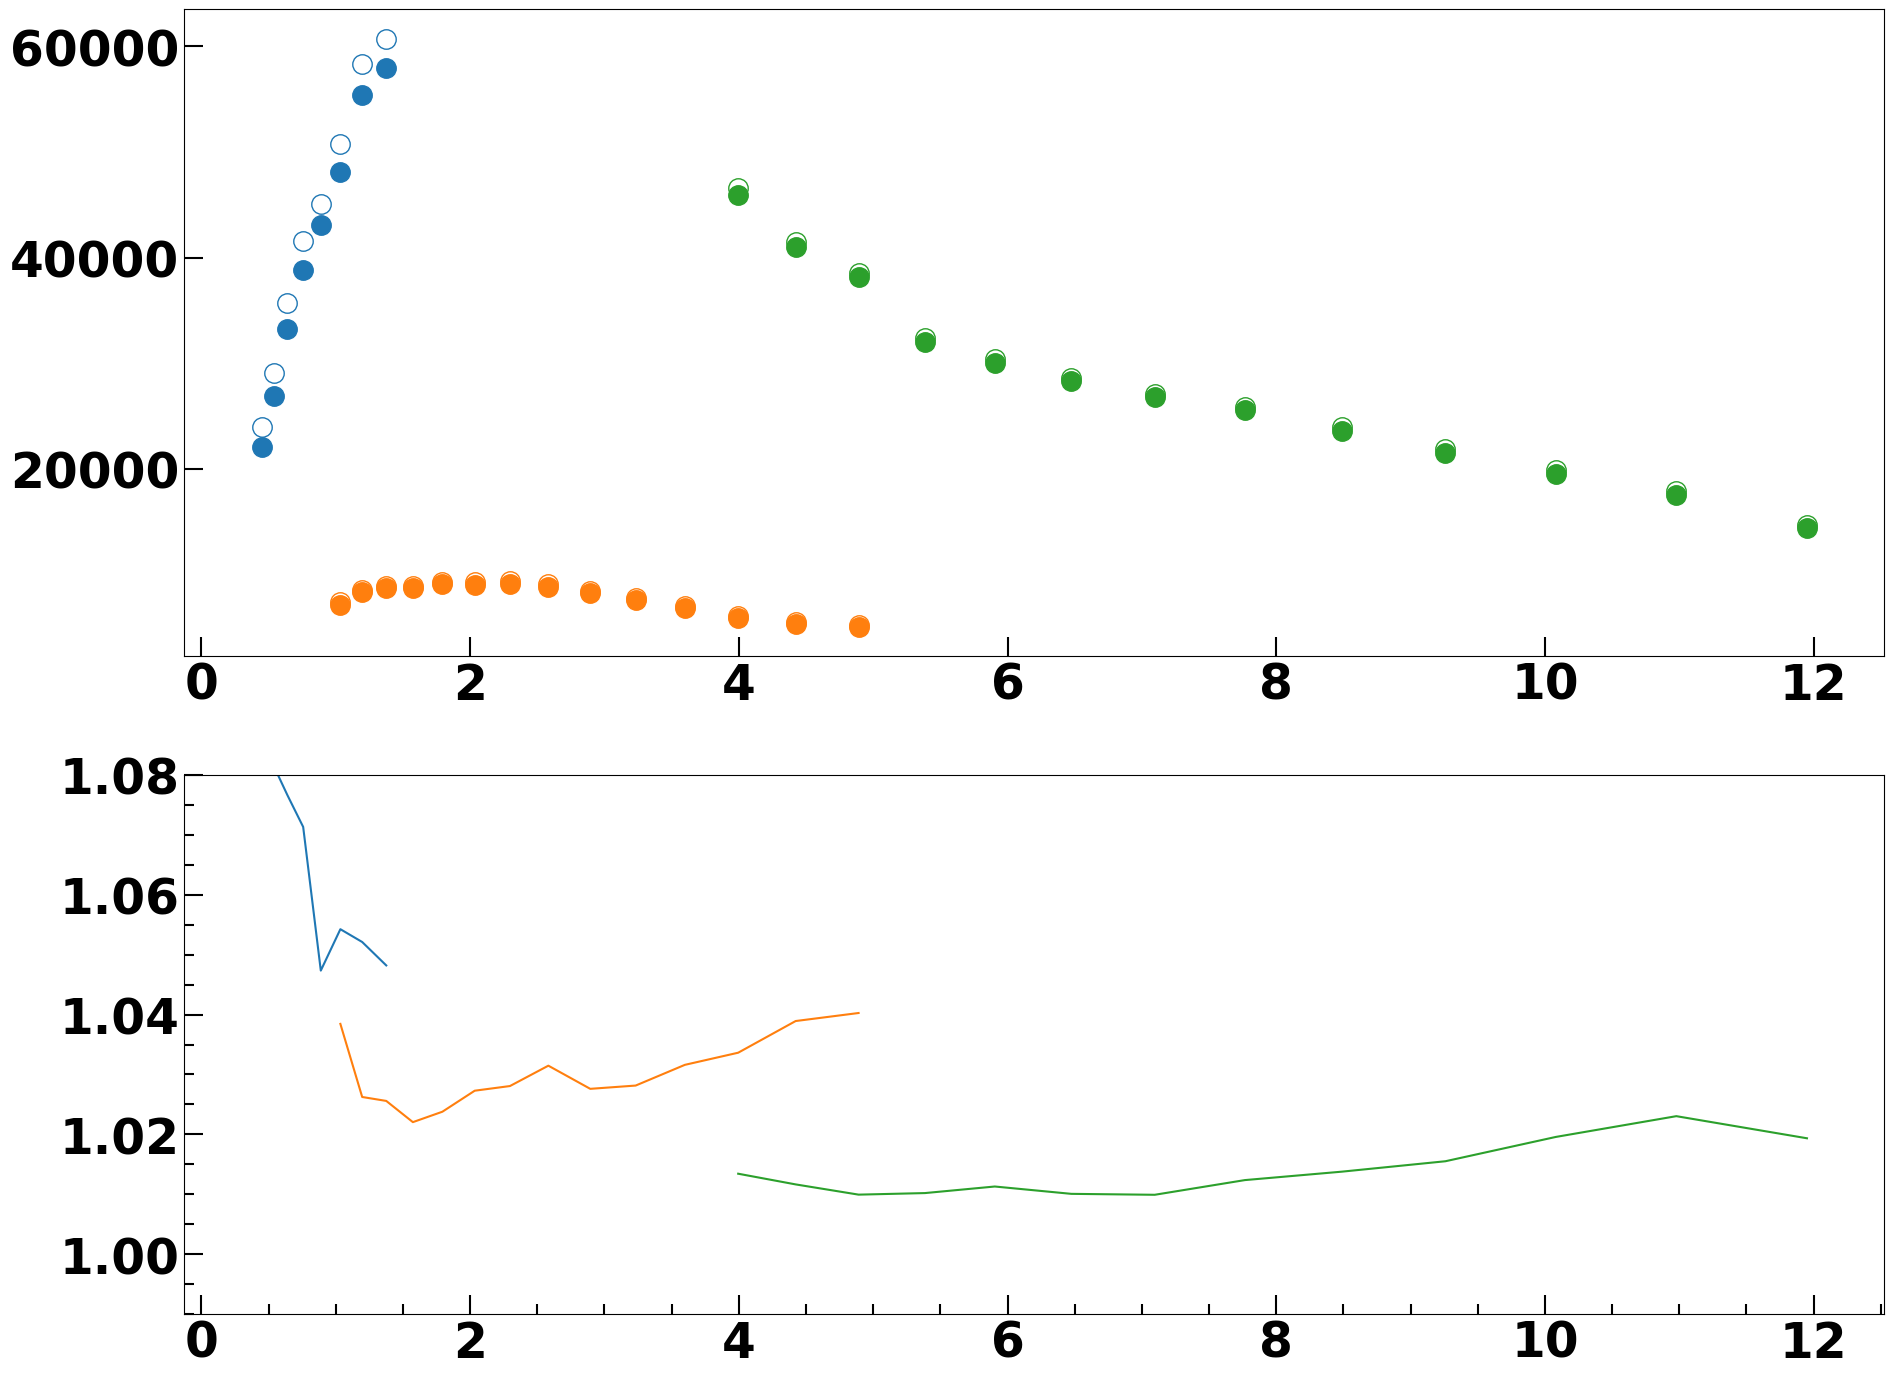

In [10]:
nuclei = 'Li'
file_counts = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitData_finebin_binbybin_May/graph_massfit_counts.npz'
df_counts = np.load(file_counts)
graph_counts_min = {iso: {} for iso in ISOTOPES[nuclei]}
graph_counts_max = {iso: {} for iso in ISOTOPES[nuclei]}
graph_counts_stderr = {iso: {} for iso in ISOTOPES[nuclei]}
isotopes_atom_num = [7, 9, 10] 
isotopes = ['Li6', 'Li7']
dec = 'Agl'
#detectors=['Agl']
detectors=['Tof', 'NaF', 'Agl']
for iso in isotopes:
    for dec in detectors:
        graph_counts_min[iso][dec] = MGraph.from_file(df_counts, f'graph_counts_min_{dec}_{iso}')
        graph_counts_max[iso][dec] = MGraph.from_file(df_counts, f'graph_counts_max_{dec}_{iso}')
        graph_counts_stderr[iso][dec] = MGraph.from_file(df_counts, f'graph_counts_stderr_{dec}_{iso}')

xbinning_ekn = Binning(kinetic_energy_neculeon_binning())
graph_ratio = {iso: {} for iso in ISOTOPES[nuclei]}
ratiolim = {'Li6': [0.99, 1.08], 'Li7':[0.99, 1.08]}
graph_relativeerr = {iso: {} for iso in ISOTOPES[nuclei]}
for iso in isotopes:
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.5]}, figsize=FIGSIZE2)                                                                                                            
    fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
    for dec in detectors:
        plot_graph(fig, ax1, graph_counts_min[iso][dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=MKSIZE, label=f'min')  
        plot_graph(fig, ax1, graph_counts_max[iso][dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=MKSIZE, label='max', markerfacecolor="none") 
        graph_ratio[iso][dec] = graph_counts_max[iso][dec]/graph_counts_min[iso][dec]
        graph_relativeerr[iso][dec] = MGraph(graph_ratio[iso][dec].xvalues,  (graph_ratio[iso][dec].yvalues -1.0) * 100 * 0.7, np.zeros_like(graph_ratio[iso][dec].xvalues))
        plot_graph(fig, ax2, graph_ratio[iso][dec], color=DETECTOR_COLOR[dec],  style="hist", xlog=False, ylog=False, scale=None, markersize=MKSIZE, label='max', markerfacecolor="none") 
    ax2.set_ylim(ratiolim[iso])
    




xvalues			yvalues			yerrs
0.44778			2.4187068420009545			0.0
0.538415			2.4067946635926476			0.0
0.64103			2.479276949089834			0.0
0.7578670000000001			2.0720485344444444			0.0
0.8890595			1.3844806039052946			0.0



xvalues			yvalues			yerrs
1.0347455			0.927429952105243			0.0
1.197125			0.6629306597497586			0.0
1.37623			0.6082822248838772			0.0
1.574355			0.5353324108769659			0.0
1.793835			0.602187081407641			0.0
2.03468			0.6594361800410493			0.0
2.2968450000000002			0.7483613759687628			0.0
2.5826700000000002			0.7130845740415981			0.0
2.894525			0.6338005804999014			0.0
3.23237			0.7332013044679985			0.0
3.598585			0.6893194763931059			0.0



xvalues			yvalues			yerrs
3.995585			0.288774350279604			0.0
4.423325			0.2686530848766959			0.0
4.891635			0.2313009244718118			0.0
5.38565			0.20917124666478076			0.0
5.90532			0.23963065875710074			0.0
6.47534			0.22557019224030253			0.0
7.0957349999999995			0.2245641715615181			0.0
7.766505			0.28622020975952744			0.0
8.48763			0.317

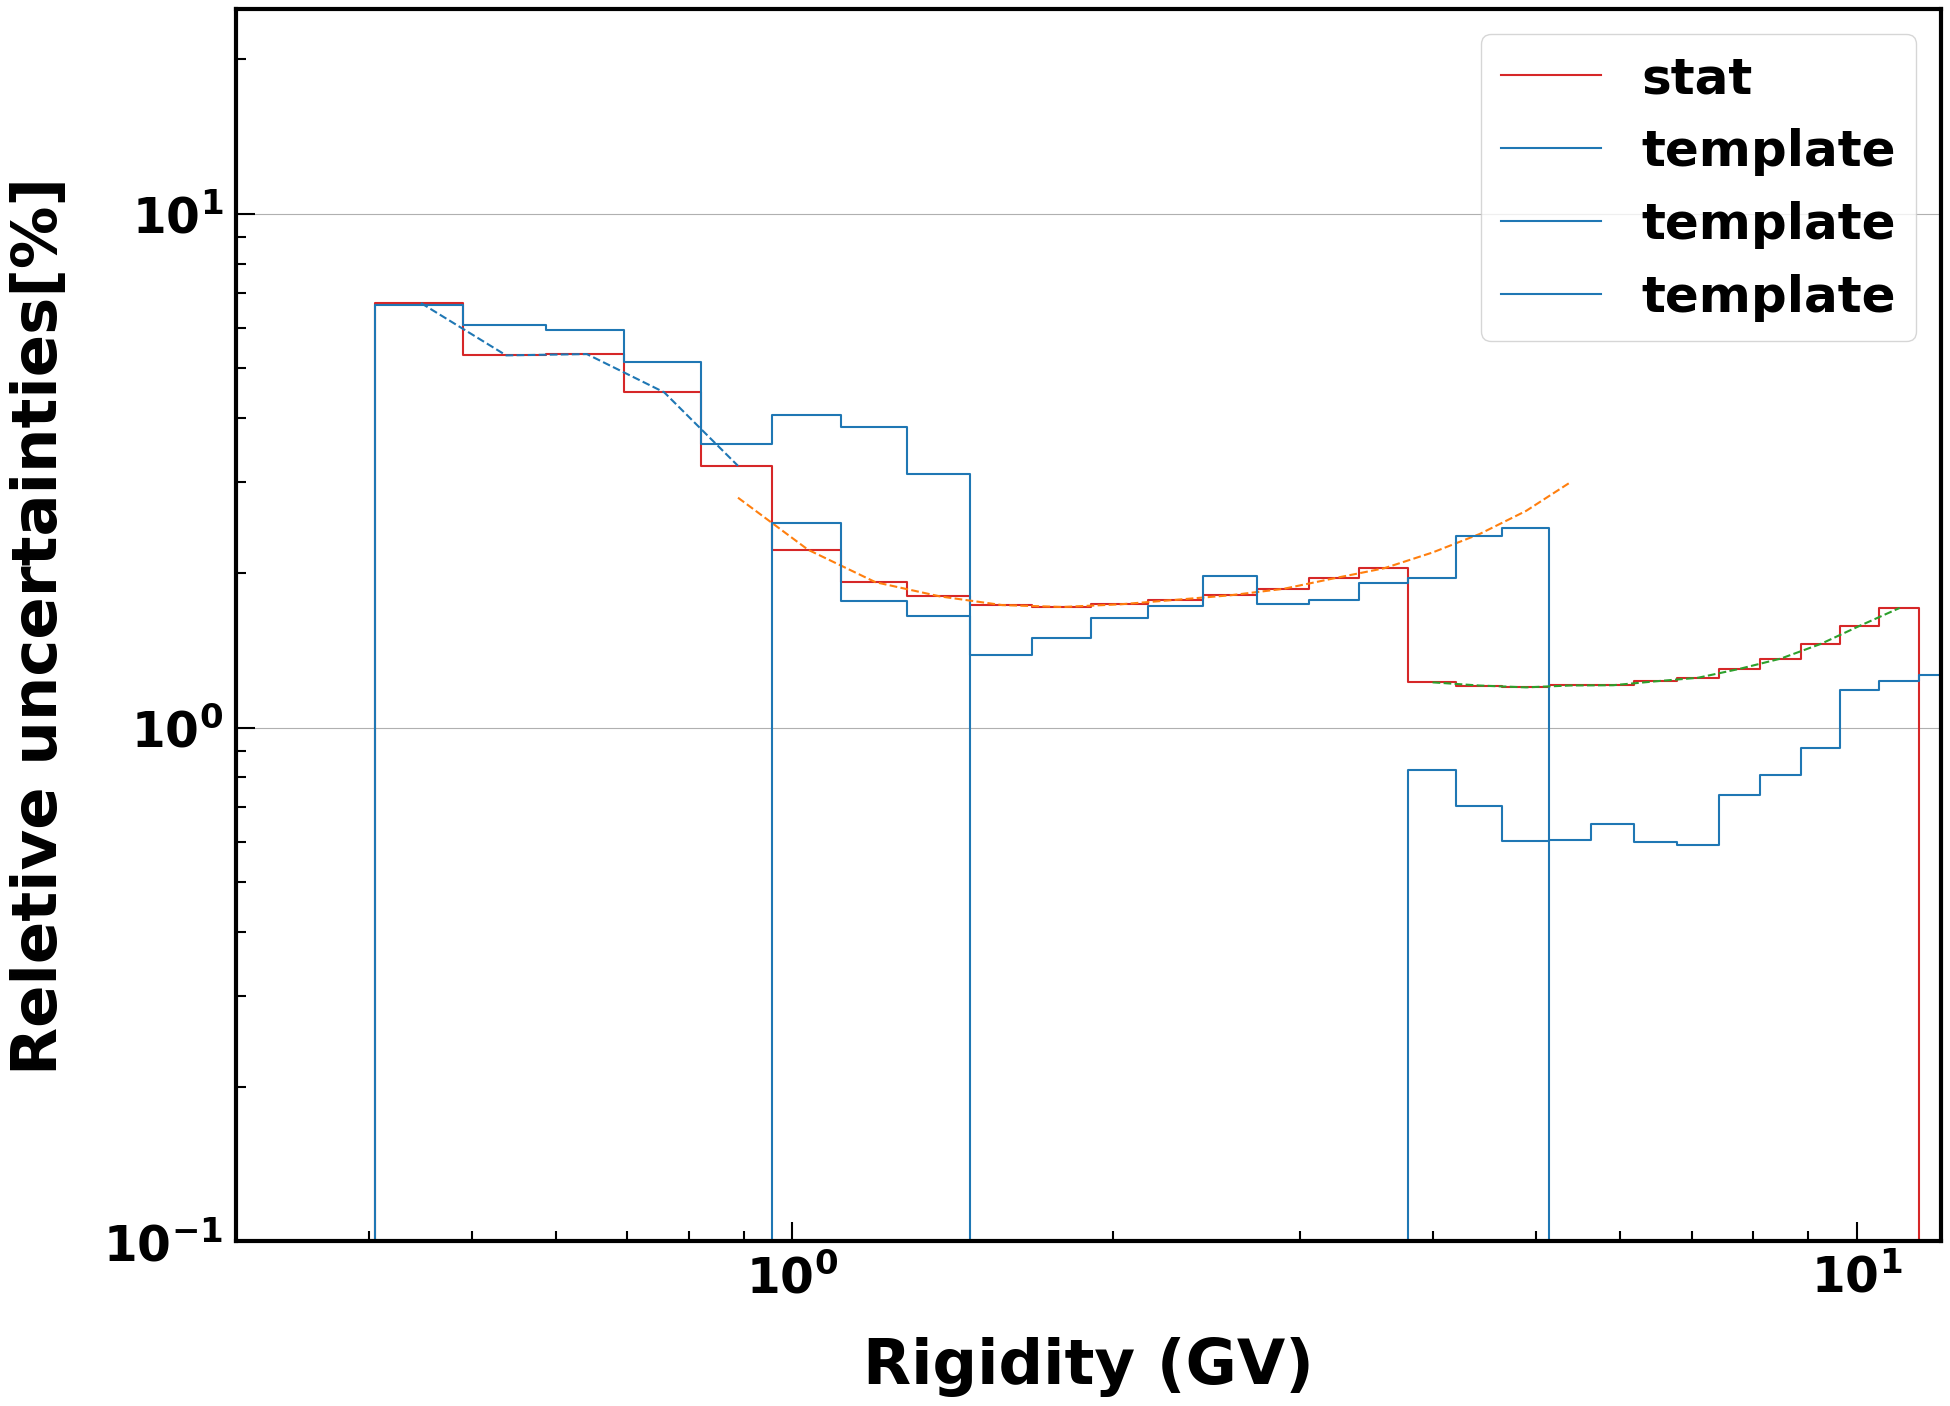

In [22]:
datadir_syserr = '/home/manbing/Documents/Data/data_LiP8/syserr_may'

graph_syserr_massid = {iso: {} for iso in ISOTOPES[nuclei]}
graph_syserr_massid_std = {iso: {} for iso in ISOTOPES[nuclei]}
graph_syserr_massid_std_alldec = {}
slicevalue = {'Tof': [0.4, 0.9], 'NaF': [1.0, 3.7], 'Agl':[4.2, 10.9]}

graph_countserr = {iso: {} for iso in isotopes}
graph_statserr = {iso: {} for iso in isotopes}
graph_countserr_alldec = {}
npzfile_countserr = np.load(os.path.join(datadir_syserr, 'graph_countserr_fromfit.npz'))
for iso in isotopes:
    for dec in detectors:    
        graph_syserr_massid[iso][dec] = MGraph(graph_ratio[iso][dec].xvalues, (graph_ratio[iso][dec].yvalues - 1)/2 * 100, graph_ratio[iso][dec].yerrs)
        graph_syserr_massid_std[iso][dec] = MGraph(graph_counts_max[iso][dec].xvalues, graph_counts_stderr[iso][dec].yvalues/(0.5*graph_counts_max[iso][dec].yvalues+0.5*graph_counts_min[iso][dec].yvalues ) * 100, np.zeros_like(graph_counts_max[iso][dec].xvalues))
        graph_syserr_massid_std[iso][dec] = slice_graph_by_value(graph_syserr_massid_std[iso][dec], slicevalue[dec])
        
        graph_countserr[iso][dec] = MGraph.from_file(npzfile_countserr, f'graph_statserr_{dec}{iso}') 
        graph_statserr[iso][dec] = MGraph.from_file(npzfile_countserr, f'graph_statserr_{dec}{iso}') 
        graph_countserr[iso][dec] = slice_graph_by_value(graph_countserr[iso][dec], slicevalue[dec])

for iso in isotopes:  
    graph_syserr_massid_std_alldec[iso] = concatenate_graphs(slice_graph_by_value(graph_relativeerr[iso]['Tof'], slicevalue['Tof']), slice_graph_by_value(graph_relativeerr[iso]['NaF'], slicevalue['NaF']))
    graph_syserr_massid_std_alldec[iso] = concatenate_graphs(graph_syserr_massid_std_alldec[iso], slice_graph_by_value(graph_relativeerr[iso]['Agl'], slicevalue['Agl']))
    
    graph_countserr_alldec[iso] = concatenate_graphs(graph_countserr[iso]['Tof'], graph_countserr[iso]['NaF'])
    graph_countserr_alldec[iso] = concatenate_graphs(graph_countserr_alldec[iso], graph_countserr[iso]['Agl'])
    graph_countserr_alldec[iso].yvalues = graph_countserr_alldec[iso].yvalues * 100
    
ysyserrlim = {'Li6': [0.03, 10], 'Li7':[0.1, 15]}

fig, ax1 = plt.subplots(1, 1, figsize=FIGSIZE3)
set_plot_style(ax1)
for iso in ['Li6']:
    plot_graph(fig, ax1, graph_countserr_alldec[iso], color='tab:red', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"stat")
    for dec in detectors:
        ax1.plot(graph_statserr[iso][dec].xvalues, graph_statserr[iso][dec].yvalues*100, '--')
        plot_graph(fig, ax1, graph_relativeerr[iso][dec], color=ISOTOPES_COLOR[iso], style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"template")
        print(graph_syserr_massid_std[iso][dec])
        #plot_graph(fig, ax1, graph_syserr_massid[iso][dec], color=DETECTOR_COLOR[dec], style="hist", xlog=False, ylog=False, scale=None, markersize=30 )
    SetAx1Axis(ax1, 'Rigidity (GV)', 'Reletive uncertainties[%]', 45, xlimrange=[0.3, 12], ylimrange=[0.1, 25], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=True, setxlog=True, setylog=True)

    ax1.legend()


28
[ 0.44778    0.538415   0.64103    0.757867   0.8890595  1.0347455
  1.197125   1.37623    1.574355   1.793835   2.03468    2.296845
  2.58267    2.894525   3.23237    3.598585   3.995585   4.423325
  4.891635   5.38565    5.90532    6.47534    7.095735   7.766505
  8.48763    9.259095  10.080855  10.97785  ]

xvalues			yvalues			yerrs
0.44778			3.2246904634021716			0.0
0.538415			2.328434352236131			0.0
0.64103			2.189160251021082			0.0
0.7578670000000001			1.6084352810100517			0.0
0.8890595			1.1818877545086204			0.0
1.0347455			0.7977816027732483			0.0
1.197125			0.8239273790954095			0.0
1.37623			0.761866111728487			0.0
1.574355			0.5187679388808067			0.0
1.793835			0.3502467569000163			0.0
2.03468			0.3002424498501929			0.0
2.2968450000000002			0.2730034115832157			0.0
2.5826700000000002			0.2819808382642748			0.0
2.894525			0.2840231954897235			0.0
3.23237			0.2539137022659827			0.0
3.598585			0.14343790713527754			0.0
3.995585			0.09936617568125014			0.0
4.423325			0.09924362

/home/manbing/Documents/lithiumanalysis/slides/plots_16May





/home/manbing/Documents/lithiumanalysis/slides/plots_16May


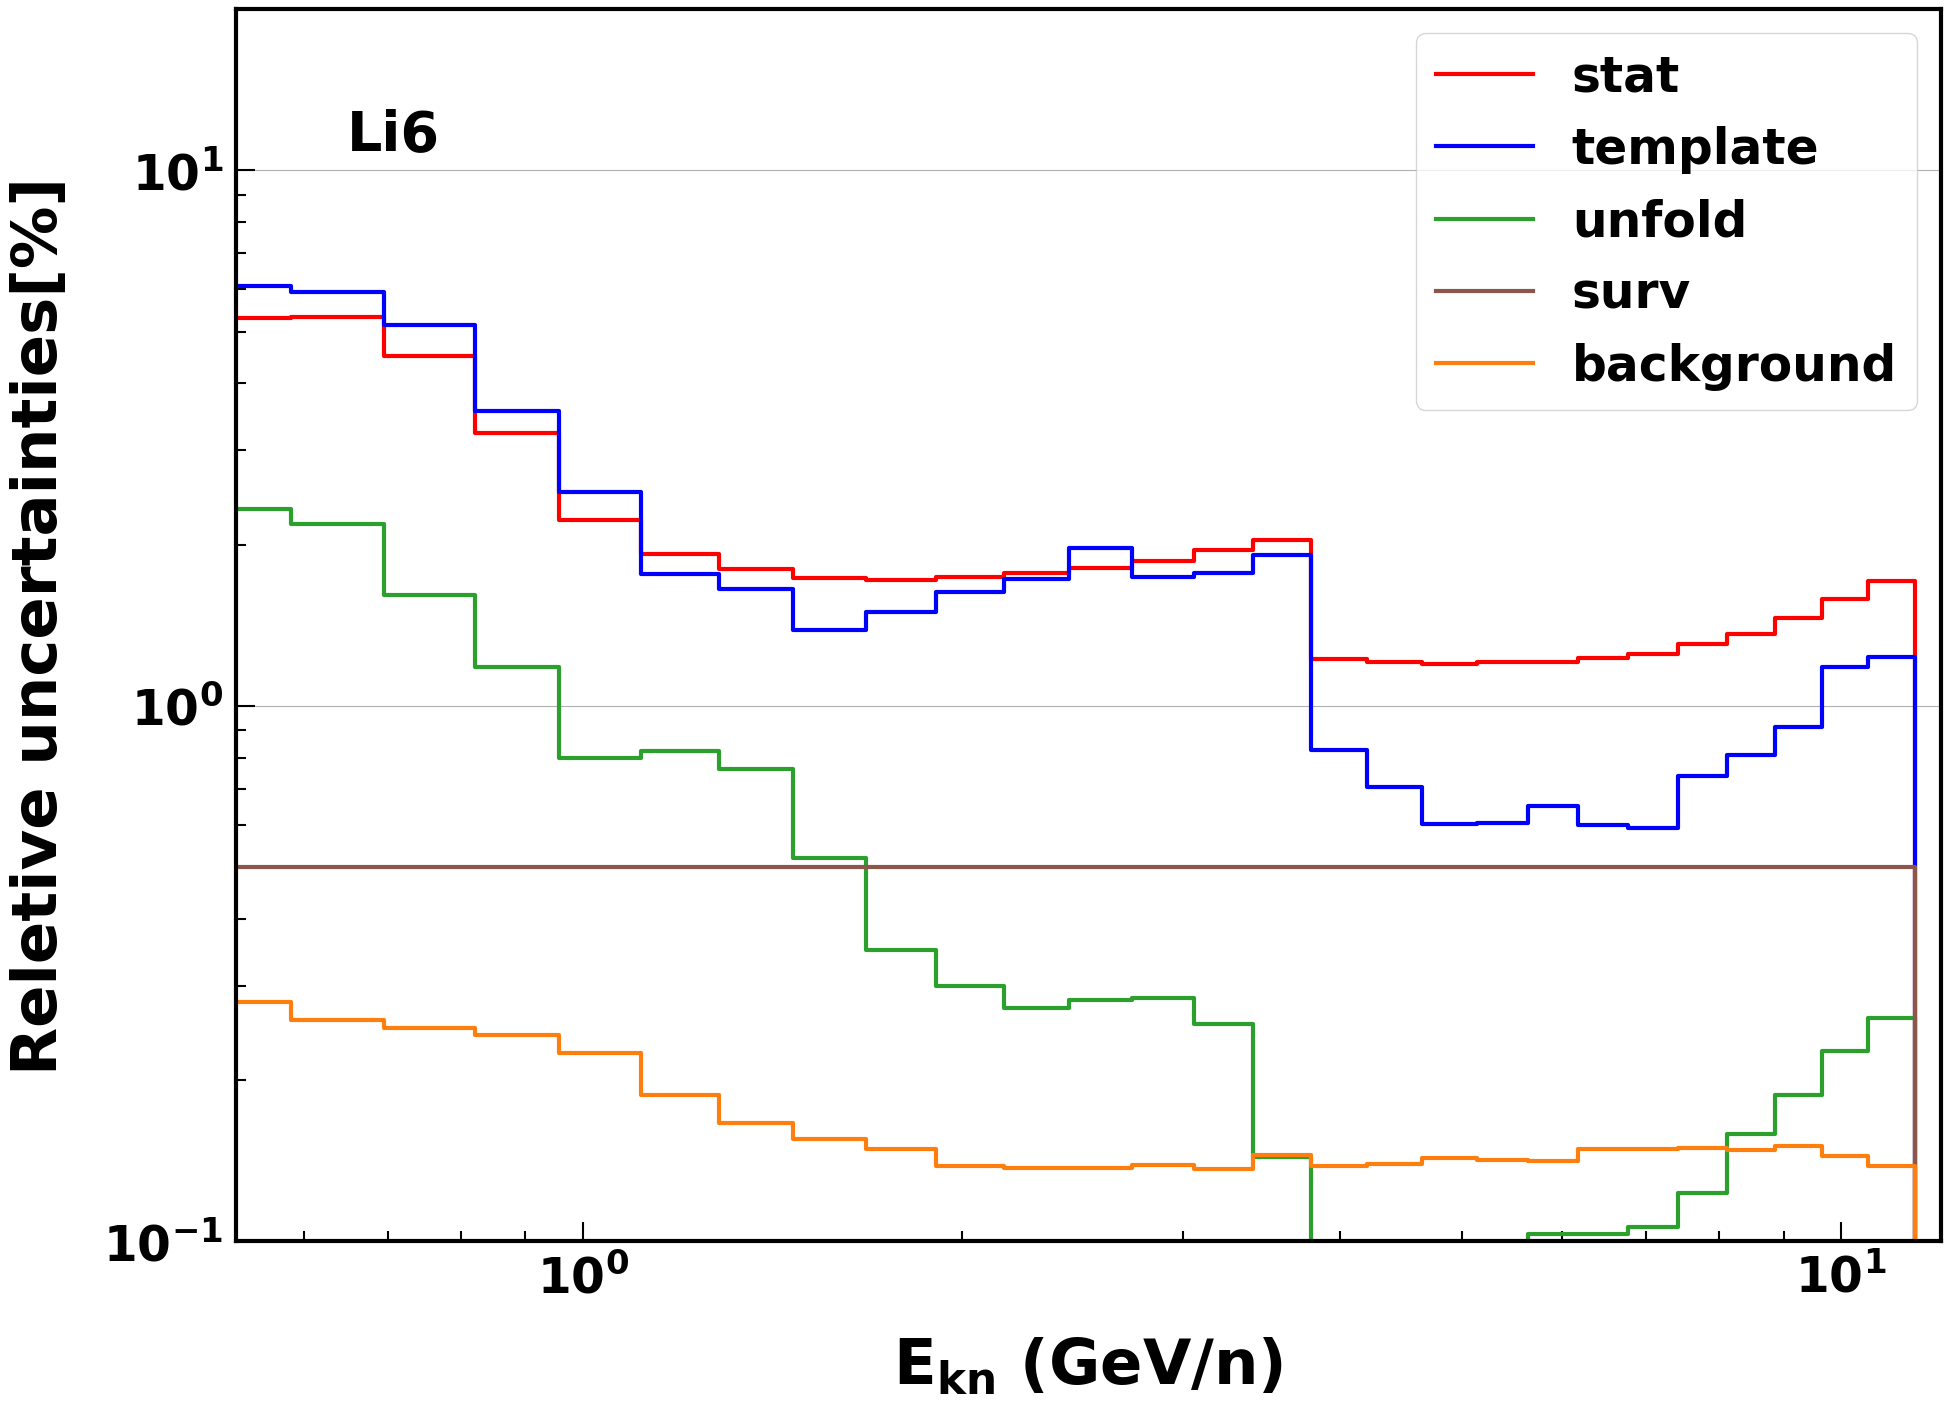

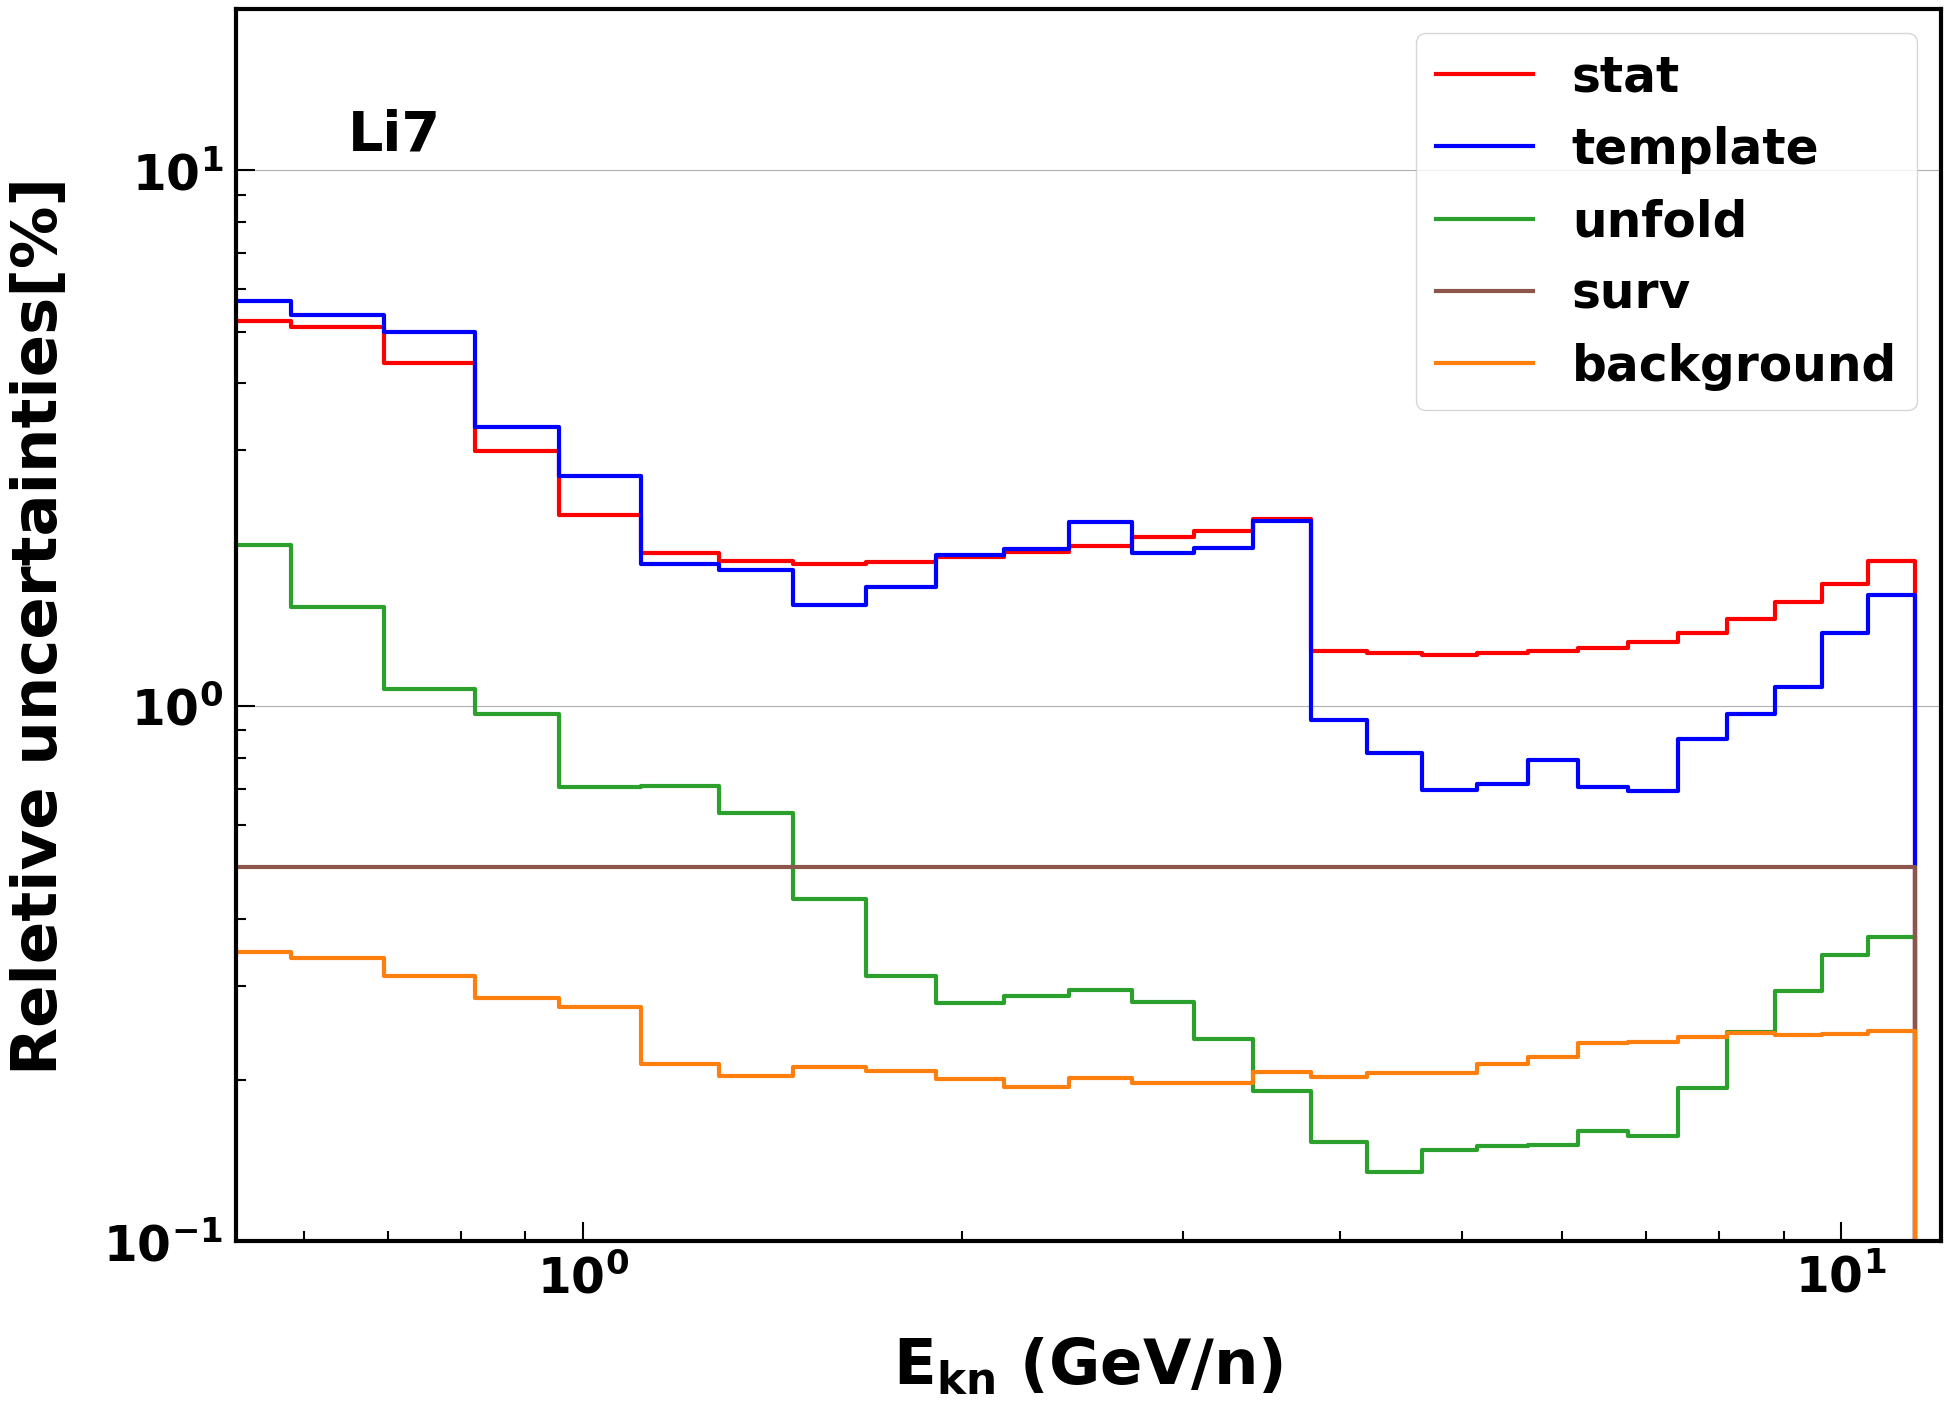

In [23]:
dict_massid_err = {}
dict_syserr = {}

datadir_syserr = '/home/manbing/Documents/Data/data_LiP8/syserr_may'
graph_surverr = {}
graph_bkgerr = {}
graph_unfolderr = {}


slicevalue=[0.4, 11]
ysyserrlim = {'Li6': [0.05, 10], 'Li7':[0.05, 10]}
graph_totalerr = {}

dict_syserr = {}

for iso in isotopes:
    xvalues = graph_countserr_alldec[iso].xvalues
    print(len(xvalues))
    print(xvalues)
    data_unfolderr = np.genfromtxt(os.path.join(datadir_syserr,f'{iso}_unfolderr.txt'), delimiter=' ')
    graph_unfolderr[iso] = MGraph(xvalues, data_unfolderr[:, 1], np.zeros_like(data_unfolderr[:, 0]))
    graph_unfolderr[iso] = slice_graph_by_value(graph_unfolderr[iso], slicevalue)
    print(graph_unfolderr[iso])
    #data_surverr = np.genfromtxt(os.path.join(datadir_syserr,f'{iso}surv_lau.csv'), delimiter=',')
    graph_surverr[iso] = MGraph(xvalues,  0.5 *  np.ones_like(xvalues), np.zeros_like(xvalues))
    graph_surverr[iso] = slice_graph_by_value(graph_surverr[iso], slicevalue)

    data_bkgerr = np.genfromtxt(os.path.join(datadir_syserr,f'{iso}_bkg.txt'), delimiter=',')
    graph_bkgerr[iso] = MGraph(xvalues,  data_bkgerr[:, 1], np.zeros_like(xvalues))
    graph_bkgerr[iso] = slice_graph_by_value(graph_bkgerr[iso], slicevalue)
    
    print(graph_syserr_massid_std_alldec[iso])
    print(graph_countserr_alldec[iso])
    print(len(graph_countserr_alldec[iso].yvalues), len(graph_syserr_massid_std_alldec[iso].yvalues), len(graph_unfolderr[iso].yvalues), len(graph_surverr[iso].yvalues), len(graph_bkgerr[iso].yvalues))
    totalerr = np.sqrt(graph_countserr_alldec[iso].yvalues**2 + graph_syserr_massid_std_alldec[iso].yvalues**2 + graph_unfolderr[iso].yvalues**2 + graph_surverr[iso].yvalues**2 + graph_bkgerr[iso].yvalues**2)
    graph_totalerr[iso] = MGraph(xvalues, totalerr, np.zeros_like(xvalues))
    
    print(graph_syserr_massid_std_alldec[iso])
    graph_unfolderr[iso].add_to_file(dict_syserr, f'graph_unfolderr_{iso}')
    graph_surverr[iso].add_to_file(dict_syserr, f'graph_surverr_{iso}')
    graph_bkgerr[iso].add_to_file(dict_syserr, f'graph_bkgerr_{iso}')
    graph_totalerr[iso].add_to_file(dict_syserr, f'graph_totalerr_{iso}')
    graph_countserr_alldec[iso].add_to_file(dict_syserr, f'graph_staterr_{iso}')
    graph_syserr_massid_std_alldec[iso].add_to_file(dict_syserr, f'graph_massiderr_{iso}')
    

#np.savez(os.path.join(datadir_syserr, f'graph_syserr.npz'), **dict_syserr)

for i , iso in enumerate(isotopes):
    fig, ax1 = plt.subplots(1, 1, figsize=FIGSIZE3)
    set_plot_style(ax1)
    #plot_graph(fig, ax1, graph_totalerr[iso], color='black', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"total", linewidth=3)
    plot_graph(fig, ax1, graph_countserr_alldec[iso], color='red', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"stat", linewidth=3)
    plot_graph(fig, ax1, graph_syserr_massid_std_alldec[iso], color='blue', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"template", linewidth=3)
    plot_graph(fig, ax1, graph_unfolderr[iso], color='tab:green', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"unfold", linewidth=3)
    plot_graph(fig, ax1, graph_surverr[iso], color='tab:brown', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"surv", linewidth=3)
    plot_graph(fig, ax1, graph_bkgerr[iso], color='tab:orange', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"background", linewidth=3)
        
        #plot_graph(fig, ax1, graph_syserr_massid[iso][dec], color=DETECTOR_COLOR[dec], style="hist", xlog=False, ylog=False, scale=None, markersize=30 )
        
    SetAx1Axis(ax1, r'$\mathrm{E_{kn}}$ (GeV/n)', 'Reletive uncertainties[%]', 45, xlimrange=[0.53, 12], ylimrange=ysyserrlim[iso], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=True, setxlog=True, setylog=False)
    ax1.legend(fontsize=35)
    plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots_16May'
    ax1.set_yscale('log')
    ax1.set_ylim([0.1, 20])
    ax1.text(0.12, 0.92, f'{iso}',  fontsize=40, verticalalignment='top', horizontalalignment='right', transform=ax1.transAxes, color="black", fontweight="bold")                
    savefig_tofile(fig, plotfile, f'{iso}flux_syserr_log', 1)
    print(plotfile)
#np.savez(os.path.join('/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitData_P811yr_rebin_notTofEdgeSysErr', 'graph_syserr_massid.npz'), **dict_massid_err)













/home/manbing/Documents/lithiumanalysis/slides/plots_16May


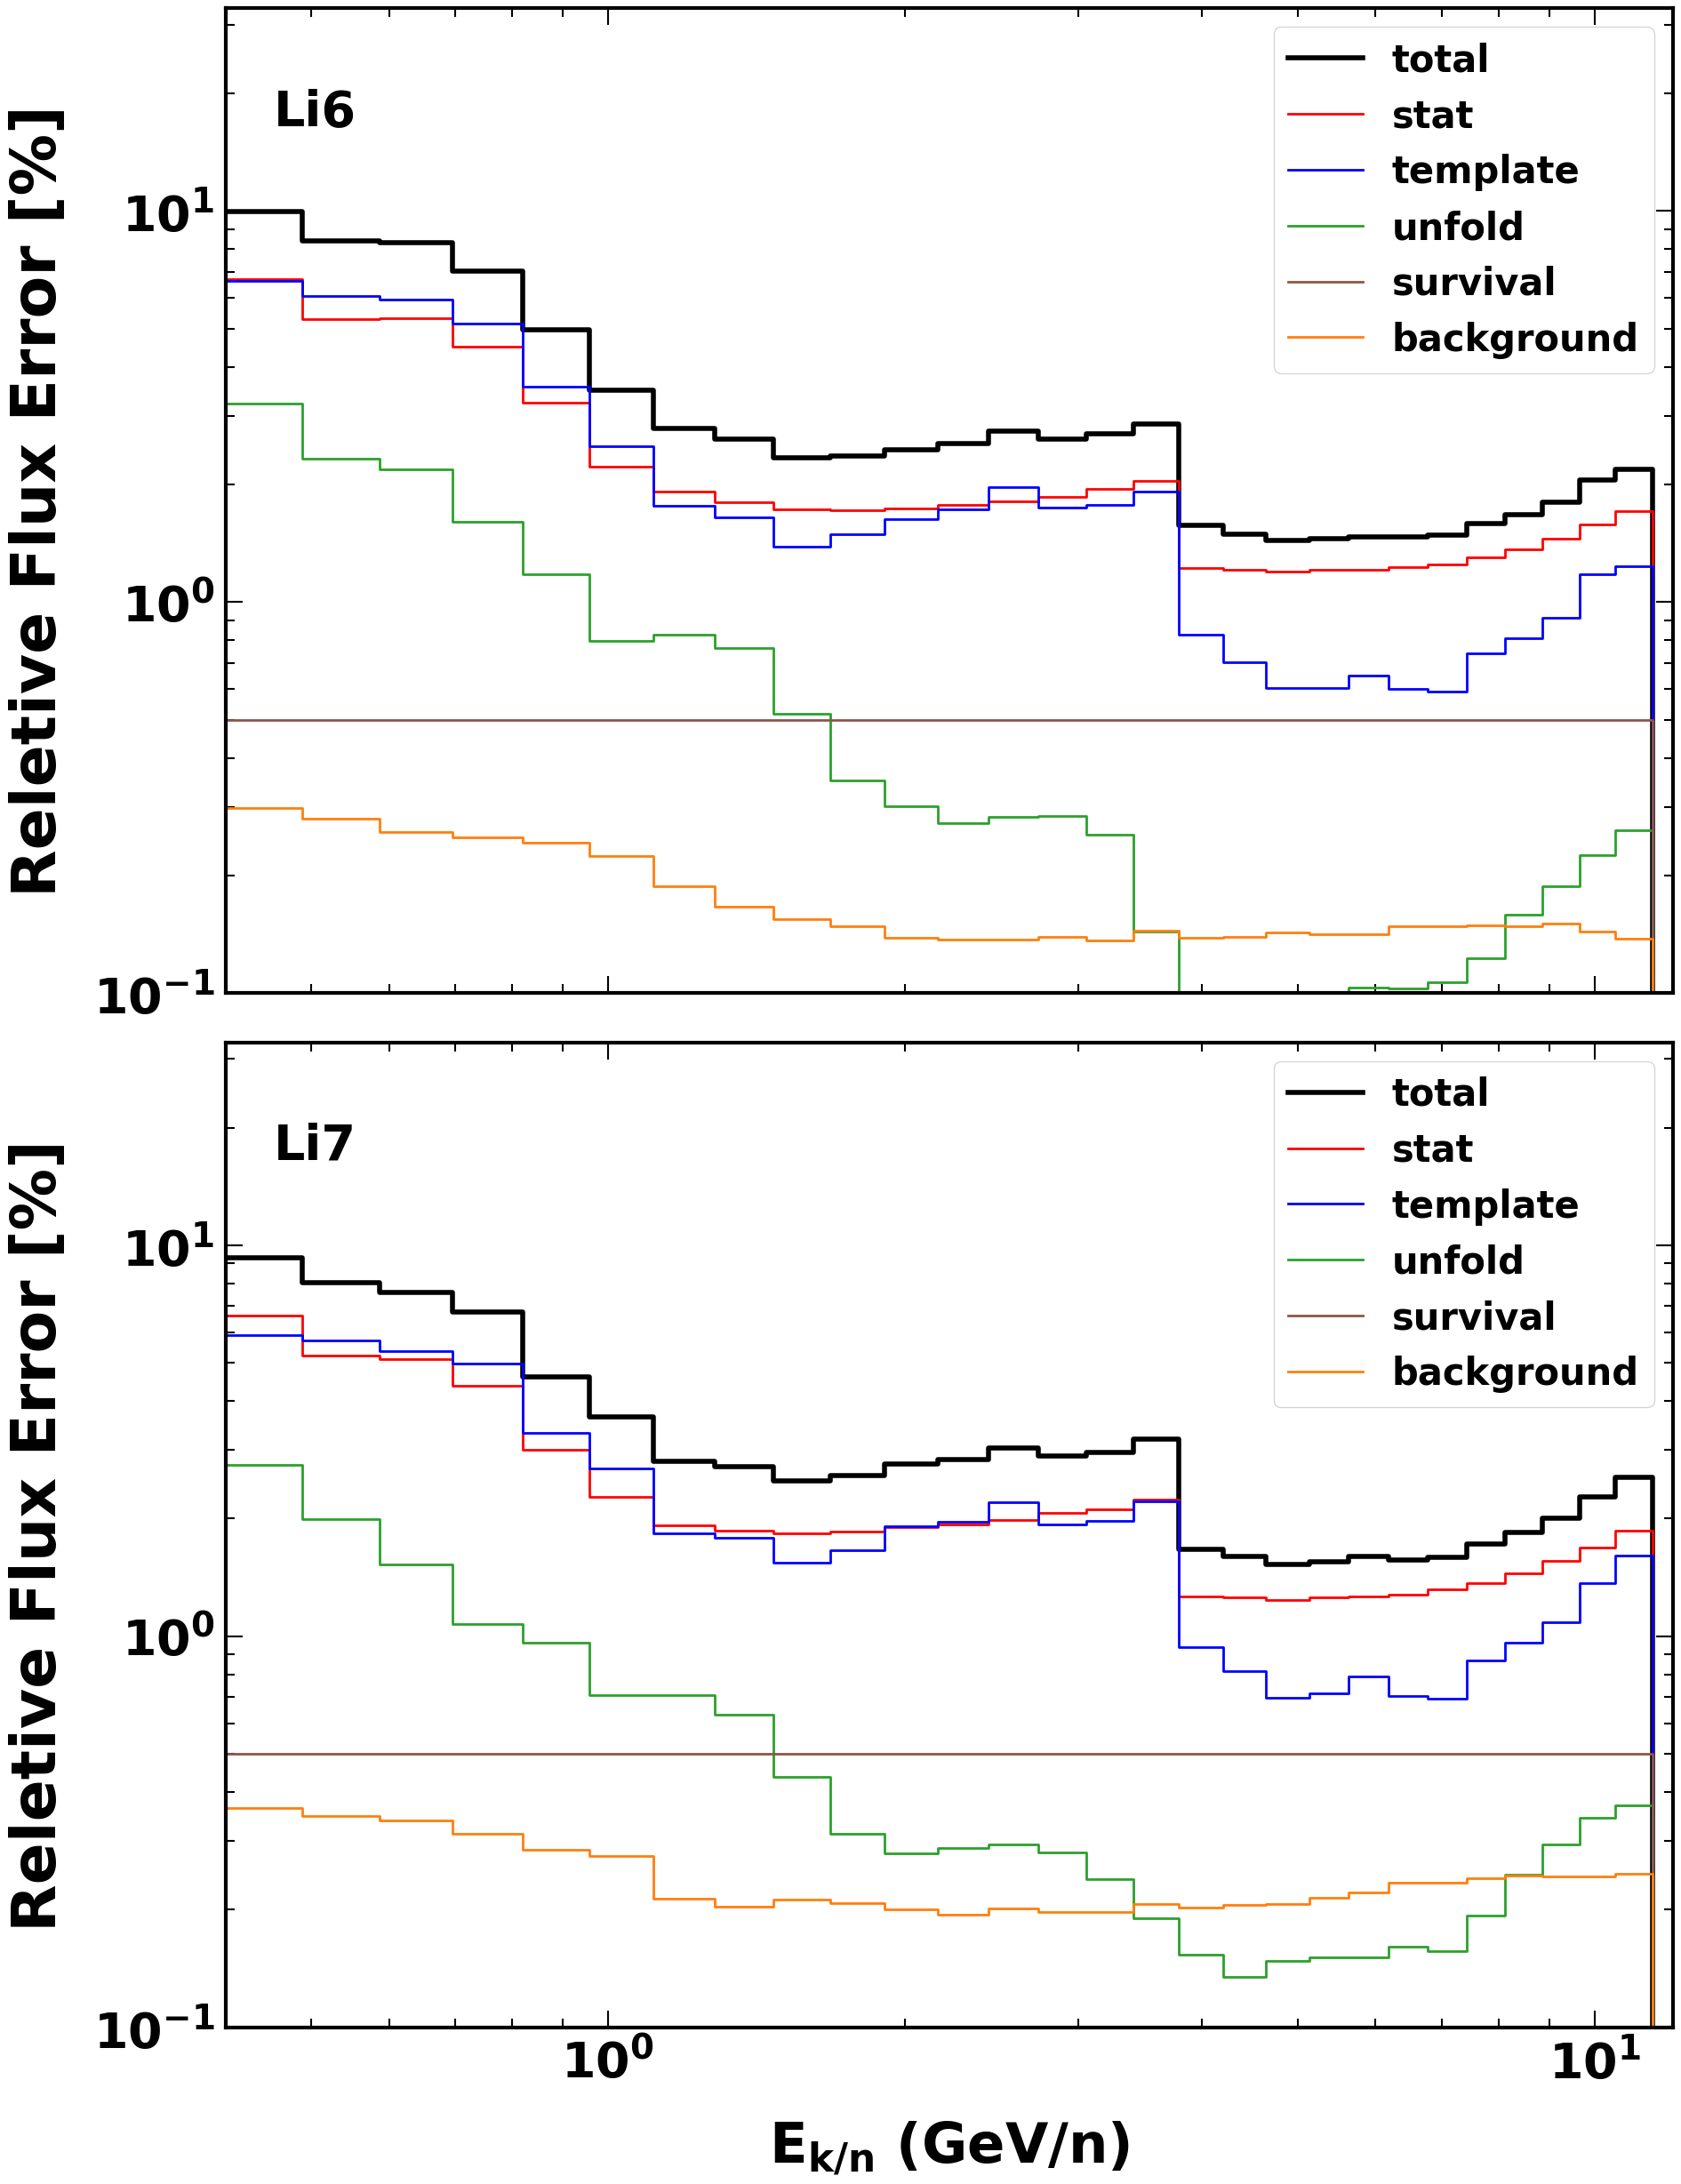

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(21, 29.5))
ax = [ax1, ax2]
ysyserrlim = {'Li6': [0.1, 33], 'Li7':[0.1, 33]}
for i, iso in enumerate(isotopes):
    set_plot_style(ax[i])
    plot_graph(fig, ax[i], graph_totalerr[iso], color='black', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"total", linewidth=4)
    plot_graph(fig, ax[i], graph_countserr_alldec[iso], color='red', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"stat" , linewidth=2)
    plot_graph(fig, ax[i], graph_syserr_massid_std_alldec[iso], color='blue', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"template", linewidth=2)
    plot_graph(fig, ax[i], graph_unfolderr[iso], color='tab:green', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"unfold", linewidth=2)
    plot_graph(fig, ax[i], graph_surverr[iso], color='tab:brown', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"survival" , linewidth=2)
    plot_graph(fig, ax[i], graph_bkgerr[iso], color='tab:orange', style="step", xbinning=xbinning_ekn, xlog=False, ylog=False, scale=None, markersize=30, label=f"background", linewidth=2)
    
        #plot_graph(fig, ax1, graph_syserr_massid[iso][dec], color=DETECTOR_COLOR[dec], style="hist", xlog=False, ylog=False, scale=None, markersize=30 )
    ax[i].legend(fontsize=30)  
    SetAx1Axis(ax[i], '', '' if i == 1 else None, 45, xlimrange=[0.41, 12], ylimrange=ysyserrlim[iso], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog=True, setylog=False)
    ax[i].text(0.09, 0.92, f'{iso}',  fontsize=40, verticalalignment='top', horizontalalignment='right', transform=ax[i].transAxes, color="black", fontweight="bold")                
ax2.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$")  
                                                                                                                                                                    
#ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
ax1.sharex(ax2)   

ax2.set_ylabel("Reletive Flux Error [%]", fontsize=50, labelpad=20) 
ax1.set_ylabel("Reletive Flux Error [%]", fontsize=50, labelpad=20) 
for label in ax1.get_xticklabels():
    label.set_visible(False)
# Repeat the process for ax2
set_plot_style(ax1)                                                                                                                                                                                 
set_plot_style(ax2)    
plt.subplots_adjust(hspace=.05)
ax1.set_yscale('log')
ax2.set_yscale('log')
#ax2.set_xticks([0.5, 1, 2, 5, 10])                                                                                                                                                                      
#ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())   
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots_16May'
savefig_tofile(fig, plotfile, 'Li_isoflux_syserr', 1)

print(plotfile)

#np.savez(os.path.join('/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitData_P811yr_rebin_notTofEdgeSysErr', 'graph_syserr_massid.npz'), **dict_massid_err)


xvalues			yvalues			yerrs
0.74265			0.40784285897109124			0.04791646236345317


xvalues			yvalues			yerrs
3.5736499999999998			0.46729181081475657			0.041832104314369
9.06515			0.5952566539571699			0.06375785083024985

/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso

xvalues			yvalues			yerrs
0.74265			0.5921571410289087			0.057665336586748224


xvalues			yvalues			yerrs
3.5736499999999998			0.5327081891852434			0.04530117956031368
9.06515			0.4047433460428301			0.0520906583898255

/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso


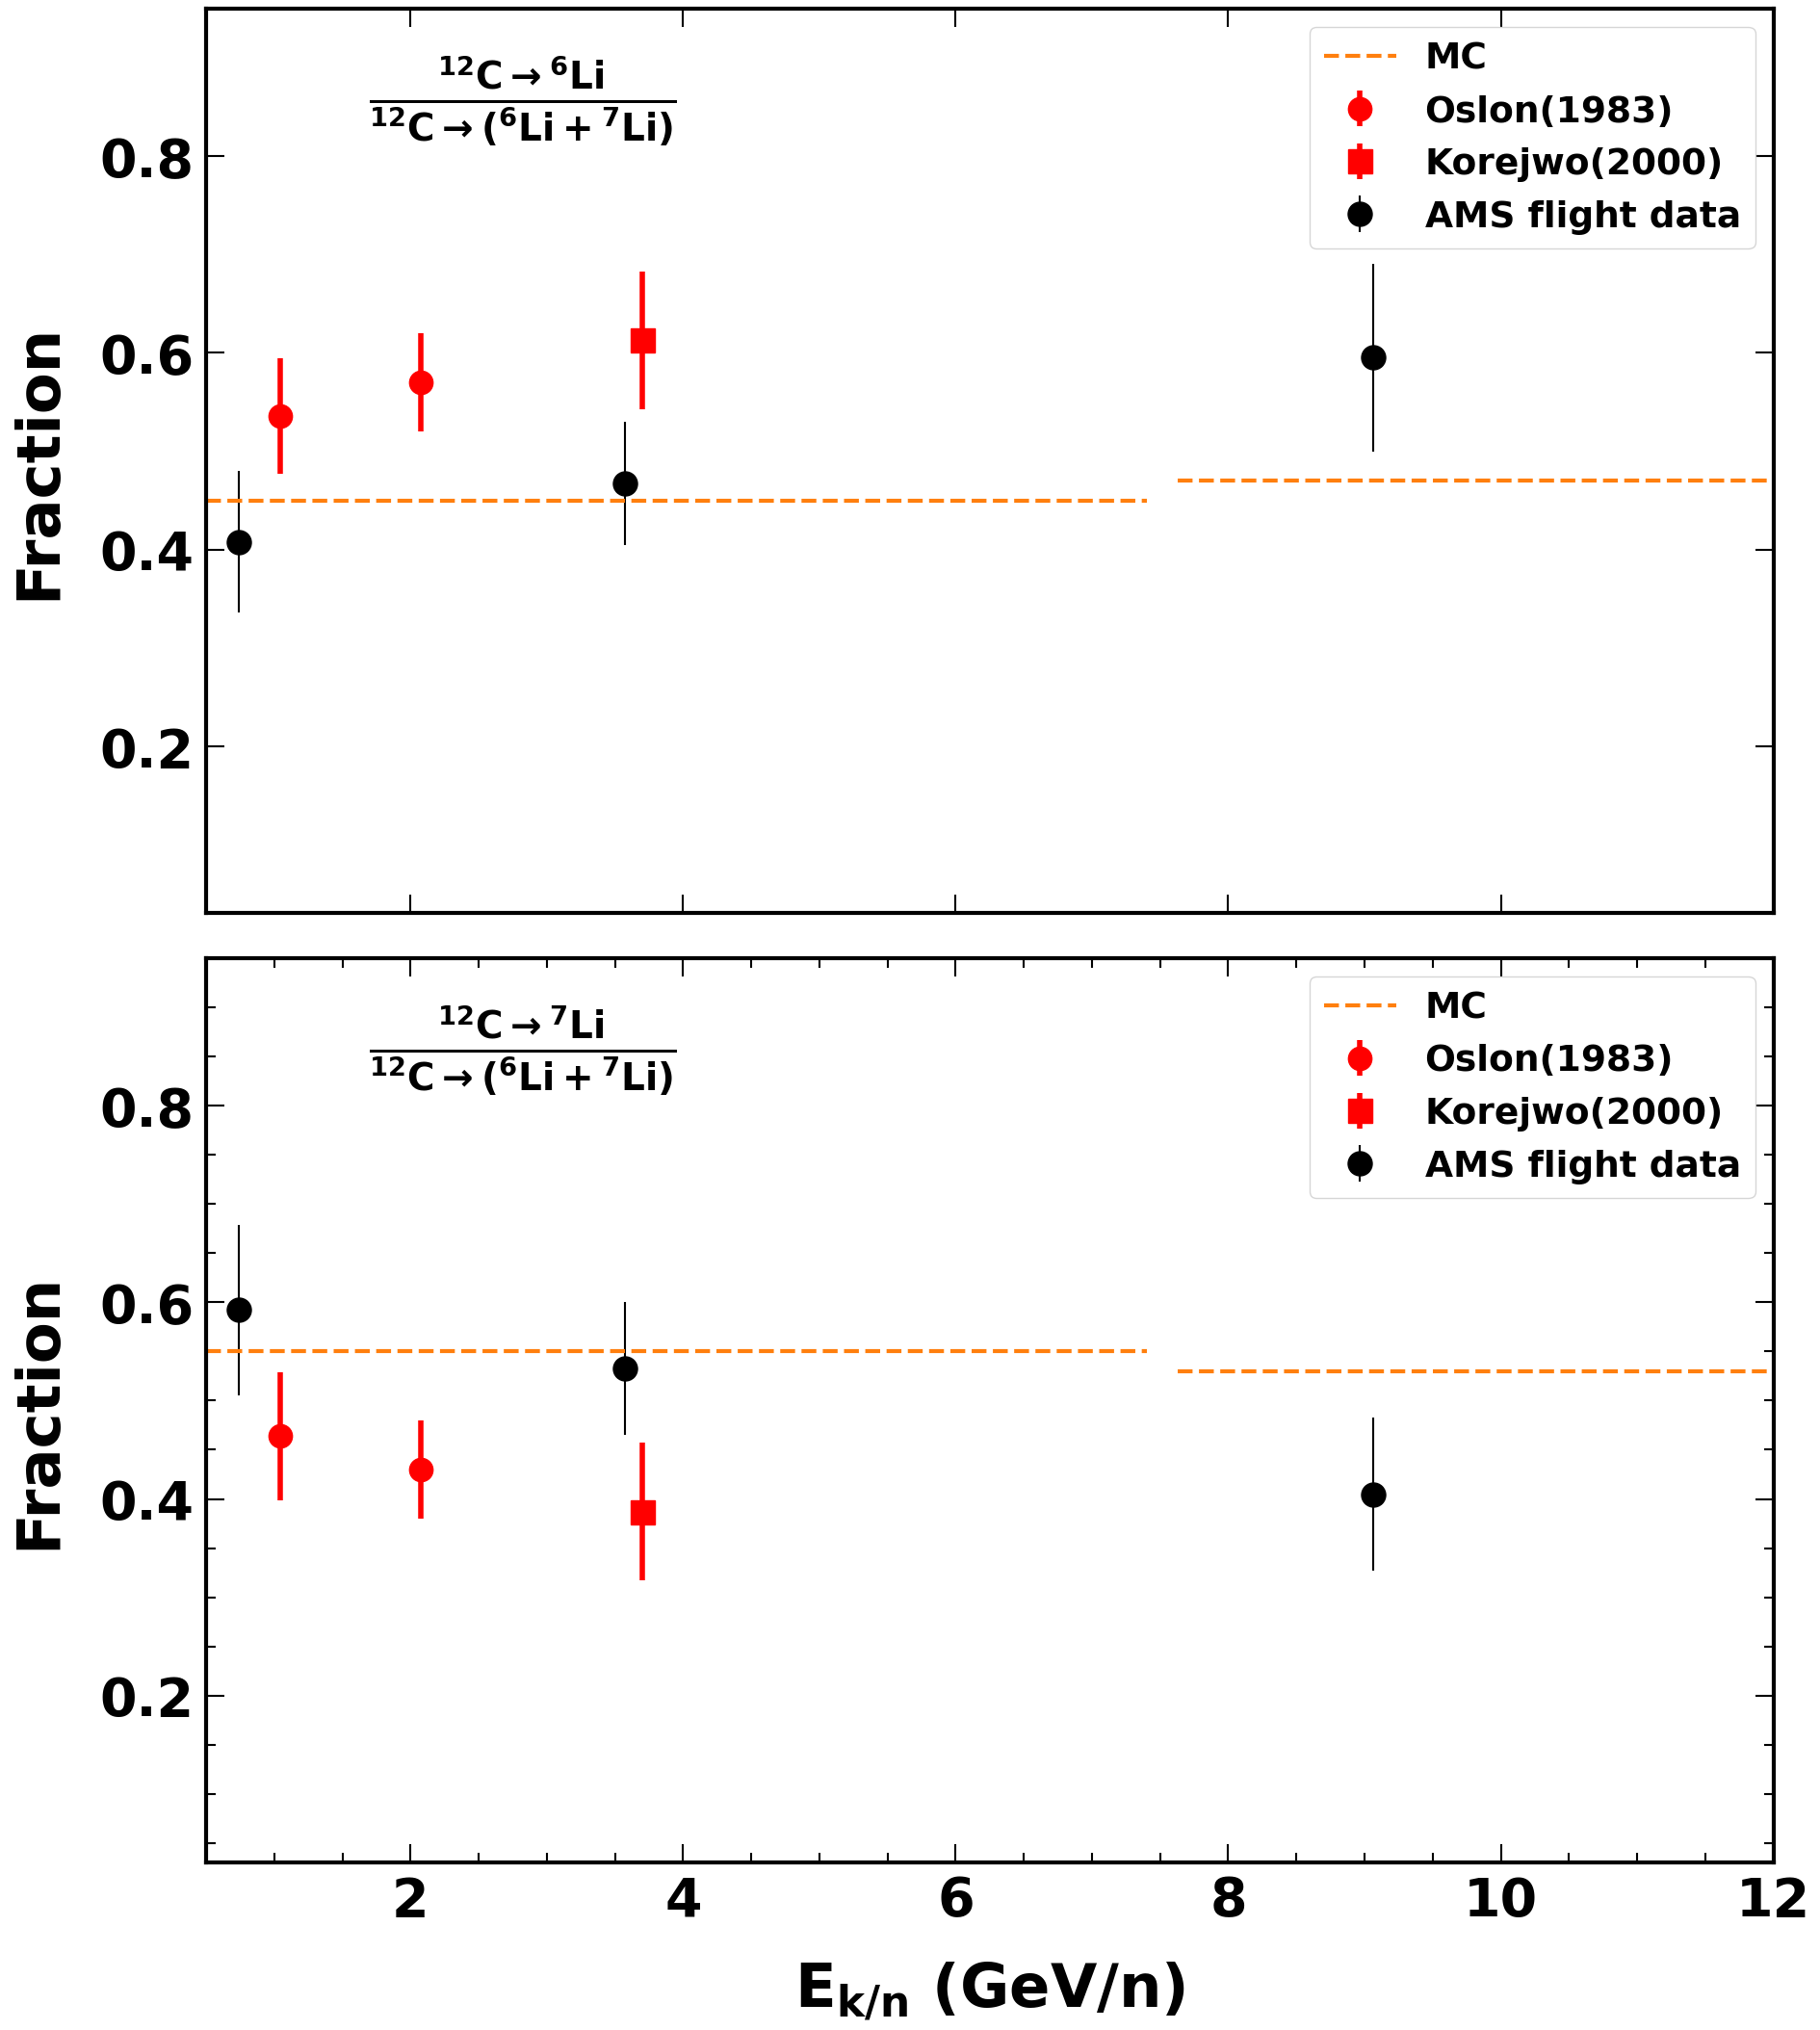

In [11]:
figsize1 = (21, 25)
fontsize1 = 45
fontsize2 = 55
mksize = 38
file_counts = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitData_CarbonToLi/graph_massfit_counts_carbonToLi.npz'

df_counts = np.load(f'{file_counts}')
#df_counts_compare = np.load(f'{filename_compare}')

figSize = (22, 15)
graph_counts_fromfit = {dec: {} for dec in detectors}
graph_counts_sum = dict()
graph_counts_compare = {dec: {} for dec in detectors}
graph_counts_sum_compare = dict()
hist_mass2d = {dec: {} for dec in detectors}
slicevalue = {'Tof': [0.4, 1.1], 'NaF': [2.0, 5.5], 'Agl':[4.0, 12.0]}
isonum = {'Li6': '6', 'Li7': '7'}
detectors = ['Tof',  'Agl']
for dec in detectors:
    for iso in isotopes:
        graph_counts_fromfit[dec][iso] = MGraph.from_file(df_counts, f"graph_counts_{dec}_{isonum[iso]}_0")
        #graph_counts_compare[dec][iso] = MGraph.from_file(df_counts_compare, f"graph_counts_{dec}OptBe7_{iso}")
        graph_counts_fromfit[dec][iso] = slice_graph_by_value(graph_counts_fromfit[dec][iso], slicevalue[dec])
     
        xstart = graph_counts_fromfit[dec][iso].xvalues[0]
        xend = graph_counts_fromfit[dec][iso].xvalues[-1]
        #graph_counts_compare[dec][iso] = slice_graph_by_value(graph_counts_compare[dec][iso] , np.array([xstart, xend]))
        if iso == "Li6":
            graph_counts_sum[dec] = graph_counts_fromfit[dec][iso]
            
        else:
            graph_counts_sum[dec] = graph_counts_sum[dec] + graph_counts_fromfit[dec][iso]

graph_counts_fraction = {dec: {} for dec in detectors}

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(21, 25))
ax = [ax1, ax2]
MCLine = {'Li6': [0.45, 0.47], 'Li7':[0.55, 0.53]}
    
graph_olson = {}
graph_kore ={}
graph_olson['Li6'] = MGraph([1.0437856190909964, 2.0742009456816], [0.536, 0.57],  [0.059, 0.05])
graph_olson['Li7'] = MGraph([1.0437856190909964, 2.0742009456816], [ 0.464 , 0.43],  [0.065, 0.05])
graph_kore['Li6'] = MGraph([3.698], [19.8/(19.8+12.5)], [0.07])
graph_kore['Li7'] = MGraph([3.698], [12.5/(19.8+12.5)], [0.07])

ax1.text(0.3, 0.95, r'$\frac{\mathrm{^{12}C\rightarrow^{6}Li}}{\mathrm{^{12}C\rightarrow(^{6}{Li}+^{7}{Li})}}$', fontsize=40, verticalalignment='top', horizontalalignment='right', transform=ax1.transAxes, color="black", fontweight="bold")   
ax2.text(0.3, 0.95, r'$\frac{\mathrm{^{12}C\rightarrow^{7}Li}}{\mathrm{^{12}C\rightarrow(^{6}{Li}+^{7}{Li})}}$', fontsize=40, verticalalignment='top', horizontalalignment='right', transform=ax2.transAxes, color="black", fontweight="bold")   
for i, iso in enumerate(isotopes):
    plot_graph(fig, ax[i], graph_olson[iso], color='red', style="EP", xlog=False, ylog=False, scale=None, markersize=35, label=f"Oslon(1983)", linewidth=4)
    plot_graph(fig, ax[i], graph_kore[iso], color='red', style="EP", xlog=False, ylog=False, scale=None, markersize=18, label=f"Korejwo(2000)", linewidth=4, marker='s')
    for dec in detectors:
        graph_counts_fraction[dec][iso] = graph_counts_fromfit[dec][iso]/graph_counts_sum[dec]
        print(graph_counts_fraction[dec][iso])
        graph_counts_fraction[dec][iso].yerrs *= 1.5
        plot_graph(fig, ax[i], graph_counts_fraction[dec][iso], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize-2, label=f'AMS flight data' if dec == 'Tof' else None)  
        
    ax[i].set_ylabel("Fraction", fontsize=40, labelpad=20) 
    ax[i].axhline(y=MCLine[iso][0], xmin=0, xmax=0.6,  color='tab:orange', linestyle='--', label='MC', linewidth=3)
    ax[i].axhline(y=MCLine[iso][1], xmin=0.62, xmax=1, color='tab:orange', linestyle='--', linewidth=3)
    SetAx1Axis(ax[i], '', f'Fraction', 45, xlimrange=[0.5, 12], ylimrange=[0.03, 0.95], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog=False, setylog=False)
    set_plot_style(ax[i])
    ax[i].legend(fontsize=27)
    ax2.set_xlabel(r'$\mathrm{E_{k/n} \ (GeV/n)}$')
    
               
    for label in ax1.get_xticklabels():
        label.set_visible(False)
    plt.subplots_adjust(hspace=.05)
    print(plotfile)
    savefig_tofile(fig, plotfile, f"counts_fraction_CarbonToLi", show=True)



In [12]:
import ROOT
from ROOT import TFile, TH2F, TH1D, TCanvas, gROOT

# Load the PyROOT C++ extension in the notebook
gROOT.SetBatch(ROOT.kTRUE)

# Open the ROOT file
infile_RTI = TFile("/home/manbing/Documents/phdthesis/RTIcut.root", "READ")

# Get the 2D histogram
hRcut2D = infile_RTI.Get("hRcutAcc")

# Project 2D histogram to get 1D histogram
hRcut1D = hRcut2D.ProjectionY("hRcut1D")

# Normalize the histogram
hRcut1D.Scale(1.0 / hRcut1D.Integral())

# Create a canvas
canvas = TCanvas("canvas", "hRcut1D Canvas", 800, 600)

# Draw the 1D histogram
hRcut1D.Draw()

# Optionally, customize the histogram appearance
hRcut1D.SetTitle("hRcut1D")
hRcut1D.GetXaxis().SetTitle("X-axis label")
hRcut1D.GetYaxis().SetTitle("Y-axis label")

# Update the canvas
canvas.Draw()

Welcome to JupyROOT 6.26/10


0.009936730409466351
/home/manbing/Documents/lithiumanalysis/slides/plots/Plots_Thesis_Chap6_LiIso


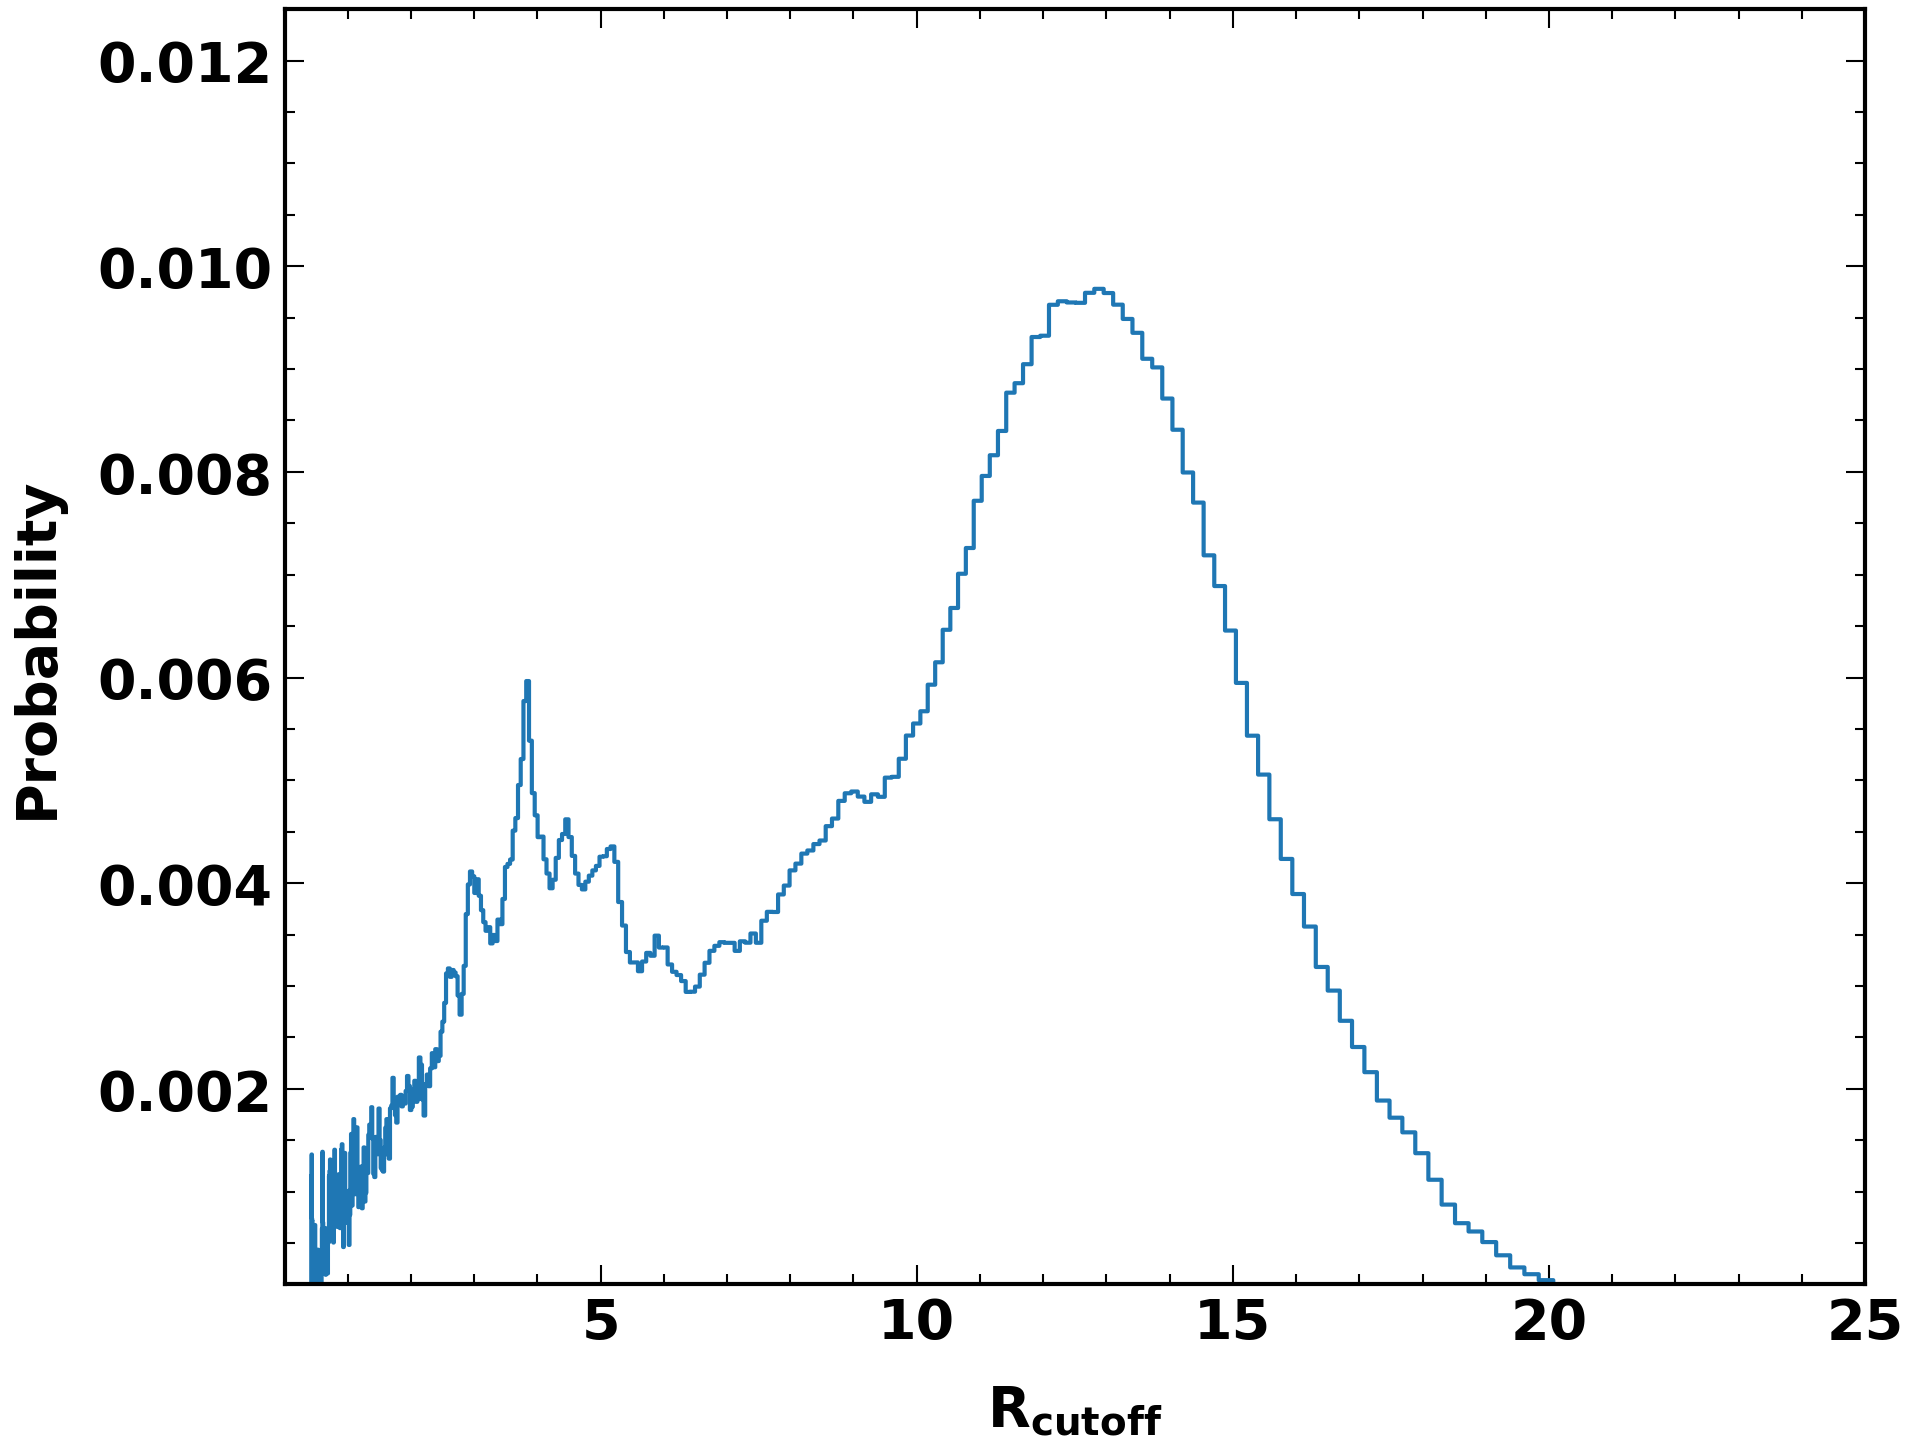

In [13]:
import ROOT
import matplotlib.pyplot as plt

# Open the ROOT file
infile_RTI = ROOT.TFile("/home/manbing/Documents/phdthesis/RTIcut.root", "READ")

# Get the 2D histogram
hRcut2D = infile_RTI.Get("hRcutAcc")

# Project 2D histogram to get 1D histogram
hRcut1D = hRcut2D.ProjectionY("hRcut1D")

# Normalize the histogram
hRcut1D.Scale(1.0 / hRcut1D.Integral())

# Convert ROOT histogram to numpy array
bin_edges = [hRcut1D.GetBinLowEdge(i) for i in range(1, hRcut1D.GetNbinsX() + 2)]
bin_values = [hRcut1D.GetBinContent(i) for i in range(1, hRcut1D.GetNbinsX() + 2)]
print(max(bin_values))
#bin_values[bin_values==0.009936730409466351]  = 0.009
# Plot the histogram using matplotlib
max_bin_index = bin_values.index(max(bin_values))
# Change the value of the maximum bin to 0.009
bin_values[max_bin_index] = 0.00978
fig = plt.figure(figsize=(20, 15))
plot = fig.subplots(1, 1) 
set_plot_style(plot)
SetAx1Axis(plot, r'$\mathrm{R_{cutoff}}$' , 'Probability', 40, xlimrange=[0.01, 25], ylimrange=[0.0001, 0.0125], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog=False, setylog=False)
plot.step(bin_edges, bin_values, where='mid', linewidth=3)
print(plotfile)

fig.subplots_adjust(left= 0.16, right=0.95, bottom=0.1, top=0.95)
savefig_tofile(fig, plotfile, f"R_cutoff_probability", show=True)

In [14]:
filename = "/home/manbing/Documents/Data/data_LiP8/Hist2D/LiMC_histmass_jiahuicommsel_reweight.npz"
massfile = np.load(filename)
nuclei = 'Li'
OpIso = 'Li6'
hist2d_mass_energy = {}
detectors_energyrange = {"Tof": [0.45, 1.3], "NaF": [1.0, 4.5], "Agl": [3.5, 12]}
for dec in detectors: 
    hist2d_mass_energy[dec] = Histogram.from_file(massfile, f"Li6MC_{dec}_mass")
    fig = plt.figure(figsize=(20, 15))                                                                       
    plot = fig.subplots(1, 1)  
    set_plot_style(ax1)
    plot2dhist(fig, plot, xbinning=hist2d_mass_energy[dec].binnings[0].edges[1:-1],                   
               ybinning=hist2d_mass_energy[dec].binnings[1].edges[1:-1],                              
               counts=hist2d_mass_energy[dec].values[1:-1, 1:-1],                                    
               xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None,                              
               setlogx=False, setlogy=False, setscilabelx=True, setscilabely=True,  setlogz=False)         
    #plot.text(0.05, 0.98, f"{dec}", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")                                            
    plot.set_ylabel("1/m (1/GeV)", fontsize=40)                                                           
    plot.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$", fontsize=40)                                                           
    plot.set_xlim(detectors_energyrange[dec])  
    print(plotfile)
    savefig_tofile(fig, plotfile, f"hist_ISS_mass_OpLi6_{dec}", show=True) 
    
ibin = 2
decA = 'Tof'
hist1dmass = hist2d_mass_energy[decA].project(ibin)
print(hist2d_mass_energy[decA].binnings[0].edges[ibin], hist2d_mass_energy[decA].binnings[0].edges[ibin+1])
fig = plt.figure(figsize=(20, 15))
plot = fig.subplots(1, 1) 
set_plot_style(plot)

plot_histogram_1d(plot, hist1dmass, style="iss", color="black", label="Li Data", scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False, markersize=23)
SetAx1Axis(plot, '1/m (GeV/n)', 'Events', 45, xlimrange=[0.05, 0.28], ylimrange=None, custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
plot.text(0.05, 0.98, r"$\mathrm{E_{k/n}: [4.91, 5.98]}$", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")                                            
plot.legend()
savefig_tofile(fig, plotfile, f"hist1d_ISS_mass_Agl", show=True) 

FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/Data/data_LiP8/Hist2D/LiMC_histmass_jiahuicommsel_reweight.npz'

In [27]:
import pandas as pd
filename = '/home/manbing/Documents/Data/data_LiP8/Li_results/crdb_li6li7ratio.csv'
df_ratio = pd.read_csv(filename, comment='#', header=None)
df_ratio['toterr'] = np.sqrt(df_ratio.iloc[:, 7]**2 + df_ratio.iloc[:, 9]**2)
df_ratio = df_ratio.rename(columns={6: 'ratio'})
df_ratio.head()
    

0         1    2      3      4      5     ratio         7         8  \
0  7Li/6Li  ACE-CRIS  EKN  0.066  0.066  0.066  0.806452  0.073428  0.073428   
1  7Li/6Li  ACE-CRIS  EKN  0.082  0.082  0.082  1.086957  0.141263  0.141263   
2  7Li/6Li  ACE-CRIS  EKN  0.095  0.095  0.095  1.041667  0.124331  0.124331   
3  7Li/6Li  ACE-CRIS  EKN  0.107  0.107  0.107  0.952381  0.103661  0.103661   
4  7Li/6Li  ACE-CRIS  EKN  0.119  0.119  0.119  1.020408  0.138123  0.138123   

     9   10                   11     12  13  \
0  0.0  0.0  2006AdSpR..38.1558D  608.5   1   
1  0.0  0.0  2006AdSpR..38.1558D  608.5   1   
2  0.0  0.0  2006AdSpR..38.1558D  608.5   1   
3  0.0  0.0  2006AdSpR..38.1558D  608.5   1   
4  0.0  0.0  2006AdSpR..38.1558D  608.5   1   

                                    14  15    toterr  
0  1998/01/01-000000:1999/01/23-000000   0  0.073428  
1  1998/01/01-000000:1999/01/23-000000   0  0.141263  
2  1998/01/01-000000:1999/01/23-000000   0  0.124331  
3  1998/01/01-000000:1999/01/23-000000   0  0.103661  
4  1998/01/01-000000:1999/01/23-000000   0  0.138123

In [28]:
# Define a custom aggregation function to aggregate multiple columns into NumPy arrays
def aggregate_to_arrays(group):
    return pd.Series({
        'xvalues': np.array(group.iloc[:, 3]),
        'yvalues': np.array(group.iloc[:, 6]),
        'yerrs': np.array(group.iloc[:, 16])
    })

# Group by column 1 and aggregate values from columns 3, 6, and 16 into lists

grouped = df_ratio.groupby(1).apply(aggregate_to_arrays).reset_index()

grouped['marker'] = ['+', 'x','D' , 'o','s','v', 'p', '*']
graph_ex_others = {}
display(grouped)
for index, row in grouped.iterrows():
    # Create an instance of MGraph using arrays from the current row
    graph_ex_others[row.iloc[0]] = MGraph(row['xvalues'], row['yvalues'], row['yerrs'])
    

# Save the grouped DataFrame to a new CSV file
grouped.to_csv('grouped_data.csv', index=False)




1                                            xvalues  \
0     ACE-CRIS  [0.0659999996423721, 0.0820000022649765, 0.094...   
1        AMS01                               [0.5291500091552734]   
2  Balloon UNH           [0.1815000027418136, 0.2469000071287155]   
3       IMP7&8                               [0.0680000036954879]   
4       ISOMAX            [0.357926994562149, 0.9118509888648988]   
5  PAMELA-CALO  [0.2291290014982223, 0.3446390032768249, 0.446...   
6   PAMELA-TOF  [0.1591850072145462, 0.2058009952306747, 0.229...   
7     SMILI-II                               [0.4120000004768371]   

                                             yvalues  \
0  [0.8064516067008695, 1.086956502021148, 1.0416...   
1                               [1.0964912274968774]   
2           [0.8600000143051147, 1.1399999856948853]   
3                                 [0.96078435039117]   
4             [1.14900004863739, 0.9300000071525574]   
5  [0.949999988079071, 1.0099999904632568, 1.1599...   
6  [1.0800000429153442, 1.0800000429153442, 0.959...   
7                               [1.1699999570846558]   

                                               yerrs marker  
0  [0.073428215193903, 0.14126324460833, 0.124330...      +  
1                                  [0.1186473413609]      x  
2              [0.11999999731779, 0.079999998211861]      D  
3                                 [0.10876558228004]      o  
4         [0.18645375349309504, 0.15393829301590337]      s  
5  [0.20223748700935462, 0.2102379597925599, 0.20...      v  
6  [0.25059927939192084, 0.20591260979586865, 0.2...      p  
7                                 [0.30000001192093]      *

/tmp/ipykernel_188193/3799936523.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_mb = pd.read_csv(manbing_results, delimiter=', ', header=None, comment='#')
/tmp/ipykernel_188193/3799936523.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_glap_opt12_usine = pd.read_csv(glap_opt12_usine, delimiter='   ', header=None, comment='#')
/tmp/ipykernel_188193/3799936523.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engi

        0       1         2         3
0  0.4062  0.4909  1.028542  0.096740
1  0.4909  0.5876  1.026752  0.076481
2  0.5876  0.6964  1.058822  0.078187
3  0.6964  0.8215  1.043837  0.065366
4  0.8215  0.9589  1.019592  0.039700
/home/manbing/Documents/lithiumanalysis/slides/plots_16May


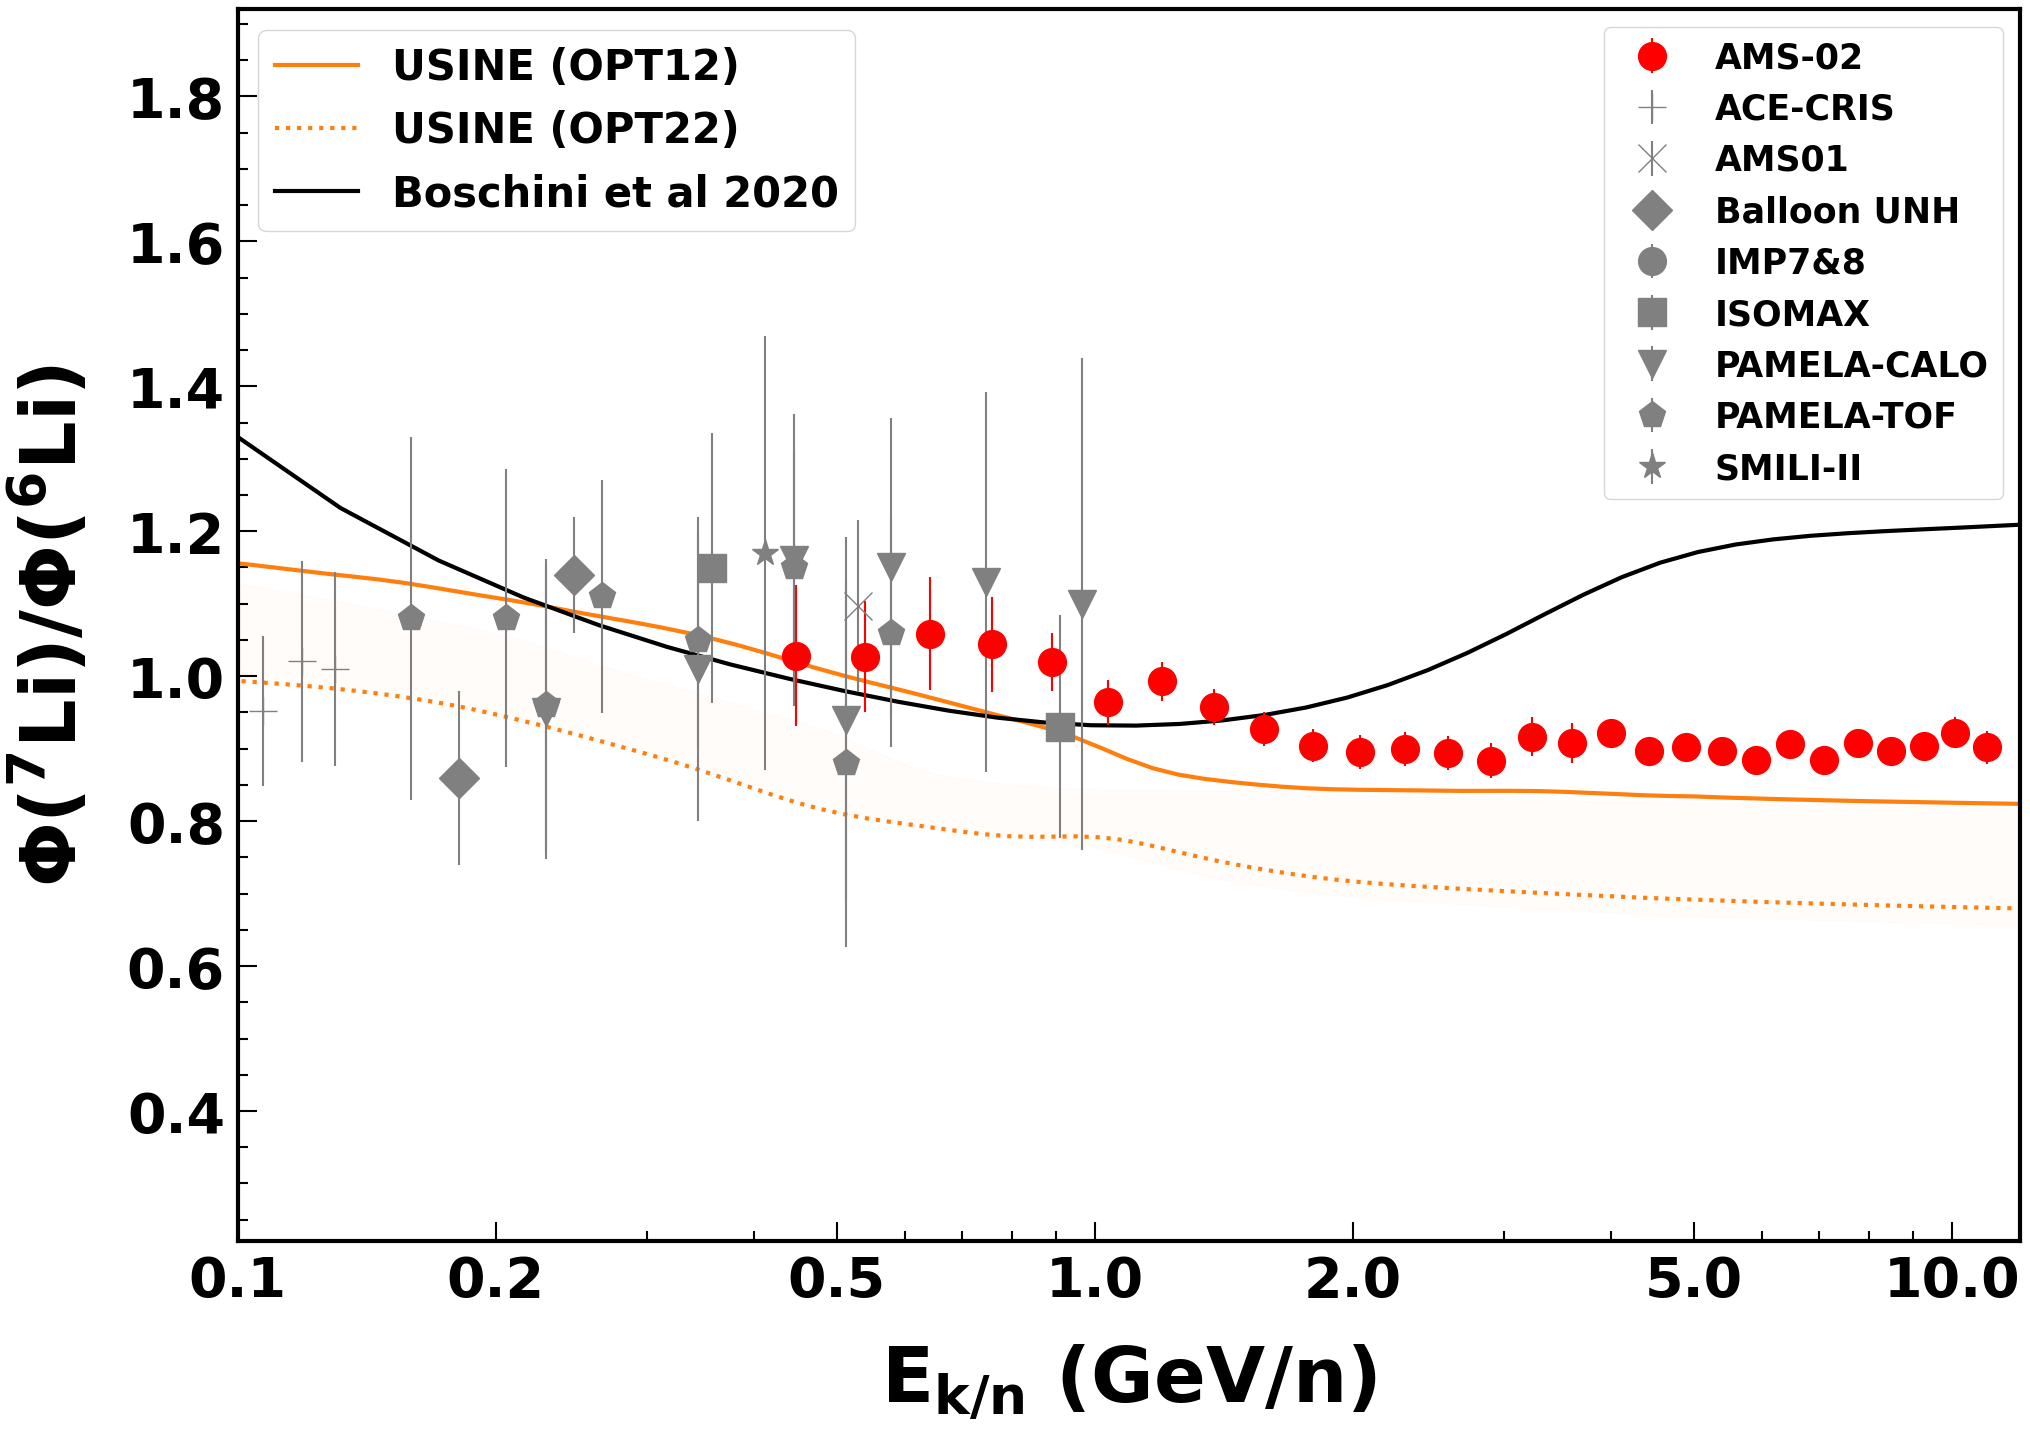

In [29]:
#read my results
manbing_results = '/home/manbing/Documents/Data/data_LiP8/Li_results/Li7ToLi6Ratio_22May.txt'
df_mb = pd.read_csv(manbing_results, delimiter=', ', header=None, comment='#') 
print(df_mb.head())

#read the theory Old_OPT12_We20-D
glap_opt12_usine = '/home/manbing/Documents/Data/data_LiP8/Li_results/Li_USINE/Old_OPT12_We20-D/local_fluxes_7LI6LI_Ekn_Model1DKisoVc_SolMod0DFF_phi_AMS02_201105201605_0_671GV.out'
df_glap_opt12_usine = pd.read_csv(glap_opt12_usine, delimiter='   ', header=None, comment='#') 
graph_glap_opt12_usine = MGraph(df_glap_opt12_usine.iloc[:, 0], df_glap_opt12_usine.iloc[:, 1], np.zeros_like(df_glap_opt12_usine.iloc[:, 1]))

#read the theory OPT12-D
OPT12D_usine = '/home/manbing/Documents/Data/data_LiP8/Li_results/Li_USINE/OPT12-D/local_fluxes_7LI6LI_Ekn_Model1DKisoVc_SolMod0DFF_phi_AMS02_201105201605_0_693GV.out'
df_OPT12_D_usine = pd.read_csv(OPT12D_usine, delimiter='   ', header=None, comment='#') 
graph_OPT12_D_usine = MGraph(df_OPT12_D_usine.iloc[:, 0], df_OPT12_D_usine.iloc[:, 1], np.zeros_like(df_OPT12_D_usine.iloc[:, 1]))

#read the theory OPT12-D
OPT22D_usine = '/home/manbing/Documents/Data/data_LiP8/Li_results/Li_USINE/OPT22-D/local_fluxes_7LI6LI_Ekn_Model1DKisoVc_SolMod0DFF_phi_AMS02_201105201605_0_678GV.out'
df_OPT22_D_usine = pd.read_csv(OPT22D_usine, delimiter='   ', header=None, comment='#') 
graph_OPT22_D_usine = MGraph(df_OPT22_D_usine.iloc[:, 0], df_OPT22_D_usine.iloc[:, 1], np.zeros_like(df_OPT22_D_usine.iloc[:, 1]))

#read the theory OPT12-D
OPT12Up22_usine = '/home/manbing/Documents/Data/data_LiP8/Li_results/Li_USINE/OPT12up22-D/local_fluxes_7LI6LI_Ekn_Model1DKisoVc_SolMod0DFF_phi_AMS02_201105201605_0_682GV.out'
df_OPT12up22_D_usine = pd.read_csv(OPT12Up22_usine, delimiter='   ', header=None, comment='#') 
graph_OPT12up22_D_usine = MGraph(df_OPT12up22_D_usine.iloc[:, 0], df_OPT12up22_D_usine.iloc[:, 1], np.zeros_like(df_OPT12up22_D_usine.iloc[:, 1]))

#read galprop data with solar modulation
Li6_galprop_Boschinietal2020_FFP = '/home/manbing/Documents/Data/data_LiP8/Li_results/GALPROP-fluxes/Mod_flux/ek_flux_mod_Li6.txt'
Li7_galprop_Boschinietal2020_FFP = '/home/manbing/Documents/Data/data_LiP8/Li_results/GALPROP-fluxes/Mod_flux/ek_flux_mod_Li7.txt'
df_li6_galprop_FFP = pd.read_csv(Li6_galprop_Boschinietal2020_FFP, delimiter=' ', header=None, comment='#') 
df_li7_galprop_FFP = pd.read_csv(Li7_galprop_Boschinietal2020_FFP, delimiter=' ', header=None, comment='#') 

graph_ratio_galprop_FFP = MGraph(df_li6_galprop_FFP.iloc[:, 0], df_li7_galprop_FFP.iloc[:, 1]/df_li6_galprop_FFP.iloc[:, 1], np.zeros_like(df_li7_galprop_FFP.iloc[:, 0]))
graph_ratio_galprop_FFP = slice_graph_by_value(graph_ratio_galprop_FFP, [0.1, 13])
#read galprop data without solar modulation
Li6_galprop_Boschinietal2020 = '/home/manbing/Documents/Data/data_LiP8/Li_results/GALPROP-fluxes/IsotopesBoschinietal2020ApJS25027/Li6.txt'
Li7_galprop_Boschinietal2020 = '/home/manbing/Documents/Data/data_LiP8/Li_results/GALPROP-fluxes/IsotopesBoschinietal2020ApJS25027/Li7.txt'
df_li6_galprop = pd.read_csv(Li6_galprop_Boschinietal2020, delimiter='   ', header=None, comment='#') 
df_li7_galprop = pd.read_csv(Li7_galprop_Boschinietal2020, delimiter='   ', header=None, comment='#') 

graph_ratio_galprop = MGraph(df_li7_galprop.iloc[:, 0]*10**(-3), df_li7_galprop.iloc[:, 1]/df_li6_galprop.iloc[:, 1], np.zeros_like(df_li7_galprop.iloc[:, 0]))
graph_ratio_galprop = slice_graph_by_value(graph_ratio_galprop, [0.1, 13])



graph_manbing = MGraph(0.5*(df_mb.iloc[:, 0]+df_mb.iloc[:, 1]),df_mb.iloc[:, 2], df_mb.iloc[:, 3])
fig, ax1 = plt.subplots(1, 1, figsize= (23, 16))

#fig.subplots_adjust(left= 0.15, right=0.95, bottom=0.1, top=0.95)

ax1.plot(graph_glap_opt12_usine.xvalues, graph_glap_opt12_usine.yvalues, linestyle='solid', color='tab:orange', linewidth=3)
#ax1.plot(graph_OPT12up22_D_usine.xvalues, graph_OPT12_D_usine.yvalues, linestyle='dashed', color='tab:green', linewidth=3)
ax1.plot(graph_OPT12up22_D_usine.xvalues, graph_OPT22_D_usine.yvalues, linestyle='dotted', color='tab:orange', linewidth=3)
#ax1.plot(graph_OPT12up22_D_usine.xvalues, graph_OPT12up22_D_usine.yvalues, linestyle='dashdot', color='tab:orange', linewidth=3)
ax1.plot(graph_ratio_galprop_FFP.xvalues, graph_ratio_galprop_FFP.yvalues, linestyle='solid', color='black', linewidth=3)
#ax1.plot(graph_ratio_galprop.xvalues, graph_ratio_galprop.yvalues, linestyle='solid', color='black', linewidth=3)
lines = plt.gca().get_lines()
legend1 = ax1.legend([lines[i] for i in [0, 1, 2]], ['USINE (OPT12)', 'USINE (OPT22)', 'Boschini et al 2020'], loc='upper left', fontsize=30)
plt.gca().add_artist(legend1)
ax1.fill_between(graph_OPT12up22_D_usine.xvalues, graph_glap_opt12_usine.yvalues, graph_OPT12up22_D_usine.yvalues, alpha=0.02, color="tab:orange") 


########################
#plot data points
########################
plot_graph(fig, ax1, graph_manbing, color='red',  style="EP", xlog=False, ylog=False, scale=None, markersize=20, label='AMS-02', marker='o')  
for index, row in grouped.iterrows():
    plot_graph(fig, ax1, graph_ex_others[row.iloc[0]], color='grey',  style="EP", xlog=False, ylog=False, scale=None, markersize=20, label=f'{row.iloc[0]}', marker=row['marker'])  

SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', rf"$\Phi$({ISO_LABELS['Li7']})/$\Phi$({ISO_LABELS['Li6']})", 55, xlimrange=[0.04, 13], ylimrange=[0.22,1.92] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
set_plot_style(ax1)
ax1.legend(fontsize=25, loc='upper right')
ax1.set_xscale('log')
ax1.set_xlim([0.1, 12])
#ax1.legend(bbox_to_anchor=(1.0, 0.5), fontsize=30)
ax1.set_xticks([0.1, 0.2, 0.5, 1, 2, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#fig.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.12)

print(plotfile)
savefig_tofile(fig, plotfile, f"ratio_li7li6_log", show=True) 

In [ ]:
manbing_resultsV0 = '/home/manbing/Documents/Data/data_LiP8/Li_results/manbing_LiIsoRatioV0.txt'
manbing_results = '/home/manbing/Documents/Data/data_LiP8/Li_results/LiIsoRatio_24Apr.txt'
df_mbV0 = pd.read_csv(manbing_resultsV0, delimiter=', ', header=None, comment='#') 
df_mb = pd.read_csv(manbing_results, delimiter=', ', header=None, comment='#')
graph_manbingV0 = MGraph(0.5*(df_mbV0.iloc[:, 0]+df_mbV0.iloc[:, 1]),df_mbV0.iloc[:, 2], df_mbV0.iloc[:, 3])
graph_manbing = MGraph(0.5*(df_mb.iloc[:, 0]+df_mb.iloc[:, 1]),df_mb.iloc[:, 2], df_mb.iloc[:, 3])
fig, ax1 = plt.subplots(1, 1, figsize= (25, 16))
plot_graph(fig, ax1, graph_manbingV0, color='green',  style="EP", xlog=True, ylog=False, scale=None, markersize=25, label='AMS 11.5 yrs V0', marker='o')  
plot_graph(fig, ax1, graph_manbing, color='red',  style="EP", xlog=True, ylog=False, scale=None, markersize=25, label='AMS 11.5 yrs', marker='o')  
#fig.subplots_adjust(left= 0.15, right=0.95, bottom=0.1, top=0.95)
for index, row in grouped.iterrows():
    plot_graph(fig, ax1, graph_ex_others[row.iloc[0]], color='black',  style="EP", xlog=True, ylog=False, scale=None, markersize=25, label=f'{row.iloc[0]}', marker=row['marker'])  

SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', rf"$\Phi$({ISO_LABELS['Li7']})/$\Phi$({ISO_LABELS['Li6']})", 55, xlimrange=[0.04, 13], ylimrange=[0.32,1.8] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setxlog= False)
set_plot_style(ax1) 
ax1.legend(bbox_to_anchor=(1.0, 1.0), fontsize=32)
ax1.set_xticks([0.1, 0.2, 0.5, 1, 2, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
print(plotfile)
fig.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.12)
savefig_tofile(fig, plotfile, f"ratio_li7li6", show=True) 

In [ ]:
Liresultsdir = '/home/manbing/Documents/Data/data_LiP8/Li_results/'
file_unfold = Liresultsdir + 'graph_unfold_factor_Li.npz'
df_unfold = np.load(f'{file_unfold}')
xbinning = Binning(fbinning_energy_Li())

file_unfoldflux = Liresultsdir + 'graph_Li_unfoldflux.npz'
df_flux = np.load(f'{file_unfoldflux}')
graph_unfold_factor = {}
graph_unfoldflux = {}
for iso in ISOTOPES[nuclei]:
    graph_unfold_factor[iso] = MGraph.from_file(df_unfold, f'graph_{iso}_unfoldfactor')
    graph_unfoldflux[iso] = MGraph.from_file(df_flux, f'graph_{iso}_unfoldflux')
    

graph_ballon = {}
graph_ballon['Li6'] = MGraph(np.array([0.24768427380393823]), np.array([0.49396999829888344]), np.array([0.031881048524849]))
graph_ballon['Li7'] = MGraph(np.array([0.22176]), np.array([0.5602099914932239]), np.array([0.033486421227212]))    
    
    
for iso in ISOTOPES[nuclei]:
    fig, ax1 = plt.subplots(figsize=(22, 16))
    plot_graph(fig, ax1, graph_unfoldflux[iso], color='red', style="EP", xlog=True, ylog=True, markersize=28, label=f"AMS-02 (2011-2022)")
    plot_graph(fig, ax1, graph_ballon[iso], color='black', style="EP", xlog=True, ylog=True, markersize=28, label=f"Balloon UNH(1977)")
        #graph_unfoldflux[dec][iso].add_to_file(df_unfoldflux, f'graph_unfoldflux_{dec}{iso}')
         
    ax1.set_ylabel(r"$\mathrm{\Phi \ (m^{-2} sr^{-1} \cdot s^{-1} GeV^{-1})} $", fontsize=35) 
    ax1.set_xlabel(r"$\mathrm{E_{k/n}}$ (GeV/n)", fontsize=35)     
    ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.text(0.7, 0.92, f"{ISO_LABELS[iso]}", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")          
    set_plot_style(ax1) 
    ax1.set_xlim([0.15, 12.5])
    ax1.set_ylim([0.0013, 1.0])
    ax1.legend(loc='center left', fontsize=TEXTSIZE-2)
    #ax1.legend()
    print(plotfile)
    savefig_tofile(fig, plotfile, f'{iso}_unfoldflux', 1)

In [ ]:
figsize1 = (21, 25)
fontsize1 = 40
fontsize2 = 40
mksize = 38
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1308_finebin_untuned_TofV3_V2/graph_massfit_counts.npz'
#filename_init = '/home/manbing/Documents/Data/data_mc/dfile/BeMC_dict_hist_mass_ekin.npz'
df_counts= np.load(f'{filename}')

figSize = (22, 15)
graph_counts_fromfit = {dec: {} for dec in detectors}

hist_mass2d = {dec: {} for dec in detectors}
slicevalue = {'Tof': [0.4, 1.2], 'NaF': [1.2, 4.0], 'Agl':[3.7, 12.0]}

for dec in detectors:
    for iso in isotopes:
        graph_counts_fromfit[dec][iso] = MGraph.from_file(df_counts, f"graph_counts_{dec}Opt{iso}_{iso}")
        graph_counts_fromfit[dec][iso] = slice_graph_by_value(graph_counts_fromfit[dec][iso], slicevalue[dec])
        
for OpIso in isotopes:   
    graph_counts_Optimize = {dec: {} for dec in detectors}
    
    for dec in detectors:
        for iso in isotopes: 
            graph_counts_Optimize[dec][iso] = MGraph.from_file(df_counts, f"graph_counts_{dec}Opt{OpIso}_{iso}")
            graph_counts_Optimize[dec][iso] = slice_graph_by_value(graph_counts_Optimize[dec][iso], slicevalue[dec])
        fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(24, 24))                                                                                                               
        plot_graph(fig, ax1, graph_counts_Optimize[dec]['Li6'], color=ISOTOPES_COLOR['Li6'],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize)  
        plot_graph(fig, ax2, graph_counts_Optimize[dec]['Li7'], color=ISOTOPES_COLOR['Li7'],  style="EP", xlog=False, ylog=False, scale=None, markersize=mksize)      
        set_plot_style(ax1)
        set_plot_style(ax2)
        ax1.text(0.05, 0.96, f"{dec}-{ISO_LABELS['Li6']}, exposure time optimized for {ISO_LABELS[OpIso]} ", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')    
        ax2.text(0.05, 0.96, f"{dec}-{ISO_LABELS['Li7']}, exposure time optimized for {ISO_LABELS[OpIso]} ", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')    
         
        ax2.set_xlabel(r'$\mathrm{E_{k/n} \ (GeV/n)}$', fontsize=fontsize1) 
        ax1.legend(loc="upper right", fontsize=fontsize1) 
        ax1.set_xticklabels([])
        plt.subplots_adjust(hspace=.05)   
        ax1.set_ylabel('counts', fontsize=fontsize1)
        ax2.set_ylabel('counts', fontsize=fontsize1)


        #ax1.legend(fontsize=fontsize1) 
        #ax2.legend(fontsize=fontsize1) 
        #ax3.legend(fontsize=fontsize1) 
        ax1.set_ylim([0.64* min(graph_counts_Optimize[dec]['Li6'].yvalues), 1.35* max(graph_counts_Optimize[dec]['Li6'].yvalues)])
        ax2.set_ylim([0.65* min(graph_counts_Optimize[dec]['Li7'].yvalues), 1.37* max(graph_counts_Optimize[dec]['Li7'].yvalues)])
        
        print(plotfile)
        savefig_tofile(fig, plotfile, f"Li_counts_fromfit_T{OpIso}N_{dec}", show=True)


[0.3 0.3 0.3 1. ]
